# Deep Mario with Random Forest
Actualizado al 25/Nov con 35 columns

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import collections 
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split, RepeatedKFold, GridSearchCV, ParameterGrid
import multiprocessing
import warnings
import sklearn
print(sklearn.__version__) 


1.0.1


In [2]:
df = pd.read_csv("../results/results_SmallFog_X/samples.csv")
print(len(df))

40030


In [3]:
df.loc[0]

Sim                             0
Action                   undeploy
App                             1
CurrentFlavour             medium
SupportedRequests              10
HWReq                           2
DifReqChannels                  0
TotReqChannels                  0
SumRequests                     0
AvgRequests                   0.0
SumLat                          0
AvgLat                        0.0
HWTotal                       2.0
HWUsed                          0
Utilization                   1.0
Degree                          1
Centrality               0.076923
ConnectedUsers                  0
DstHWUsed                       0
DstUtilization                0.0
NextSupportedRequests          10
NextHWReq                       2
NextDifReqChannels              0
NextTotReqChannels              0
NextSumRequests                 0
NextAvgRequests               0.0
NextSumLat                      0
NextAvgLat                    0.0
DstHWTotal                    2.0
NextHWUsed    

In [4]:
#dummies
actions_labels = ["undeploy", "replicate", "migrate", "none", "small", "medium","large"]

actions = np.arange(len(actions_labels)) #dummies
df["Action"] = df["Action"].map(lambda x:actions_labels.index(x))
df["CurrentFlavour"] = df["CurrentFlavour"].map(lambda x:actions_labels.index(x))

In [5]:
df.head()

Sim  Action  App  CurrentFlavour  SupportedRequests  HWReq  DifReqChannels  \
0    0       0    1               5                 10      2               0   
1    0       1    1               5                 10      2               0   
2    0       2    1               5                 10      2               0   
3    0       3    1               5                 10      2               0   
4    0       4    1               5                 10      2               0   

   TotReqChannels  SumRequests  AvgRequests  ...  NextAvgRequests  NextSumLat  \
0               0            0          0.0  ...              0.0           0   
1               0            0          0.0  ...              0.0           0   
2               0            0          0.0  ...              0.0           0   
3               0            0          0.0  ...              0.0           0   
4               0            0          0.0  ...              0.0           0   

   NextAvgLat  DstHWTotal  NextHWUsed  NextUtilization  DstDegree  \
0         0.0         2.0           0         1.000000          1   
1         0.0         2.0           0         1.000000          1   
2         0.0         6.0           4         0.333333          5   
3         0.0         2.0           0         1.000000          1   
4         0.0         2.0           1         0.500000          1   

   DstCentrality  DstConnectedUsers  Reward  
0       0.076923                  0     1.0  
1       0.076923                  0     0.0  
2       0.384615                  0     0.0  
3       0.076923                  0     0.0  
4       0.076923                  0     0.0  

[5 rows x 35 columns]

In [9]:
# UNIT TESTs
# El reward positivo de una Action-undeploy no puede realizarse si hay peticiones futuras
assert len(df.loc[(df["Action"]==0) & (df["Reward"]==1) & (df["NextSumRequests"]>0)])==0

# No puede haber ninguna acción diferente al undeploy con reward positivo si no recibe peticiones
assert len(df.loc[(df["Action"]!=0) & (df["SumRequests"]==0) & (df["Reward"]>0)])==0

# No puede haber ninguna acción de migración positiva cuando hay más de un canal
assert len(df.loc[(df["Action"]==2) & (df["DifReqChannels"]>1) & (df["Reward"]>0)])==0

# No puede haber ninguna acción de replicación positiva cuando hay solo un canal
assert len(df.loc[(df["Action"]==1) & (df["DifReqChannels"]==1) & (df["Reward"]>0)])==0

In [10]:
df = df.drop(columns="Sim") # debug columns

In [11]:
print(list(df.columns))

['Action', 'App', 'CurrentFlavour', 'SupportedRequests', 'HWReq', 'DifReqChannels', 'TotReqChannels', 'SumRequests', 'AvgRequests', 'SumLat', 'AvgLat', 'HWTotal', 'HWUsed', 'Utilization', 'Degree', 'Centrality', 'ConnectedUsers', 'DstHWUsed', 'DstUtilization', 'NextSupportedRequests', 'NextHWReq', 'NextDifReqChannels', 'NextTotReqChannels', 'NextSumRequests', 'NextAvgRequests', 'NextSumLat', 'NextAvgLat', 'DstHWTotal', 'NextHWUsed', 'NextUtilization', 'DstDegree', 'DstCentrality', 'DstConnectedUsers', 'Reward']


In [12]:
# Our state is based on a set of columns
# We can remove columns with NEXT* name
state_cols = [x for x in df.columns if "Next" not in x]
print(state_cols)

['Action', 'App', 'CurrentFlavour', 'SupportedRequests', 'HWReq', 'DifReqChannels', 'TotReqChannels', 'SumRequests', 'AvgRequests', 'SumLat', 'AvgLat', 'HWTotal', 'HWUsed', 'Utilization', 'Degree', 'Centrality', 'ConnectedUsers', 'DstHWUsed', 'DstUtilization', 'DstHWTotal', 'DstDegree', 'DstCentrality', 'DstConnectedUsers', 'Reward']


In [13]:
df = df.loc[:,state_cols]
df.head()

Action  App  CurrentFlavour  SupportedRequests  HWReq  DifReqChannels  \
0       0    1               5                 10      2               0   
1       1    1               5                 10      2               0   
2       2    1               5                 10      2               0   
3       3    1               5                 10      2               0   
4       4    1               5                 10      2               0   

   TotReqChannels  SumRequests  AvgRequests  SumLat  ...  Degree  Centrality  \
0               0            0          0.0       0  ...       1    0.076923   
1               0            0          0.0       0  ...       1    0.076923   
2               0            0          0.0       0  ...       1    0.076923   
3               0            0          0.0       0  ...       1    0.076923   
4               0            0          0.0       0  ...       1    0.076923   

   ConnectedUsers  DstHWUsed  DstUtilization  DstHWTotal  DstDegree  \
0               0          0             0.0         2.0          1   
1               0          0             0.0         2.0          1   
2               0          0             0.0         6.0          5   
3               0          0             0.0         2.0          1   
4               0          0             0.0         2.0          1   

   DstCentrality  DstConnectedUsers  Reward  
0       0.076923                  0     1.0  
1       0.076923                  0     0.0  
2       0.384615                  0     0.0  
3       0.076923                  0     0.0  
4       0.076923                  0     0.0  

[5 rows x 24 columns]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
                                        df.drop(columns = "Reward"),
                                        df['Reward'],
                                        random_state = 0)
print(len(X_train))
print(len(X_test))

30022
10008


In [15]:
#Training                                    
model = RandomForestRegressor(
            n_estimators = 10,
            criterion    = 'squared_error',
            max_depth    = None,
            max_features = 'auto',
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123
         )

model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=123)

In [16]:
importancia_predictores = pd.DataFrame(
                            {'predictor': df.drop(columns = "Reward").columns,
                             'importancia': model.feature_importances_}
                            )

importancia_predictores.sort_values('importancia', ascending=False)


predictor  importancia
0              Action     0.366638
7         SumRequests     0.259664
8         AvgRequests     0.117631
5      DifReqChannels     0.081514
1                 App     0.034172
3   SupportedRequests     0.027366
6      TotReqChannels     0.021203
10             AvgLat     0.020902
13        Utilization     0.017749
12             HWUsed     0.013651
4               HWReq     0.012504
9              SumLat     0.007132
2      CurrentFlavour     0.006190
14             Degree     0.003065
21      DstCentrality     0.002093
19         DstHWTotal     0.001733
18     DstUtilization     0.001464
17          DstHWUsed     0.001205
22  DstConnectedUsers     0.001157
15         Centrality     0.001102
16     ConnectedUsers     0.000935
11            HWTotal     0.000688
20          DstDegree     0.000241

In [17]:
from sklearn.inspection import permutation_importance
importancia = permutation_importance(
                estimator    = model,
                X            = X_train,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = multiprocessing.cpu_count() - 1,
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importancia['feature'] = X_train.columns
df_importancia.sort_values('importances_mean', ascending=False)

importances_mean  importances_std            feature
0           0.570808         0.010375             Action
7           0.307113         0.020378        SumRequests
8           0.123764         0.003891        AvgRequests
5           0.078287         0.001660     DifReqChannels
1           0.078110         0.004537                App
3           0.047536         0.002256  SupportedRequests
13          0.034771         0.001484        Utilization
10          0.031933         0.002005             AvgLat
12          0.029551         0.001398             HWUsed
4           0.019410         0.001211              HWReq
9           0.014784         0.000619             SumLat
6           0.013502         0.000098     TotReqChannels
2           0.012359         0.000165     CurrentFlavour
11          0.001875         0.000385            HWTotal
22          0.001807         0.000462  DstConnectedUsers
15          0.001773         0.000671         Centrality
21          0.001724         0.000741      DstCentrality
18          0.001504         0.000307     DstUtilization
14          0.001487         0.001570             Degree
19          0.001476         0.000483         DstHWTotal
17          0.001404         0.000304          DstHWUsed
16          0.001021         0.000096     ConnectedUsers
20          0.000577         0.000664          DstDegree

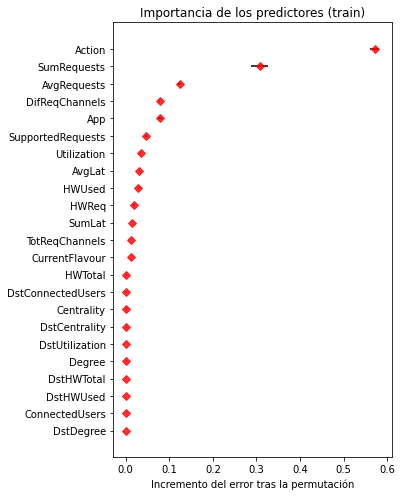

In [18]:
# Gráfico
fig, ax = plt.subplots(figsize=(5, 8))
df_importancia = df_importancia.sort_values('importances_mean', ascending=True)
ax.barh(
    df_importancia['feature'],
    df_importancia['importances_mean'],
    xerr=df_importancia['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importancia['importances_mean'],
    df_importancia['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Importancia de los predictores (train)')
ax.set_xlabel('Incremento del error tras la permutación');

## TESTING

In [19]:
print(state_cols)

['Action', 'App', 'CurrentFlavour', 'SupportedRequests', 'HWReq', 'DifReqChannels', 'TotReqChannels', 'SumRequests', 'AvgRequests', 'SumLat', 'AvgLat', 'HWTotal', 'HWUsed', 'Utilization', 'Degree', 'Centrality', 'ConnectedUsers', 'DstHWUsed', 'DstUtilization', 'DstHWTotal', 'DstDegree', 'DstCentrality', 'DstConnectedUsers', 'Reward']


### A valid undeploy operation

In [20]:
actions_labels = ["undeploy","small","medium","large","migrate","replicate"]

sampleO = [actions_labels.index("undeploy"),1,actions_labels.index("small"),
           10,2, #SupRequest, HWReq
           0,0,0,0,0,0, #6 a zero REQUESTS
           20,18,0.1,2,0.8,0, # Node data
           0,0,20,2,0.8,0
          ]

fact = sampleO
print(fact)
print(len(fact))
col = df.columns[:-1]
dftest = pd.DataFrame(columns=list(col))
dftest.loc[0]=fact
dftest.head()

[0, 1, 1, 10, 2, 0, 0, 0, 0, 0, 0, 20, 18, 0.1, 2, 0.8, 0, 0, 0, 20, 2, 0.8, 0]
23


Action  App  CurrentFlavour  SupportedRequests  HWReq  DifReqChannels  \
0     0.0  1.0             1.0               10.0    2.0             0.0   

   TotReqChannels  SumRequests  AvgRequests  SumLat  ...  Utilization  Degree  \
0             0.0          0.0          0.0     0.0  ...          0.1     2.0   

   Centrality  ConnectedUsers  DstHWUsed  DstUtilization  DstHWTotal  \
0         0.8             0.0        0.0             0.0        20.0   

   DstDegree  DstCentrality  DstConnectedUsers  
0        2.0            0.8                0.0  

[1 rows x 23 columns]

In [21]:
forecasting = model.predict(X = dftest)
print(forecasting)

[1.]


In [22]:
# Iterating on all actions
actions_labels = ["undeploy","small","medium","large","migrate","replicate"]
for i in range(len(actions_labels)):
    print(" Action: %s"%actions_labels[i])
    sampleO = [i,1,actions_labels.index("small"),
               10,2, #SupRequest, HWReq
               0,0,0,0,0,0, #6 a zero REQUESTS
               20,18,0.1,2,0.8,0, # Node data
               0,0,20,2,0.8,0
              ]
    fact = sampleO
    col = df.columns[:-1]
    dftest = pd.DataFrame(columns=list(col))
    dftest.loc[0]=fact
    forecasting = model.predict(X = dftest)
    print(forecasting)

 Action: undeploy
[1.]
 Action: small
[0.]
 Action: medium
[0.]
 Action: large
[0.]
 Action: migrate
[0.]
 Action: replicate
[0.]


### Testing all Rewards a 1

In [23]:
dd = df[df.Reward>0]
len(dd)

9684

In [27]:
actions_labels = ["undeploy", "replicate", "migrate", "none", "small", "medium","large"]
acts = collections.defaultdict(list)
col = df.columns[:-1]
for ix,row in dd.iterrows():
    sample = row.values[:-1]
    print("DifReqChannels: ",row["DifReqChannels"])
    print(sample)
    print("Service flavour: %s + Action: %s = Reward: %0.3f"%
          (actions_labels[int(sample[2])],actions_labels[int(sample[0])],
           row.values[-1])) # the action
    for i in range(len(actions_labels)):
        dftest = pd.DataFrame(columns=list(col))
        sample[2] = i #action is the new action
        dftest.loc[0]=sample
       # print(dftest)
        forecasting = model.predict(X = dftest) #¡OBVIAMENTE PODRIA HACER UNA PREDCCION SOBRE UN GRAN DATAFRAME....
        print("\tPredicción sobre acción: %s valor: %0.3f"%(actions_labels[i],forecasting[0]))
        acts[i].append(forecasting[0])
    if ix == 2:
        break
    


DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          2.
  0.          1.          1.          0.07692308  0.          0.
  0.          2.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[3.         1.         4.         5.         1.         2.
 2.         5.         2.5        2.         1.         6.
 4.         0.33333333 4.         0.30769231 0.         0.
 0.         6.         4.         0.30769231 0.        ]
Service flavour: small + Action: none = Reward: 0.500
	Predicción sobre acción: unde

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.    

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         6.
 3.         0.5        5.         0.38461538 1.         0.
 0.         6.         5.         0.38461538 1.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         4.
 2.         0.5        1.         0.0769230

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.         10.         10.         10.         10.          5.
  1.          0.8         4.          0.30769231  0.          0.
  0.          5.          4.          0.30769231  0.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.        

	Predicción sobre acción: undeploy valor: 0.917
	Predicción sobre acción: replicate valor: 0.917
	Predicción sobre acción: migrate valor: 0.917
	Predicción sobre acción: none valor: 0.917
	Predicción sobre acción: small valor: 0.917
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 5.          2.          4.          2.          1.          2.
  2.          6.          3.         10.          5.          4.
  3.          0.25        1.          0.07692308  0.          4.
  0.66666667  4.          1.          0.07692308  0.        ]
Service flavour: small + Action: medium = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         8.
 0.         1.         3.         0.23076923 1.         0.
 0.         8.         3.         0.23076923 1.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          2.          6.         30.          3.          1.
  1.          2.          2.          2.         

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[3.         1.         4.         5.         1.         1.
 1.         2.         2.         2.         2.         4.
 0.         1.         1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.        ]
Service flavour: small + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  2.0
[ 4.          1.          5.         10.          2.          2.
  2.          5.          2.5        12.          6.  

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         4.
 0.         1.         1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[4.         2.         5.         5.         2.         2.
 2.         6.         3.         5.         2.5        4.
 0.         1.         1.         0.07692308 0.         6.
 1.         4.         1.         0.07692308 0.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predi

	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  3.0
[ 3.          3.          5.         20.          4.          3.
  3.          5.          1.66666667 14.          4.66666667  4.
  0.          1.          1.          0.07692308  1.          0.
  0.          4.          1.          0.07692308  1.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[ 3.          3.          5.         20.      

	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          6.
  0.          1.          5.          0.38461538  0.          0.
  0.          6.          5.          0.38461538  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         8.
 0.         1.         3.         0.23076923 1.         0.
 0.         8.         3.         0.23076923 1.        ]
Service flavour: medium + Action: undep

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         4.
 3.         0.25       1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.  

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          8.
  0.          1.          3.          0.23076923  0.          0.
  0.          8.          3.          0.23076923  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          6.          6.          5.          5.          8.
  4.          0.5         3.          0.23076923  1.          0.
  0.          8.          3.          0.23076923  1.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  1.          0.
  0.          4.          1.          0.07692308  1.        ]
Service flavour: med

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 3.          3.          5.         20.          4.          2.
  2.         16.          8.          4.          2.          5.
  1.          0.8         4.          0.30769231  0.          0.
  0.          5.          4.          0.30769231  0.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  3.0
[6.         2.         5.         5.         2.         3.
 3.         8.         2.66666667 4.         1.33333333 4.
 2.         0.5        1.         0.07692308 1.         4.
 0.8        4.         1.         0.07692308 1.        ]
Service flavour: medium + Action: large = Reward: 1.000
	Predicción sobre acción: undeploy valor: 0.917
	Predicción sobre acción: replicate valor: 0.917
	Predicción sobre acción: migrate valor: 0.917
	Predicción sobre acción: none valor: 0.917
	Predicción sobre acción: small valor: 0.917
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          6.
  2.          0.66666667  4.          0.30769231  0.          0.
  0.         

	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.150
	Predicción sobre acción: large valor: 0.150
DifReqChannels:  1.0
[5.         1.         4.         5.         1.         1.
 1.         2.         2.         5.         5.         6.
 2.         0.66666667 4.         0.30769231 0.         3.
 0.5        6.         4.         0.30769231 0.        ]
Service flavour: small + Action: medium = Reward: 0.200
	Predicción sobre acción: undeploy valor: 0.200
	Predicción sobre acción: replicate valor: 0.200
	Predicción sobre acción: migrate valor: 0.200
	Predicción sobre acción: none valor: 0.200
	Predicción sobre acción: small valor: 0.200
	Predicción sobre acción: medium valor: 0.200
	Predicción sobre acción: large valor: 0.200
DifReqChannels:  0.0
[ 0.          1.          4.          5.          1.          0.
  0.          0.          0.          0.          0.

	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          2.          2.          5.          5.         10.
  0.          1.          1.          0.07692308  1.          0.
  0.         10.          1.          0.07692308  1.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.         10.
  0.        

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 6.          2.          5.          5.          2.          1.
  2.          8.          4.         21.         10.5         6.
  4.          0.33333333  5.          0.38461538  1.          2.
  1.          6.          5.          0.38461538  1.        ]
Service flavour: medium + Action: large = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 3.          3.          5.         20.          4.          2.
  2.          9.          4.5

	Predicción sobre acción: large valor: 0.260
DifReqChannels:  2.0
[1.         2.         5.         5.         2.         2.
 2.         6.         3.         7.         3.5        8.
 5.         0.375      3.         0.23076923 1.         0.
 0.         8.         3.         0.23076923 1.        ]
Service flavour: medium + Action: replicate = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 4.          2.          5.          5.          2.          2.
  2.          6.          3.         12.          6.          8.
  5.          0.375       3.          0.23076923  1.          0.
  0.          8.          3.          0.23076923  1.        ]
Service flavour: medium + Action: smal

	Predicción sobre acción: medium valor: 0.190
	Predicción sobre acción: large valor: 0.190
DifReqChannels:  4.0
[ 3.          2.          6.         30.          3.          4.
  4.          7.          1.75       17.          4.25        5.
  2.          0.6         4.          0.30769231  0.          0.
  0.          5.          4.          0.30769231  0.        ]
Service flavour: large + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  4.0
[ 4.          2.          6.         30.          3.          4.
  4.          8.          2.         17.          4.25        5.
  2.          0.6         4.          0.30769231  0.          2.
  0.33333333  5.          4.         

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  2.          4.          2.         17.          8.5         6.
  2.          0.66666667  4.          0.30769231  1.          0.
  0.          6.          4.          0.30769231  1.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  2.0
[ 3.          1.          5.         10.          2.          2.
  2.         10.          5.         12.          6.          2.
  0.          1.          1.          0.07692308  0.    

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          

	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          3.          3.          7.          7.         10.
  5.          0.5         1.          0.07692308  0.          0.
  0.         10.          1.          0.07692308  0.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[0.         2.         5.         5.         2

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  3.0
[ 5.          2.          6.         30.          3.          3.
  3.         13.          4.33333333 16.          5.33333333  4.
  1.          0.75        1.          0.07692308  4.          4.
  0.66666667  4.          1.          0.07692308  4.        ]
Service flavour: large + Action: medium = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1

	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         2.
 0.         1.         1.         0.07692308 2.         0.
 0.         2.         1.         0.07692308 2.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          6.         30.          3.          0.
 

	Predicción sobre acción: migrate valor: 0.305
	Predicción sobre acción: none valor: 0.305
	Predicción sobre acción: small valor: 0.305
	Predicción sobre acción: medium valor: 0.340
	Predicción sobre acción: large valor: 0.340
DifReqChannels:  0.0
[ 0.          2.          6.         30.          3.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: large + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.        

	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  4.0
[ 1.          1.          5.         10.          2.          4.
  4.         26.          6.5        16.          4.          5.
  3.          0.4         4.          0.30769231  1.          0.
  0.          5.          4.          0.30769231  1.        ]
Service flavour: medium + Action: replicate = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 0.600
DifReqChannels:  3.0
[ 4.          1.          5.         10.          2.          3.
  4.         28.         

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          4.          5.          1.          0.
  0.          0.          0.          0.          0.         10.
  1.          0.9         1.          0.07692308  0.          0.
  0.         10.          1.          0.07692308  0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         6.
 1.         0.83333333 4.         0.30769231 1.         0.
 0.         6.         4.         0.30769231 1.        ]
Service flavour: small + Action: undeplo

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.         10.
  1.          0.9         1.          0.07692308  0.          0.
  0.         10.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  1.          0.
  0.          4.          1.          0.07692308  1.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 5.          1.          4.          5.          1.          2.
  3.         11.          3.66666667 34.         11.33333333  4.
  3.          0.25        1.          0.07692308  0.

	Predicción sobre acción: medium valor: 0.127
	Predicción sobre acción: large valor: 0.127
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         4.
 3.         0.25       1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.    

	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.100
	Predicción sobre acción: large valor: 0.100
DifReqChannels:  1.0
[3.         2.         5.         5.         2.         1.
 1.         3.         3.         7.         7.         6.
 0.         1.         5.         0.38461538 0.         0.
 0.         6.         5.         0.38461538 0.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.300
	Predicción sobre acción: replicate valor: 0.300
	Predicción sobre acción: migrate valor: 0.300
	Predicción sobre acción: none valor: 0.300
	Predicción sobre acción: small valor: 0.300
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.450
DifReqChannels:  1.0
[4.         2.         5.         5.         2.         1.
 1.         3.         3.         7.         7.         6.


	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         2.
 1.         0.5        1.         0.07692308 0.         0.
 0.         2.         1.         0.07692308 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         

	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         2.
 1.         0.5        1.         0.07692308 0.         0.
 0.         2.         1.         0.07692308 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[3.         2.         5.         5.         2.         1.
 1.    

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         2.
 1.         0.5        1.         0.07692308 0.         0.
 0.         2.         1.         0.07692308 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          2.
  0.          1.          1.          0.07692308  0.          0.
  0.          2.          1.          0.07692308  0.    

	Predicción sobre acción: undeploy valor: 0.125
	Predicción sobre acción: replicate valor: 0.125
	Predicción sobre acción: migrate valor: 0.125
	Predicción sobre acción: none valor: 0.125
	Predicción sobre acción: small valor: 0.125
	Predicción sobre acción: medium valor: 0.125
	Predicción sobre acción: large valor: 0.125
DifReqChannels:  1.0
[ 4.          2.          6.         30.          3.          1.
  1.          3.          3.          2.          2.          4.
  0.          1.          1.          0.07692308  1.          0.
  0.          4.          1.          0.07692308  1.        ]
Service flavour: large + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.

	Predicción sobre acción: none valor: 0.950
	Predicción sobre acción: small valor: 0.950
	Predicción sobre acción: medium valor: 0.950
	Predicción sobre acción: large valor: 0.950
DifReqChannels:  1.0
[3.         2.         5.         5.         2.         1.
 1.         5.         5.         2.         2.         4.
 0.         1.         1.         0.07692308 2.         0.
 0.         4.         1.         0.07692308 2.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.300
	Predicción sobre acción: replicate valor: 0.300
	Predicción sobre acción: migrate valor: 0.300
	Predicción sobre acción: none valor: 0.300
	Predicción sobre acción: small valor: 0.300
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[4.         2.         5.         5.         2.         1.
 1.         3.         3.         2.         2.         4.
 0.         1.         1.         0.07692308 2.

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          2.
  0.          1.          1.          0.07692308  1.          0.
  0.          2.          1.          0.07692308  1.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.       

	Predicción sobre acción: large valor: 0.270
DifReqChannels:  2.0
[ 4.          1.          6.         20.          5.          2.
  2.          9.          4.5        17.          8.5         8.
  3.          0.625       3.          0.23076923  1.          3.
  0.5         8.          3.          0.23076923  1.        ]
Service flavour: large + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 5.          1.          6.         20.          5.          2.
  2.         10.          5.         17.          8.5         8.
  3.          0.625       3.          0.23076923  1.          3.
  0.5         8.          3.          0.23076923  1.        ]
Service flavour: lar

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 6.          2.          4.          2.          1.          2.
  2.         23.         11.5         4.          2.          6.
  5.          0.16666667  5.          0.38461538  0.          4.
  1.          6.          5.          0.38461538  0.        ]
Service flavour: small + Action: large = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  3.0
[ 3.          3.          5.         20.          4.          3.
  3.         11.          3.66666667 12.          4.          4.
  0.          1.          1.          0.07692308  4.    

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          6.         30.          3.          0.
  0.          0.          0.          0.          0.          8.
  0.          1.          3.          0.23076923  1.          0.
  0.          8.          3.          0.23076923  1.        ]
Service flavour: large + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          4.
  2.          0.5         1.          0.07692308  1. 

	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          4.
  2.          0.5         1.          0.07692308  1.          0.
  0.          4.          1.          0.07692308  1.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          6.         20.          5.          0.
  0.          0.          

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[1.         1.         4.         5.         1.         2.
 2.         9.         4.5        2.         1.         2.
 0.         1.         1.         0.07692308 2.         2.
 0.4        2.         1.         0.07692308 2.        ]
Service flavour: small + Action: replicate = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          2. 

	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         2.
 0.         1.         1.         0.07692308 0.         0.
 0.         2.         1.         0.07692308 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          4.          5.          1.          0.
  0.          0.          0.          0.          0.         10.
  9.          0.1         1.          0.07692308  0.          0.
  0.         10.          1.          0.07692308  0.    

	Predicción sobre acción: medium valor: 0.700
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         4.
 2.         0.5        1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          2.          6.         30.          3.          1.
  1.          2.          2.          2.          2.          4.
  0.          1.          1.          0.07692308  1.          2.
  0.33333333  4.          1.          0.07692308  1.   

	Predicción sobre acción: medium valor: 0.490
	Predicción sobre acción: large valor: 0.690
DifReqChannels:  2.0
[ 3.          1.          5.         10.          2.          2.
  2.          6.          3.          7.          3.5         4.
  2.          0.5         1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.450
DifReqChannels:  2.0
[ 4.          1.          5.         10.          2.          2.
  2.          7.          3.5         7.          3.5         4.
  2.          0.5         1.          0.07692308  0.          2.
  0.33333333  4.          1.        

	Predicción sobre acción: medium valor: 0.360
	Predicción sobre acción: large valor: 0.360
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          2.
  0.          1.          1.          0.07692308  0.          0.
  0.          2.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         4.
 2.         0.5        1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.   

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[3.         1.         4.         5.         1.         2.
 2.         4.         2.         4.         2.         2.
 1.         0.5        1.         0.07692308 3.         0.
 0.         2.         1.         0.07692308 3.        ]
Service flavour: small + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  2.0
[5.         1.         4.         5.         1.         2.
 2.         4.         2.         4.         2.         2.
 1.         0.5        1.         0.07692308 3.         5.
 0.83333333 2.         1.         0.07692308 3.        ]
Service flavour: smal

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[4.         2.         5.         5.         2.         1.
 1.         1.         1.         7.         7.         6.
 1.         0.83333333 5.         0.38461538 1.         0.
 0.         6.         5.         0.38461538 1.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 0.950
	Predicción sobre acción: replicate valor: 0.950
	Predicción sobre acción: migrate valor: 0.950
	Predicción sobre acción: none valor: 0.950
	Predicción sobre acción: small valor: 0.950
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[6.         2.      

	Predicción sobre acción: small valor: 0.180
	Predicción sobre acción: medium valor: 0.180
	Predicción sobre acción: large valor: 0.180
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         2.
 0.         1.         1.         0.07692308 0.         0.
 0.         2.         1.         0.07692308 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[3.         2.         4.         2.         1.         1.
 1.         2.         2.         2.         2.         4.
 3.         0.25       1.         0.07692308 0.         0.
 0.         4.         1.    

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 5.          1.          6.         20.          5.          1.
  1.          4.          4.          5.          5.         10.
  4.          0.6         1.          0.07692308  1.          8.
  1.         10.          1.          0.07692308  1.        ]
Service flavour: large + Action: medium = Reward: 0.400
	Predicción sobre acción: undeploy valor: 0.460
	Predicción sobre acción: replicate valor: 0.460
	Predicción sobre acción: migrate valor: 0.460
	Predicción sobre acción: none valor: 0.460
	Predicción sobre acción: small valor: 0.460
	Predicción sobre acción: medium valor: 0.460
	Predicción sobre acción: large valor: 0.460
DifReqChannels:  0

	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          8.
  0.          1.          3.          0.23076923  0.          0.
  0.          8.          3.          0.23076923  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  2.          8.          4.         14.          7.          6.
  0.    

	Predicción sobre acción: none valor: 0.063
	Predicción sobre acción: small valor: 0.063
	Predicción sobre acción: medium valor: 0.057
	Predicción sobre acción: large valor: 0.057
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         2.
 1.         0.5        1.         0.07692308 0.         0.
 0.         2.         1.         0.07692308 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          2.          4.          2.          1.          1.
  1.          1.          1.         12.         12.          2.
  1.          0.5         1.    

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 0.000
	Predicción sobre acción: large valor: 0.000
DifReqChannels:  1.0
[5.         1.         4.         5.         1.         1.
 1.         2.         2.         0.         0.         8.
 1.         0.875      3.         0.23076923 1.         0.
 0.         8.         3.         0.23076923 1.        ]
Service flavour: small + Action: medium = Reward: 0.100
	Predicción sobre acción: undeploy valor: 0.120
	Predicción sobre acción: replicate valor: 0.120
	Predicción sobre acción: migrate valor: 0.120
	Predicción sobre acción: none valor: 0.120
	Predicción sobre acción: small valor: 0.120
	Predicción sobre acción: medium valor: 0.120
	Predicción sobre acción: large valor: 0.120
DifReqChannels:  0.0
[0.         1.      

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          6.         30.          3.          0.
  0.          0.          0.          0.          0.          5.
  1.          0.8         5.          0.38461538  0.          0.
  0.          5.          5.          0.38461538  0.        ]
Service flavour: large + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels: 

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[5.         2.         4.         2.         1.         1.
 1.         7.         7.         2.         2.         5.
 1.         0.8        4.         0.30769231 1.         2.
 1.         5.         4.         0.30769231 1.        ]
Service flavour: small + Action: medium = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         2.
 0.         1.         1.         0.07692308 0

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          6.
  2.          0.66666667  5.          0.38461538  1.          0.
  0.          6.          5.          0.38461538  1.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          2.          2.         14.         14.          6.
  2.    

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          8.
  0.          1.          3.          0.23076923  0.          0.
  0.          8.          3.          0.23076923  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          6.
  2.          0.66666667  4.          0.30769231  0.          0.
  0.          6.          4.          0.30769231  0.        ]
Service flavour:

	Predicción sobre acción: small valor: 0.700
	Predicción sobre acción: medium valor: 0.700
	Predicción sobre acción: large valor: 0.700
DifReqChannels:  1.0
[ 3.          1.          4.          5.          1.          1.
  2.          4.          2.         14.          7.          6.
  0.          1.          5.          0.38461538  3.          0.
  0.          6.          5.          0.38461538  3.        ]
Service flavour: small + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          1.          4.          5.          1.          0.
  0.          0.          0.          0.          0.         10.
  0.          1.          1.          0.07692308  0.     

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 5.          2.          6.         30.          3.          1.
  1.          2.          2.          2.          2.          4.
  0.          1.          1.          0.07692308  1.          6.
  1.          4.          1.          0.07692308  1.        ]
Service flavour: large + Action: medium = Reward: 0.400
	Predicción sobre acción: undeploy valor: 0.280
	Predicción sobre acción: replicate valor: 0.280
	Predicción sobre acción: migrate valor: 0.280
	Predicción sobre acción: none valor: 0.280
	Predicción sobre acción: small valor: 0.280
	Predicción sobre acción: medium valor: 0.280
	Predicción sobre acción: large valor: 0.400
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         4.
 0.         1.         1.         0.07692308 1.         0.
 0.     

	Predicción sobre acción: replicate valor: 1.780
	Predicción sobre acción: migrate valor: 1.780
	Predicción sobre acción: none valor: 1.780
	Predicción sobre acción: small valor: 1.780
	Predicción sobre acción: medium valor: 1.780
	Predicción sobre acción: large valor: 1.780
DifReqChannels:  2.0
[ 1.          2.          5.          5.          2.          2.
  3.          8.          2.66666667 17.          5.66666667  8.
  6.          0.25        3.          0.23076923  3.          1.
  0.1         8.          3.          0.23076923  3.        ]
Service flavour: medium + Action: replicate = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          2.          5.          5. 

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 5.          1.          6.         20.          5.          1.
  2.          4.          2.         22.         11.          8.
  3.          0.625       3.          0.23076923  1.          6.
  0.6         8.          3.          0.23076923  1.        ]
Service flavour: large + Action: medium = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.460
	Predicción sobre acción: replicate valor: 0.460
	Predicción sobre acción: migrate valor: 0.460
	Predicción sobre acción: none valor: 0.460
	Predicción sobre acción: small valor: 0.460
	Predicción sobre acción: medium valor: 0.460
	Predicción sobre acción: large valor: 0.460
DifReqChannels:  2.0
[ 5.          1.          4.          5.          1.          2.
  4.         14.          3.5        28.          7.          6.
  1.          0.83333333  5.          0.38461538  1.   

	Predicción sobre acción: replicate valor: 0.067
	Predicción sobre acción: migrate valor: 0.067
	Predicción sobre acción: none valor: 0.067
	Predicción sobre acción: small valor: 0.067
	Predicción sobre acción: medium valor: 0.063
	Predicción sobre acción: large valor: 0.063
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         6.
 1.         0.83333333 5.         0.38461538 1.         0.
 0.         6.         5.         0.38461538 1.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 5.          2.          4.          2.          1.          1.
 

	Predicción sobre acción: migrate valor: 0.400
	Predicción sobre acción: none valor: 0.400
	Predicción sobre acción: small valor: 0.400
	Predicción sobre acción: medium valor: 0.400
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  4.0
[ 4.          2.          6.         30.          3.          4.
  5.         28.          5.6        31.          6.2         8.
  5.          0.375       3.          0.23076923  1.          0.
  0.          8.          3.          0.23076923  1.        ]
Service flavour: large + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  3.0
[ 5.          2.          6.         30.          3.          3.
  4.         23.          5.75

	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          2.
  0.          1.          1.          0.07692308  0.          0.
  0.          2.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[3.         1.         4.         5.         1.         1.
 1.         2.         2.         0.         0.         4.
 2.         0.5        1.         0.07692308 3.         0.
 0.  

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          5.
  0.          1.          4.          0.30769231  1.          0.
  0.          5.          4.          0.30769231  1.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.    

	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          2.          2.          5.          5.         10.
  1.          0.9         1.          0.07692308  1.          0.
  0.         10.          1.          0.07692308  1.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.         10.
  1.          0.9         1.          0.07692308  1.          0.
  0.         10.          1.        

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         6.
 0.         1.         4.         0.30769231 2.         0.
 0.         6.         4.         0.30769231 2.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          2.          4.          2.          1.          1.
  1.          2.          2.         12.         12.          6.
  0.          1.          4.          0.30769231  2.          0.
  0.          6.          4.          0.30769231  2.    

	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  2.0
[1.         1.         4.         5.         1.         2.
 2.         7.         3.5        2.         1.         5.
 0.         1.         5.         0.38461538 1.         1.
 0.25       5.         5.         0.38461538 1.        ]
Service flavour: small + Action: replicate = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.   

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         8.
 1.         0.875      3.         0.23076923 0.         0.
 0.         8.         3.         0.23076923 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 1.          2.  

	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[ 4.          1.          5.         10.          2.          1.
  1.          6.          6.          2.          2.          6.
  4.          0.33333333  5.          0.38461538  3.          2.
  1.          6.          5.          0.38461538  3.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1

	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          4.
  2.          0.5         1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         4.
 3.         0.25       1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.        ]
Service flavour: small + Action: undepl

	Predicción sobre acción: replicate valor: 0.450
	Predicción sobre acción: migrate valor: 0.450
	Predicción sobre acción: none valor: 0.450
	Predicción sobre acción: small valor: 0.450
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[ 4.          1.          5.         10.          2.          1.
  2.          9.          4.5         8.          4.          5.
  0.          1.          5.          0.38461538  1.          4.
  1.          5.          5.          0.38461538  1.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 1.          1.          4.          5.     

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          4.          2.          1.          0.
  0.          0.          0.          0.          0.         10.
  5.          0.5         1.          0.07692308  0.          0.
  0.         10.          1.          0.07692308  0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.     

	Predicción sobre acción: migrate valor: 0.530
	Predicción sobre acción: none valor: 0.530
	Predicción sobre acción: small valor: 0.530
	Predicción sobre acción: medium valor: 0.530
	Predicción sobre acción: large valor: 0.530
DifReqChannels:  0.0
[ 0.          2.          5.          5.          2.          0.
  0.          0.          0.          0.          0.         10.
  0.          1.          1.          0.07692308  1.          0.
  0.         10.          1.          0.07692308  1.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          2.          6.         30.          3.          1.
  1.          2.          

	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          6.
  4.          0.33333333  5.          0.38461538  0.          0.
  0.          6.          5.          0.38461538  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          8.
  5.          0.375       3.          0.23076923  0.          0.
  0.          8.          3.    

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.         10.
  2.          0.8         1.          0.07692308  0.          0.
  0.         10.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          5.
  1.          0.8         5.          0.38461538  0.          0.
  0.          5.          5.    

	Predicción sobre acción: small valor: 0.573
	Predicción sobre acción: medium valor: 0.573
	Predicción sobre acción: large valor: 0.573
DifReqChannels:  1.0
[ 3.          1.          5.         10.          2.          1.
  1.          8.          8.         10.         10.          6.
  0.          1.          4.          0.30769231  2.          0.
  0.          6.          4.          0.30769231  2.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.450
	Predicción sobre acción: replicate valor: 0.450
	Predicción sobre acción: migrate valor: 0.450
	Predicción sobre acción: none valor: 0.450
	Predicción sobre acción: small valor: 0.450
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.400
DifReqChannels:  1.0
[ 4.          1.          5.         10.          2.          1.
  1.          3.          3.         10.         10.          6.
  0.          1.          4.          0.30769231  2.    

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          1.          6.         20.          5.          1.
  2.          8.          4.         25.         12.5         6.
  0.          1.          4.          0.30769231  1.          1.
  0.2         6.          4.          0.30769231  1.        ]
Service flavour: large + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 5.          1.          6.         20.          5.          1.
  1.          4.          4.         15.         15.          6.
  0.        

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[3.         1.         4.         5.         1.         1.
 1.         1.         1.         2.         2.         4.
 1.         0.75       1.         0.07692308 1.         0.
 0.         4.         1.         0.07692308 1.        ]
Service flavour: small + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.150
	Predicción sobre acción: large valor: 0.150
DifReqChannels:  1.0
[5.         1.         4.         5.         1.         1.
 1.         1.         1.         2.         2.         4.
 

	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.740
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         4.
 0.         1.         1.         0.07692308 2.         0.
 0.         4.         1.         0.07692308 2.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.  

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[4.         2.         5.         5.         2.         1.
 1.         2.         2.         7.         7.         5.
 3.         0.4        4.         0.30769231 1.         0.
 0.         5.         4.         0.30769231 1.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[6.         2.         5.         5.         2.         1.
 1.         1.         1.         7.         7.         5.
 3.         0.4        4.         0.30769231 1.         0.
 0.         5.         4.         0.30769231 1.        ]
Service flavour: medium + Action: large = Reward: 0.067
	Predicci

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          1.          6.         20.          5.          1.
  1.          5.          5.          7.          7.          5.
  0.          1.          4.          0.30769231  0.          0.
  0.          5.          4.          0.30769231  0.        ]
Service flavour: large + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 5.          1.          6.         20.          5.          1.
  1.          6.          6.          7.          7.          5.
  0.          1.          4.          0.30769231  0.          0.
  0.          5.          4.        

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 4.          1.          5.         10.          2.          2.
  4.         20.          5.         41.         10.25        4.
  1.          0.75        1.          0.07692308  1.          0.
  0.          4.          1.          0.07692308  1.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         2.
 0.         1.         1.         0.07692308 0.         0.
 0.         2.         1.         0.07692308 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         5.
 0.         1.         4.         0.30769231 0.         0.
 0.         5.         4.    

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:

	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          2.          5.          5.          2.          1.
  1.          2.          2.          5.          5.         10.
  3.          0.7         1.          0.07692308  0.          0.
  0.         10.          1.          0.07692308  0.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 6.          2.          5.          5.          2.          1.
  1.          2.          2.          5.          5.         10.
  3.          0.7         1.          0.07692308  0.   

	Predicción sobre acción: migrate valor: 0.900
	Predicción sobre acción: none valor: 0.900
	Predicción sobre acción: small valor: 0.900
	Predicción sobre acción: medium valor: 0.900
	Predicción sobre acción: large valor: 0.900
DifReqChannels:  2.0
[ 3.          1.          5.         10.          2.          2.
  2.          6.          3.          4.          2.          4.
  2.          0.5         1.          0.07692308  3.          0.
  0.          4.          1.          0.07692308  3.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.450
DifReqChannels:  2.0
[ 4.          1.          5.         10.          2.          2.
  2.          8.          4.  

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          5.          5.          2.          0.
  0.          0.          0.          0.          0.         10.
  4.          0.6         1.          0.07692308  0.          0.
  0.         10.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         2.
 0.         1.         1.         0.07692308 2.         0.
 0.  

	Predicción sobre acción: none valor: 0.600
	Predicción sobre acción: small valor: 0.600
	Predicción sobre acción: medium valor: 0.600
	Predicción sobre acción: large valor: 0.940
DifReqChannels:  1.0
[3.         2.         5.         5.         2.         1.
 1.         5.         5.         2.         2.         2.
 0.         1.         1.         0.07692308 0.         0.
 0.         2.         1.         0.07692308 0.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.300
	Predicción sobre acción: replicate valor: 0.300
	Predicción sobre acción: migrate valor: 0.300
	Predicción sobre acción: none valor: 0.300
	Predicción sobre acción: small valor: 0.300
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[4.         2.         5.         5.         2.         1.
 1.         5.         5.         2.         2.         2.
 0.         1.         1.         0.07692308 0.

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  3.0
[ 6.          1.          5.         10.          2.          3.
  4.          8.          2.         22.          5.5        10.
  3.          0.7         1.          0.07692308  0.          4.
  0.5        10.          1.          0.07692308  0.        ]
Service flavour: medium + Action: large = Reward: 0.400
	Predicción sobre acción: undeploy valor: 0.200
	Predicción sobre acción: replicate valor: 0.200
	Predicción sobre acción: migrate valor: 0.200
	Predicción sobre acción: none valor: 0.200
	Predicción sobre acción: small valor: 0.200
	Predicción sobre acción: medium valor: 0.255
	Predicción sobre acción: large valor: 0.255
DifReqChannels:  3

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 3.          1.          6.         20.          5.          2.
  3.         19.          6.33333333 24.          8.          6.
  1.          0.83333333  4.          0.30769231  0.          0.
  0.          6.          4.          0.30769231  0.        ]
Service flavour: large + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.400
	Predicción sobre acción: replicate valor: 0.400
	Predicción sobre acción: migrate valor: 0.400
	Predicción sobre acción: none valor: 0.400
	Predicción sobre acción: small valor: 0.400
	Predicción sobre acción: medium valor: 0.400
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  2.0
[ 4.          1.          6.         20.          5.          2.
  3.         20.          6.66666667 24.          8.          6.
  1.          0.83333333  4.          0.30769231  0.          1.
  0.16666667  6.          4.         

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.         10.
  2.          0.8         1.          0.07692308  1.          0.
  0.         10.          1.          0.07692308  1.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          6.         20.          5.          0.
  0.          0.          

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          2.          2.          2.          2.          6.
  2.          0.66666667  5.          0.38461538  1.          0.
  0.          6.          5.          0.38461538  1.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  2.0
[ 3.          3.          5.         20.          4.          2.
  2.          5.          2.5         2.          1.          4.
  0.          1.          1.          0.07692308  1.          0.
  0.          4.          1.          0.07692308  1.        ]
Service flavour: med

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         6.
 2.         0.66666667 5.         0.38461538 0.         0.
 0.         6.         5.         0.38461538 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         

	Predicción sobre acción: replicate valor: 0.750
	Predicción sobre acción: migrate valor: 0.750
	Predicción sobre acción: none valor: 0.750
	Predicción sobre acción: small valor: 0.750
	Predicción sobre acción: medium valor: 0.750
	Predicción sobre acción: large valor: 0.750
DifReqChannels:  1.0
[ 3.          2.          5.          5.          2.          1.
  2.          3.          1.5        21.         10.5         5.
  0.          1.          5.          0.38461538  2.          0.
  0.          5.          5.          0.38461538  2.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.250
	Predicción sobre acción: replicate valor: 0.250
	Predicción sobre acción: migrate valor: 0.250
	Predicción sobre acción: none valor: 0.250
	Predicción sobre acción: small valor: 0.250
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.450
DifReqChannels:  1.0
[ 4.          2.          5.          5.      

	Predicción sobre acción: undeploy valor: 0.130
	Predicción sobre acción: replicate valor: 0.130
	Predicción sobre acción: migrate valor: 0.130
	Predicción sobre acción: none valor: 0.130
	Predicción sobre acción: small valor: 0.130
	Predicción sobre acción: medium valor: 0.130
	Predicción sobre acción: large valor: 0.130
DifReqChannels:  1.0
[6.         1.         4.         5.         1.         1.
 1.         2.         2.         0.         0.         6.
 5.         0.16666667 4.         0.30769231 2.         4.
 0.5        6.         4.         0.30769231 2.        ]
Service flavour: small + Action: large = Reward: 0.050
	Predicción sobre acción: undeploy valor: 0.062
	Predicción sobre acción: replicate valor: 0.062
	Predicción sobre acción: migrate valor: 0.062
	Predicción sobre acción: none valor: 0.062
	Predicción sobre acción: small valor: 0.062
	Predicción sobre acción: medium valor: 0.068
	Predicción sobre acción: large valor: 0.068
DifReqChannels:  0.0
[0.         1.       

	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  1.          0.
  0.          4.          1.          0.07692308  1.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.         10.
  0.          1.          1.          0.07692308  1.          0.
  0.         10.          1.          0.07692308  1.        ]
Service flavour:

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          5.
  1.          0.8         4.          0.30769231  2.          0.
  0.          5.          4.          0.30769231  2.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          4.          5.          1.          0.
  0.          0.          0.          0.          0.         10.
  0.          1.          1.          0.07692308  0.          0.
  0.         10.          1.          0.07692308  0.        ]
Service flavour:

	Predicción sobre acción: migrate valor: 0.220
	Predicción sobre acción: none valor: 0.220
	Predicción sobre acción: small valor: 0.220
	Predicción sobre acción: medium valor: 0.220
	Predicción sobre acción: large valor: 0.240
DifReqChannels:  0.0
[ 0.          2.          6.         30.          3.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: large + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.        

	Predicción sobre acción: undeploy valor: 0.200
	Predicción sobre acción: replicate valor: 0.200
	Predicción sobre acción: migrate valor: 0.200
	Predicción sobre acción: none valor: 0.200
	Predicción sobre acción: small valor: 0.200
	Predicción sobre acción: medium valor: 0.200
	Predicción sobre acción: large valor: 0.200
DifReqChannels:  2.0
[ 3.          3.          5.         20.          4.          2.
  2.         12.          6.          4.          2.          4.
  0.          1.          1.          0.07692308  1.          0.
  0.          4.          1.          0.07692308  1.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          3.          3.          7.          7.          6.
  2.          0.66666667  5.          0.38461538  0.

	Predicción sobre acción: replicate valor: 0.110
	Predicción sobre acción: migrate valor: 0.110
	Predicción sobre acción: none valor: 0.110
	Predicción sobre acción: small valor: 0.110
	Predicción sobre acción: medium valor: 0.147
	Predicción sobre acción: large valor: 0.147
DifReqChannels:  2.0
[4.         2.         5.         5.         2.         2.
 2.         5.         2.5        5.         2.5        2.
 0.         1.         1.         0.07692308 1.         4.
 0.8        2.         1.         0.07692308 1.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         2.
 0.         1.         1.         0.07692308 1.         0.
 0.         2.         1.         0.07692308 1.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.        

	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          5.
  0.          1.          5.          0.38461538  0.          0.
  0.          5.          5.          0.38461538  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          8.
  0.          1.          3.          0.23076923  1.          0.
  0.          8.          3.    

	Predicción sobre acción: medium valor: 0.295
	Predicción sobre acción: large valor: 0.295
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          2.
  0.          1.          1.          0.07692308  0.          0.
  0.          2.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          1.          6.         20.          5.          1.
  2.          6.          3.         16.          8.          5.
  0.          1.          5.          0.38461538  1.          2.
  0.5         5.          5.    

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         8.
 6.         0.25       3.         0.23076923 0.         0.
 0.         8.         3.         0.23076923 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[5.         2.         4.         2.         1.         1.
 1.         3.         3.         0.         0.         8.
 6.         0.25       3.         0.23076923 0.         1.
 0.16666667 8.         3.         0.23076923 0.        ]
Service flavour: 

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          6.         30.          3.          0.
  0.          0.          0.          0.          0.          8.
  5.          0.375       3.          0.23076923  0.          0.
  0.          8.          3.          0.23076923  0.        ]
Service flavour: large + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[3.         2.         4.         2.         1.         1.
 1.         2.         2.         0.         0.         4.
 3.         0.25       1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.    

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 5.          1.          6.         20.          5.          1.
  1.          5.          5.          5.          5.          6.
  0.          1.          4.          0.30769231  1.          6.
  1.          6.          4.          0.30769231  1.        ]
Service flavour: large + Action: medium = Reward: 0.400
	Predicción sobre acción: undeploy valor: 0.410
	Predicción sobre acción: replicate valor: 0.410
	Predicción sobre acción: migrate valor: 0.410
	Predicción sobre acción: none valor: 0.410
	Predicción sobre acción: small valor: 0.410
	Predicción sobre acción: medium valor: 0.410
	Predicción sobre acción: large valor: 0.590
DifReqChannels:  1.0
[ 3.          1.          5.         10.          2.          1.
  1.          6.          6.          2.          2.          4.
  0.          1.          1.          0.07692308  4.          0.
  0.          4.          1.          0.07692308  4.        ]
Service flavour: me

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         6.
 0.         1.         5.         0.38461538 1.         0.
 0.         6.         5.         0.38461538 1.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 4.          2.          5.          5.          2.          2.
  5.         22.          4.4        42.         

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         5.
 4.         0.2        4.         0.30769231 1.         0.
 0.         5.         4.         0.30769231 1.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[3.         2.         5.         5.         2.         2.
 2.         4.         2.         2.         1.         2.
 0.         1.         1.         0.07692308 2.         0.
 0.         2.         1.         0.07692308 2.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.300
	Predicción sobre acción: replicate valor: 0.300
	Predicción sobre acción: migrate valor: 0.300
	Predicción sobre acción: none valor: 0.300
	Predicción sobre acción: small valor: 0.300
	Predicción sobre acción: medium valor: 0.450
	Predicción sobre acción: large valor: 0.450
DifReqChannels:  2.0
[4.         2.         5.         5.         2.         2.
 2.         3.         1.5        2.         1.         2.
 0.         1.         1.         0.07692308 2.         4.
 0.66666667 2.         1.         0.07692308 2.        ]
Service flavour: med

	Predicción sobre acción: replicate valor: 0.130
	Predicción sobre acción: migrate valor: 0.130
	Predicción sobre acción: none valor: 0.130
	Predicción sobre acción: small valor: 0.130
	Predicción sobre acción: medium valor: 0.130
	Predicción sobre acción: large valor: 0.130
DifReqChannels:  1.0
[ 4.          1.          5.         10.          2.          1.
  1.          1.          1.          2.          2.          4.
  2.          0.5         1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 0.542
	Predicción sobre acción: replicate valor: 0.542
	Predicción sobre acción: migrate valor: 0.542
	Predicción sobre acción: none valor: 0.542
	Predicción sobre acción: small valor: 0.542
	Predicción sobre acción: medium valor: 0.525
	Predicción sobre acción: large valor: 0.525
DifReqChannels:  1.0
[ 3.          2.          4.          2.     

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[3.         2.         4.         2.         1.         1.
 1.         2.         2.         2.         2.         2.
 0.         1.         1.         0.07692308 2.         0.
 0.         2.         1.         0.07692308 2.        ]
Service flavour: small + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.350
	Predicción sobre acción: large valor: 0.350
DifReqChannels:  0.0
[ 0.          2.          4.          2.          1.          0.
  0.          0.          0.          0.          0.         10.
  0.          1.          1.          0.07692308  1.          0.
  0.         10

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          8.          8.          5.          5.         10.
  0.          1.          1.          0.07692308  1.          0.
  0.         10.          1.          0.07692308  1.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.         10.
  0.        

	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[5.         1.         4.         5.         1.         1.
 1.         6.         6.         7.         7.         5.
 3.         0.4        5.         0.38461538 0.         3.
 0.75       5.         5.         0.38461538 0.        ]
Service flavour: small + Action: medium = Reward: 1.000
	Predicción sobre acción: undeploy valor: 0.950
	Predicción sobre acción: replicate valor: 0.950
	Predicción sobre acción: migrate valor: 0.950
	Predicción sobre acción: none valor: 0.950
	Predicción sobre acción: small valor: 0.950
	Predicción sobre acción: medium valor: 0.950
	Predicción sobre acción: large valor: 0.950
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.      

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          2.          2.          0.          0.          4.
  0.          1.          1.          0.07692308  3.          0.
  0.          4.          1.          0.07692308  3.        ]
Service flavour: medium + Action: none = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          7.          7.          5.          5.         10.
  4.          0.6         1.          0.07692308  3.          0.
  0.         10.          1.        

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         8.
 7.         0.125      3.         0.23076923 1.         0.
 0.         8.         3.         0.23076923 1.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         6.
 0.         1.         4.         0.30769231 1.         0.
 0.         6.         4.         0.30769231 1.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Pre

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         4.
 2.         0.5        1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.         10.
  8.          0.2         1.          0.07692308  0.          0.
  0.       

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         4.
 3.         0.25       1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          1.          6.         20.          5.          1.
  1.          5.          5.          2.          2.          6.
  1.          0.83333333  4.    

	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 0.900
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.         10.
  3.          0.7         1.          0.07692308  0.          0.
  0.         10.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.  

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         4.
 1.         0.75       1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         2.
 1.         0.5        1.         0.07692308 0.         0.
 0.         2.         1.         0.07692308 0.        ]
Service flavour: 

	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         6.
 4.         0.33333333 4.         0.30769231 0.         0.
 0.         6.         4.         0.30769231 0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          2.          5.          5.          2.          1.


	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 4.          2.          5.          5.          2.          2.
  4.         26.          6.5        38.          9.5         4.
  2.          0.5         1.          0.07692308  1.          0.
  0.          4.          1.          0.07692308  1.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 6.          2.          5.          5.          2.          2.
  4.         25.          6.25       38.          9.5         4.
  2.       

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          6.         20.          5.          0.
  0.          0.          0.          0.          0.          5.
  0.          1.          5.          0.38461538  0.          0.
  0.          5.          5.          0.38461538  0.        ]
Service flavour: large + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels: 

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[3.         2.         5.         5.         2.         1.
 1.         4.         4.         2.         2.         4.
 0.         1.         1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.300
	Predicción sobre acción: replicate valor: 0.300
	Predicción sobre acción: migrate valor: 0.300
	Predicción sobre acción: none valor: 0.300
	Predicción sobre acción: small valor: 0.300
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[4.         2.         5.         5.         2.         1.
 1.         4.         4.         2.         2.         4.
 0.         1.         1.         0.07692308 0.         6.
 1.         4.         1.         0.07692308 0.        ]
Service flavour: med

	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[5.         1.         4.         5.         1.         1.
 1.         2.         2.         2.         2.         4.
 1.         0.75       1.         0.07692308 0.         5.
 1.         4.         1.         0.07692308 0.        ]
Service flavour: small + Action: medium = Reward: 0.200
	Predicción sobre acción: undeploy valor: 0.170
	Predicción sobre acción: replicate valor: 0.170
	Predicción sobre acción: migrate valor: 0.170
	Predicción sobre acción: none valor: 0.170
	Predicción sobre acción: small valor: 0.170
	Predicción sobre acción: medium valor: 0.170
	Predicción sobre acción: large valor: 0.170
DifReqChannels:  0.0
[ 0.          1.    

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          4.          

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          2.
  0.          1.          1.          0.07692308  2.          0.
  0.          2.          1.          0.07692308  2.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          4.
  1.          0.75        1.          0.07692308  0.          0.
  0.          4.          1.    

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          1.          4.          5.          1.          1.
  1.          3.          3.         10.         10.          6.
  0.          1.          4.          0.30769231  0.          0.
  0.          6.          4.          0.30769231  0.        ]
Service flavour: small + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0

	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          3.          3.          0.          0.          5.
  0.          1.          4.          0.30769231  0.          0.
  0.          5.          4.    

	Predicción sobre acción: medium valor: 0.800
	Predicción sobre acción: large valor: 0.800
DifReqChannels:  1.0
[5.         1.         4.         5.         1.         1.
 1.         4.         4.         0.         0.         2.
 1.         0.5        1.         0.07692308 2.         0.
 0.         2.         1.         0.07692308 2.        ]
Service flavour: small + Action: medium = Reward: 0.400
	Predicción sobre acción: undeploy valor: 0.420
	Predicción sobre acción: replicate valor: 0.420
	Predicción sobre acción: migrate valor: 0.420
	Predicción sobre acción: none valor: 0.420
	Predicción sobre acción: small valor: 0.420
	Predicción sobre acción: medium valor: 0.420
	Predicción sobre acción: large valor: 0.420
DifReqChannels:  2.0
[ 4.          2.          6.         30.          3.          2.
  2.          4.          2.          2.          1.          5.
  0.          1.          5.          0.38461538  1.          4.
  1.          5.          5.          0.38461538  1.      

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.         10.
  0.          1.          1.          0.07692308  0.          0.
  0.         10.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 1.          1.          5.         10.          2.          2.
  2.         15.          

	Predicción sobre acción: none valor: 0.400
	Predicción sobre acción: small valor: 0.400
	Predicción sobre acción: medium valor: 0.400
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  2.0
[ 4.          2.          6.         30.          3.          2.
  2.         14.          7.          4.          2.          4.
  1.          0.75        1.          0.07692308  0.          5.
  1.          4.          1.          0.07692308  0.        ]
Service flavour: large + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 5.          2.          6.         30.          3.          2.
  2.         15.          7.5         4.          2.          4.
  1.        

	Predicción sobre acción: replicate valor: 0.230
	Predicción sobre acción: migrate valor: 0.230
	Predicción sobre acción: none valor: 0.230
	Predicción sobre acción: small valor: 0.230
	Predicción sobre acción: medium valor: 0.230
	Predicción sobre acción: large valor: 0.310
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.         10.
  3.          0.7         1.          0.07692308  0.          0.
  0.         10.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[3.         1.         4.         5.      

	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          3.          3.          7.          7.          6.
  0.          1.          5.          0.38461538  0.          0.
  0.          6.          5.          0.38461538  0.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  2.0
[ 4.          2.          6.         30.      

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         4.
 3.         0.25       1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          4.
  2.          0.5         1.          0.07692308  1.          0.
  0.          4.          1.          0.07692308  1.        ]
Service flavour: medium + Action: undepl

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          7.          7.          4.          4.          6.
  2.          0.66666667  5.          0.38461538  0.          0.
  0.          6.          5.          0.38461538  0.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  2.0
[ 4.          1.          6.         20.          5.          2.
  2.          2.          1.  

	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.  

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  5.0
[ 5.          2.          6.         30.          3.          5.
  6.         18.          3.         29.          4.83333333  6.
  3.          0.5         4.          0.30769231  2.          0.
  0.          6.          4.          0.30769231  2.        ]
Service flavour: large + Action: medium = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         8.
 2.         0.75       3.         0.23076923 1.         0.
 0.         8.         3.         0.23076923 1.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          3.          3.          2.          2.          5.
  1.          0.8         4.          0.30769231  0.          0.
  0.      

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          1.          5.         10.          2.          1.
  1.          3.          3.          5.          5.         10.
  0.          1.          1.          0.07692308  2.          4.
  0.5        10.          1.          0.07692308  2.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[3.         2.         5.         5.         2.         1.
 1.         4.         4.         2.         2.         4.
 1.         0.75       

	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          3.          3.          5.          5.          5.
  1.          0.8         4.          0.30769231  1.          0.
  0.          5.          4.          0.30769231  1.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          3.          3.         12.         12.          6.
  2.          0.66666667  4.          0.30769231  0.    

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[3.         2.         5.         5.         2.         1.
 1.         3.         3.         7.         7.         6.
 0.         1.         5.         0.38461538 0.         0.
 0.         6.         5.         0.38461538 0.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.300
	Predicción sobre acción: replicate valor: 0.300
	Predicción sobre acción: migrate valor: 0.300
	Predicción sobre acción: none valor: 0.300
	Predicción sobre acción: small valor: 0.300
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.450
DifReqChannels:  1.0
[4.         2.         5.         5.         2.         1.
 1.         3.         3.         7.         7.         6.


	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          8.
  0.          1.          3.          0.23076923  0.          0.
  0.          8.          3.          0.23076923  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[3.         1.         4.         5.         1.         1.
 1.         3.         3.         2.         2.         4.
 0.         1.      

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          8.
  0.          1.          3.          0.23076923  0.          0.
  0.          8.          3.          0.23076923  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.         10.
  6.          0.4         1.          0.07692308  0.          0.
  0.         10.          1.          0.07692308  0.        ]
Service flavour:

	Predicción sobre acción: replicate valor: 0.917
	Predicción sobre acción: migrate valor: 0.917
	Predicción sobre acción: none valor: 0.917
	Predicción sobre acción: small valor: 0.917
	Predicción sobre acción: medium valor: 0.917
	Predicción sobre acción: large valor: 0.917
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         4.
 0.         1.         1.         0.07692308 1.         0.
 0.         4.         1.         0.07692308 1.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[3.         2.         4.         2.         1.         1.
 1.    

	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         2.
 1.         0.5        1.         0.07692308 0.         0.
 0.         2.         1.         0.07692308 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[5.         2.         4.         2.         1.         2.
 2.    

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         6.
 0.         1.         5.         0.38461538 1.         0.
 0.         6.         5.         0.38461538 1.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.    

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 5.          2.          6.         30.          3.          2.
  2.         18.          9.          4.          2.          4.
  1.          0.75        1.          0.07692308  2.          0.
  0.          4.          1.          0.07692308  2.        ]
Service flavour: large + Action: medium = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          2.          2.          2.          2.          4.
  0.       

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 4.          1.          5.         10.          2.          2.
  3.          9.          3.         22.          7.33333333  4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 5.          1.          4.          5.          1.          2.
  4.         13.          3.25       32.          8.          2.
  1.       

	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         8.
 0.         1.         3.         0.23076923 1.         0.
 0.         8.         3.         0.23076923 1.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 5.          1.          4.          5.          1.          1.
 

	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  2.0
[ 3.          3.          5.         20.          4.          2.
  3.         11.          3.66666667 19.          6.33333333  8.
  0.          1.          3.          0.23076923  1.          0.
  0.          8.          3.          0.23076923  1.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          5.
  0.        

	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          1.          5.         10.          2.          1.
  1.          3.          3.          5.          5.          6.
  1.          0.83333333  5.          0.38461538  1.          5.
  0.83333333  6.          5.          0.38461538  1.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.     

	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.         10.
  0.          1.          1.          0.07692308  0.          0.
  0.         10.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.  

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.         10.
  0.          1.          1.          0.07692308  0.          0.
  0.         10.          1.    

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          2.          6.         30.          3.          1.
  1.          6.          6.          2.          2.          4.
  1.          0.75        1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: large + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[3.         1.         4.         5.         1.         1.
 1.         3.         3.         7.         7.         6.
 1.         0.83333333 4.         0.30769231 2.         0.
 0.         6.         4.         0.30769231 2.        ]
Service flavour: small + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[5.         1.         4.         5.         1.         1.
 1.         3.         3.         7.         7.         6.
 1.         0.83333333 4.         0.30769231 2.         6.
 0.75       6.         4.        

	Predicción sobre acción: replicate valor: 0.103
	Predicción sobre acción: migrate valor: 0.103
	Predicción sobre acción: none valor: 0.103
	Predicción sobre acción: small valor: 0.103
	Predicción sobre acción: medium valor: 0.110
	Predicción sobre acción: large valor: 0.110
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         5.
 0.         1.         4.         0.30769231 0.         0.
 0.         5.         4.         0.30769231 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.    

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          8.
  4.          0.5         3.          0.23076923  0.          0.
  0.          8.          3.          0.23076923  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         4.
 3.         0.25       1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.   

	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.150
	Predicción sobre acción: large valor: 0.150
DifReqChannels:  1.0
[5.         1.         4.         5.         1.         1.
 1.         1.         1.         5.         5.         6.
 2.         0.66666667 4.         0.30769231 1.         5.
 1.         6.         4.         0.30769231 1.        ]
Service flavour: small + Action: medium = Reward: 0.200
	Predicción sobre acción: undeploy valor: 0.190
	Predicción sobre acción: replicate valor: 0.190
	Predicción sobre acción: migrate valor: 0.190
	Predicción sobre acción: none valor: 0.190
	Predicción sobre acción: small valor: 0.190
	Predicción sobre acción: medium valor: 0.190
	Predicción sobre acción: large valor: 0.190
DifReqChannels:  1.0
[3.         1.         4.         5.         1.         1.
 1.      

	Predicción sobre acción: small valor: 0.047
	Predicción sobre acción: medium valor: 0.045
	Predicción sobre acción: large valor: 0.045
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 3.          3.          5.         20.          4.          2.
  2.          8.          4.          7.          3.5         5.
  0.          1.          5.          0.38461538  1.

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[3.         2.         5.         5.         2.         1.
 2.         3.         1.5        9.         4.5        5.
 3.         0.4        4.         0.30769231 2.         0.
 0.         5.         4.         0.30769231 2.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.300
	Predicción sobre acción: replicate valor: 0.300
	Predicción sobre acción: migrate valor: 0.300
	Predicción sobre acción: none valor: 0.300
	Predicción sobre acción: small valor: 0.300
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.450
DifReqChannels:  1.0
[4.         2.         5.         5.         2.         1.
 2.         3.         1.5        9.         4.5        5.
 3.         0.4        4.         0.30769231 2.         0.
 0.         5.         4.         0.30769231 2.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicció

	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          8.
  4.          0.5         3.          0.23076923  0.          0.
  0.          8.          3.          0.23076923  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  1.

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  3.0
[1.         2.         5.         5.         2.         3.
 3.         7.         2.33333333 4.         1.33333333 5.
 1.         0.8        5.         0.38461538 2.         1.
 0.16666667 5.         5.         0.38461538 2.        ]
Service flavour: medium + Action: replicate = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          2.          5.          5.          2.          1.
  3.         13.          4.33333333 19.          6.33333333  5.
  1.          0.8         5.          0.38461538  2.          2.
  0.4         5.          5.          0.38461538  2.  

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          1.          4.          5.          1.          1.
  1.          3.          3.          5.          5.         10.
  6.          0.4         1.          0.07692308  1.          0.
  0.         10.          1.          0.07692308  1.        ]
Service flavour: small + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[ 5.          1.          4.          5.          1.          1.
  1.          3.          3.          5.          5.         10.
  6.          0.4         1.          0.07692308  1.          0.
  0.         10.          1.          0.07692308  1.        ]
Service flavour: smal

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          4.
  1.          0.75        1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[5.         1.         4.         5.         1.         1.
 1.         8.         8.         0.         0.         4.
 3.         0.25       1.         0.07692308 0.         4.
 0.66666667 4.         1.         0.07692308 0.        ]
Service flavour: small + Action: medium = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  3.0
[ 3.          1.          6.         20.          5.          3.
  3.         19.          6.33333333 22.          7.33333333  6.
  1.          0.83333333  4.          0.30769231  0.          0.
  0.          6.          4.          0.30769231  0.        ]
Service flavour: large + Action: none = Re

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  3.          6.          2.         28.          9.33333333  5.
  1.          0.8         5.          0.38461538  0.          0.
  0.          5.          5.          0.38461538  0.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 5.          2.          6.         30.          3.          1.
  1.          2.          2.          5.          5.          8.
  1.          0.875       3.          0.23076923  2.          8.
  0.8         8.          3.          0.23076923  2.        ]
Service flavour: large + Action: medium = Reward: 1.000
	Predicción sobre acción: undeploy valor: 0.720
	Predicción sobre acción: replicate valor: 0.720
	Predicción sobre acción: migrate valor: 0.720
	Predicción sobre acción: none valor: 0.720
	Predicción sobre acción: small valor: 0.720
	Predicción sobre acción: medium valor: 0.720
	Predicción sobre acción: large valor: 0.720
DifReqChannels:  1.0
[ 4.          2.          5.          5.          2.          1.
  1.         19.         19.          2.          2.          2.
  0.          1.          1.          0.07692308  1.          5.
  1.          2.          1.       

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 6.          2.          5.          5.          2.          1.
  1.          2.          2.         14.         14.          5.
  3.          0.4         4.          0.30769231  0.          0.
  0.          5.          4.          0.30769231  0.        ]
Service flavour: medium + Action: large = Reward: 0.067
	Predicción sobre acción: undeploy valor: 0.050
	Predicción sobre acción: replicate valor: 0.050
	Predicción sobre acción: migrate valor: 0.050
	Predicción sobre acción: none valor: 0.050
	Predicción sobre acción: small valor: 0.050
	Predicción sobre acción: medium valor: 0.057
	Predicción sobre acción: large valor: 0.057
DifReqChannels:  1.0
[3.         1.         4.         5.         1.         1.
 1.         1.         1.         2.         2.         4.
 3.         0.25       1.         0.07692308 1.         0.
 0.         4.         1.         0.07692308 1.        ]
Service flavour: small + Action: none = Re

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 5.          2.          6.         30.          3.          1.
  1.          2.          2.          5.          5.          6.
  2.          0.66666667  4.          0.30769231  1.          0.
  0.          6.          4.          0.30769231  1.        ]
Service flavour: large + Action: medium = Reward: 0.200
	Predicción sobre acción: undeploy valor: 0.347
	Predicción sobre acción: replicate valor: 0.347
	Predicción sobre acción: migrate valor: 0.347
	Predicción sobre acción: none valor: 0.347
	Predicción sobre acción: small valor: 0.347
	Predicción sobre acción: medium valor: 0.347
	Predicción sobre acción: large valor: 0.347
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          5.          5.          5.          5.          6.
  0.          1.          5.          0.38461538  1.          0.
  0.          6.          5.          0.38461538  1.        ]
Service flavour: me

	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          3.          3.          7.          7.          5.
  1.          0.8         4.          0.30769231  0.          0.
  0.          5.          4.          0.30769231  0.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[3.         1.         4.         5.         1

	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[ 4.          1.          5.         10.          2.          1.
  1.          2.          2.          2.          2.          6.
  0.          1.          5.          0.38461538  1.          0.
  0.          6.          5.          0.38461538  1.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0

	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          4.          4.          0.          0.         10.
  6.          0.4         1.          0.07692308  0.          0.
  0.         10.          1.          0.07692308  0.        ]
Service flavour: medium + Action: none = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         4.
 3.         0.25       1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.        ]
Service flavour: small + Action: undeploy =

	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          8.
  4.          0.5         3.          0.23076923  0.          0.
  0.          8.          3.          0.23076923  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.  

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         4.
 0.         1.         1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         2.
 0.         1.         1.         0.07692308 0.         0.
 0.         2.         1.         0.07692308 0.        ]
Service flavour:

	Predicción sobre acción: migrate valor: 0.220
	Predicción sobre acción: none valor: 0.220
	Predicción sobre acción: small valor: 0.220
	Predicción sobre acción: medium valor: 0.220
	Predicción sobre acción: large valor: 0.220
DifReqChannels:  2.0
[ 4.          1.          5.         10.          2.          2.
  2.          5.          2.5        14.          7.          8.
  1.          0.875       3.          0.23076923  0.          0.
  0.          8.          3.          0.23076923  0.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0. 

	Predicción sobre acción: none valor: 0.950
	Predicción sobre acción: small valor: 0.950
	Predicción sobre acción: medium valor: 0.950
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         4.
 1.         0.75       1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[5.         2.         4.         2.         1.         2.
 2.         4.         2.         2.         1.         4.
 1.         0.75       1.         0.07692308

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 6.          2.          5.          5.          2.          1.
  1.         14.         14.         12.         12.          5.
  2.          0.6         5.          0.38461538  0.          4.
  1.          5.          5.          0.38461538  0.        ]
Service flavour: medium + Action: large = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         5.
 2.         0.6        5.         0.38461538 0.         0.
 0.     

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[4.         2.         5.         5.         2.         1.
 1.         2.         2.         5.         5.         6.
 3.         0.5        4.         0.30769231 0.         4.
 0.66666667 6.         4.         0.30769231 0.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[6.         2.         5.         5.         2.         1.
 1.         1.         1.         5.         5.         6.
 3.         0.5        4.         0.30769231 0.         4.
 0.66666667 6.         4.         0.30769231 0.        ]
Service flavour: medium + Action: large = Reward: 0.067
	Predicci

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 3.          1.          4.          5.          1.          2.
  2.          5.          2.5        10.          5.          4.
  3.          0.25        1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: small + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  2.0

	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          8.
  0.          1.          3.          0.23076923  2.          0.
  0.          8.          3.          0.23076923  2.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:

	Predicción sobre acción: replicate valor: 0.800
	Predicción sobre acción: migrate valor: 0.800
	Predicción sobre acción: none valor: 0.800
	Predicción sobre acción: small valor: 0.800
	Predicción sobre acción: medium valor: 0.800
	Predicción sobre acción: large valor: 0.800
DifReqChannels:  2.0
[ 3.          1.          4.          5.          1.          2.
  2.          5.          2.5        12.          6.          8.
  7.          0.125       3.          0.23076923  1.          0.
  0.          8.          3.          0.23076923  1.        ]
Service flavour: small + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  2.0
[ 5.          1.          4.          5.       

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 1.          2.          4.          2.          1.          2.
  2.          5.          2.5        10.          5.          5.
  0.          1.          4.          0.30769231  1.          4.
  0.66666667  5.          4.          0.30769231  1.        ]
Service flavour: small + Action: replicate = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[3.         1.         4.         5.         1.         1.
 1.         2.         2.         2.         2.         4.
 3.         0.25       1.         0.07692308 2.         0.
 0.         4.         1.         0.07692308 2.        ]
Service flavour: small + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[5.         1.         4.         5.         1.         1.
 1.         2.         2.         2.         2.         4.
 3.         0.25       1.         0.07692308 2.         4.
 0.8        4.         1.         0.07692308 2.        ]
Service flavour: smal

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  3.0
[ 4.          2.          5.          5.          2.          3.
  3.         14.          4.66666667 17.          5.66666667  8.
  0.          1.          3.          0.23076923  2.          4.
  0.66666667  8.          3.          0.23076923  2.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          4.          5.          1.          0.
  0.          0.          0.          0.          0.         10.
  0.    

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[6.         2.         5.         5.         2.         1.
 1.         9.         9.         7.         7.         5.
 1.         0.8        4.         0.30769231 1.         2.
 1.         5.         4.         0.30769231 1.        ]
Service flavour: medium + Action: large = Reward: 1.000
	Predicción sobre acción: undeploy valor: 0.600
	Predicción sobre acción: replicate valor: 0.600
	Predicción sobre acción: migrate valor: 0.600
	Predicción sobre acción: none valor: 0.600
	Predicción sobre acción: small valor: 0.600
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         5.
 2.         0.6        5.         0.38461538 0

	Predicción sobre acción: large valor: 0.170
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         4.
 2.         0.5        1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          4.
  2.          0.5         1.          0.07692308  1.          0.
  0.          4.          1.          0.07692308  1.        ]
Service flavour: medium + Action: undepl

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  3.0
[ 6.          1.          5.         10.          2.          3.
  4.          9.          2.25       24.          6.          6.
  4.          0.33333333  5.          0.38461538  1.          0.
  0.          6.          5.          0.38461538  1.        ]
Service flavour: medium + Action: large = Reward: 0.450
	Predicción sobre acción: undeploy valor: 0.430
	Predicción sobre acción: replicate valor: 0.430
	Predicción sobre acción: migrate valor: 0.430
	Predicción sobre acción: none valor: 0.430
	Predicción sobre acción: small valor: 0.430
	Predicción sobre acción: medium valor: 0.435
	Predicción sobre acción: large valor: 0.435
DifReqChannels:  4.0
[ 4.          2.          5.          5.          2.          4.
  4.         26.          6.5        24.          6.          2.
  0.       

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         2.
 0.         1.         1.         0.07692308 1.         0.
 0.         2.         1.         0.07692308 1.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         8.
 0.         1.         3.         0.23076923 1.         0.
 0.         8.         3.         0.23076923 1.        ]
Service flavour: 

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 4.          1.          6.         20.          5.          2.
  3.         11.          3.66666667 21.          7.          8.
  3.          0.625       3.          0.23076923  0.          0.
  0.          8.          3.          0.23076923  0.        ]
Service flavour: large + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 5.          1.          6.         20.          5.          2.
  3.          8.          2.66666667 21.          7.          8.
  3.          0.625       3.          0.23076923  0.          0.
  0.          8.          3.          0.23076923  0.        ]
Service flavour: lar

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 5.          2.          6.         30.          3.          1.
  1.          1.          1.          5.          5.         10.
  7.          0.3         1.          0.07692308  1.          5.
  0.625      10.          1.          0.07692308  1.        ]
Service flavour: large + Action: medium = Reward: 0.400
	Predicción sobre acción: undeploy valor: 0.380
	Predicción sobre acción: replicate valor: 0.380
	Predicción sobre acción: migrate valor: 0.380
	Predicción sobre acción: none valor: 0.380
	Predicción sobre acción: small valor: 0.380
	Predicción sobre acción: medium valor: 0.380
	Predicción sobre acción: large valor: 0.380
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         2.
 0.         1.         

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         4.
 2.         0.5        1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.    

	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  2.          0.
  0.          4.          1.          0.07692308  2.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  2.          5.          2.5        17.          8.5         6.
  2.          0.66666667  4.          0.30769231  1.          0.
  0.          6.          4.          0.30769231  1.        ]
Service flavour:

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[3.         1.         4.         5.         1.         2.
 2.         4.         2.         9.         4.5        6.
 0.         1.         4.         0.30769231 1.         0.
 0.         6.         4.         0.30769231 1.        ]
Service flavour: small + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          1.      

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         4.
 0.         1.         1.         0.07692308 1.         0.
 0.         4.         1.         0.07692308 1.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         2.
 0.         1.         1.         0.07692308 0.         0.
 0.         2.         1.    

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 6.          1.          4.          5.          1.          1.
  1.         15.         15.          5.          5.         10.
  5.          0.5         1.          0.07692308  2.          4.
  0.5        10.          1.          0.07692308  2.        ]
Service flavour: small + Action: large = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.005
	Predicción sobre acción: replicate valor: 1.005
	Predicción sobre acción: migrate valor: 1.005
	Predicción sobre acción: none valor: 1.005
	Predicción sobre acción: small valor: 1.005
	Predicción sobre acción: medium valor: 1.005
	Predicción sobre acción: large valor: 1.005
DifReqChannels:  2.0
[ 1.          1.          5.         10.          2.          2.
  2.         18.          9.          5.          2.5         5.
  0.        

	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         6.
 0.         1.         4.         0.30769231 0.         0.
 0.         6.         4.         0.30769231 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          2.          5.          5.          2.          1.
  1.         15.         15.          0.          0.          5.
  2.          0.6         5.          0.38461538  0.          4.
  1.          5.          5.          0.38461538  0.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 6.          2.          5.          5.          2.          1.
  1.         15.         15.          0.          0.          5.
  2.          0.6         5.          0.38461538  0.          4.
  1.          5.          5.          0.38461538  0.        ]
Service flavour: me

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          1.          6.         20.          5.          1.
  1.          5.          5.          7.          7.          8.
  3.          0.625       3.          0.23076923  0.          5.
  0.83333333  8.          3.          0.23076923  0.        ]
Service flavour: large + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 3.          3.          5.         20.          4.          2.
  2.          7.          3.5         2.          1.          5.
  1.          0.8         4.          0.30769231  1.          0.
  0.          5.          4.          0.30769231  1.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.        

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         4.
 1.         0.75       1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 5.          2.          4.          2.          1.          1.
  1.          3.          3.         10.         10.          4.
  1.          0.75        1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: small + Action: medium 

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  2.          0.
  0.          4.          1.          0.07692308  2.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          2.          6.         30.          3.          1.
  3.          6.          2.         20.          6.66666667  5.
  0.          1.          4.          0.30769231  4.

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          6.         30.          3.          0.
  0.          0.          0.          0.          0.          6.
  0.          1.          5.          0.38461538  0.          0.
  0.          6.          5.          0.38461538  0.        ]
Service flavour: large + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 4.          2.          6.         30.          3.          2.
  2.          4.          2.          7.          3.5         6.
  0.          1.          5.          0.38461538  0.          5.
  0.83333333  6.          5.     

	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          6.         30.          3.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  1.          0.
  0.          4.          1.          0.07692308  1.        ]
Service flavour: large + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 4.          2.          6.         30.   

	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          4.          4.          5.          5.         10.
  3.          0.7         1.          0.07692308  1.          0.
  0.         10.          1.          0.07692308  1.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[3.         1.         4.         5.         1.         1.
 1.         1.         1.         2.         2.         4.
 1.         0.75       1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.        ]
Service flavour: small + Action: none = Rew

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          2.          5.          5.          2.          1.
  2.         22.         11.         20.         10.          6.
  0.          1.          4.          0.30769231  1.          0.
  0.          6.          4.          0.30769231  1.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          8.
  0.          1.          3.          0.23076923  0.          0.
  0.          8.          3.       

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          1.          5.         10.          2.          1.
  1.          3.          3.          7.          7.          6.
  3.          0.5         5.          0.38461538  0.          4.
  1.          6.          5.          0.38461538  0.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 6.          1.          5.         10.          2.          1.
  1.          2.          2.          7.          7.          6.
  3.       

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[3.         2.         5.         5.         2.         1.
 1.         4.         4.         2.         2.         4.
 1.         0.75       1.         0.07692308 3.         0.
 0.         4.         1.         0.07692308 3.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.300
	Predicción sobre acción: replicate valor: 0.300
	Predicción sobre acción: migrate valor: 0.300
	Predicción sobre acción: none valor: 0.300
	Predicción sobre acción: small valor: 0.300
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[4.         2.       

	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         2.
 0.         1.         1.         0.07692308 1.         0.
 0.         2.         1.         0.07692308 1.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         4.
 1.         0.75       1.         0.07692308

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.         10.
  2.          0.8         1.          0.07692308  0.          0.
  0.         10.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          8.
  0.    

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  3.0
[ 3.          2.          6.         30.          3.          3.
  3.         25.          8.33333333 14.          4.66666667  4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: large + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.400
	Predicción sobre acción: replicate valor: 0.400
	Predicción sobre acción: migrate valor: 0.400
	Predicción sobre acción: none valor: 0.400
	Predicción sobre acción: small valor: 0.400
	Predicción sobre acción: medium valor: 0.400
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  3.0

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         4.
 1.         0.75       1.         0.07692308 1.         0.
 0.         4.         1.         0.07692308 1.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          4.          2.          1.          0.
  0.          0.          0.          0.          0.         10.
  0.          1.          1.          0.07692308  0.          0.
  0.      

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  3.0
[ 6.          2.          4.          2.          1.          3.
  3.         28.          9.33333333 21.          7.          5.
  4.          0.2         4.          0.30769231  0.          0.
  0.          5.          4.          0.30769231  0.        ]
Service flavour: small + Action: large = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          1.          5.         10.          2.          1.
  1.          6.          6.          2.          2.          4.
  2.          0.5         1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: med

	Predicción sobre acción: replicate valor: 0.700
	Predicción sobre acción: migrate valor: 0.700
	Predicción sobre acción: none valor: 0.700
	Predicción sobre acción: small valor: 0.700
	Predicción sobre acción: medium valor: 0.975
	Predicción sobre acción: large valor: 0.975
DifReqChannels:  0.0
[ 0.          2.          6.         30.          3.          0.
  0.          0.          0.          0.          0.          4.
  1.          0.75        1.          0.07692308  1.          0.
  0.          4.          1.          0.07692308  1.        ]
Service flavour: large + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          2.          6.         30.   

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 6.          2.          5.          5.          2.          1.
  1.          4.          4.          5.          5.         10.
  4.          0.6         1.          0.07692308  1.          4.
  0.5        10.          1.          0.07692308  1.        ]
Service flavour: medium + Action: large = Reward: 0.100
	Predicción sobre acción: undeploy valor: 0.127
	Predicción sobre acción: replicate valor: 0.127
	Predicción sobre acción: migrate valor: 0.127
	Predicción sobre acción: none valor: 0.127
	Predicción sobre acción: small valor: 0.127
	Predicción sobre acción: medium valor: 0.130
	Predicción sobre acción: large valor: 0.130
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         6.
 5.         0.16666667 4.         0.30769231 0.         0.
 0.         6.         4.         0.30769231 0.      

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 1.          2.          4.          2.          1.          2.
  2.         17.          8.5         2.          1.          6.
  0.          1.          5.          0.38461538  4.          0.
  0.          6.          5.          0.38461538  4.        ]
Service flavour: small + Action: replicate = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.       

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  2.         15.          7.5        26.         13.          5.
  1.          0.8         5.          0.38461538  0.          0.
  0.          5.          5.          0.38461538  0.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  3.0
[ 5.          1.          4.          5.          1.          3.
  4.         19.          4.75

	Predicción sobre acción: large valor: 0.400
DifReqChannels:  1.0
[ 4.          1.          5.         10.          2.          1.
  1.          7.          7.          2.          2.          2.
  0.          1.          1.          0.07692308  1.          4.
  0.8         2.          1.          0.07692308  1.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          1.          5.         10.          2.          1.
  1.          9.          9.          2.          2.          2.
  0.          1.          1.          0.07692308  1.          0.
  0.          2.          1.          0.07692308  1.        ]
Service flavour: me

	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          2.          2.         10.         10.          8.
  3.          0.625       3.          0.23076923  0.          0.
  0.          8.          3.          0.23076923  0.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  2.0
[ 3.          3.          5.         20.      

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:

	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          1.          5.         10.          2.          1.
  1.          2.          2.          2.          2.          4.
  2.          0.5         1.          0.07692308  3.          4.
  0.8         4.          1.          0.07692308  3.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.         4.         5.         

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          8.
  0.          1.          3.          0.23076923  2.          0.
  0.          8.          3.          0.23076923  2.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  3.          9.          3.         13.          4.33333333  5.
  0.    

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         5.
 0.         1.         4.         0.30769231 0.         0.
 0.         5.         4.         0.30769231 0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2. 

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          1.          5.         10.          2.          1.
  1.          1.          1.          5.          5.          6.
  0.          1.          4.          0.30769231  0.          4.
  0.66666667  6.          4.          0.30769231  0.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         4.
 2.         0.5        

	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  2.         15.          7.5        12.          6.          6.
  2.          0.66666667  5.          0.38461538  1.          0.
  0.          6.          5.          0.38461538  1.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.  

	Predicción sobre acción: replicate valor: 0.940
	Predicción sobre acción: migrate valor: 0.940
	Predicción sobre acción: none valor: 0.940
	Predicción sobre acción: small valor: 0.940
	Predicción sobre acción: medium valor: 0.940
	Predicción sobre acción: large valor: 0.940
DifReqChannels:  1.0
[ 6.          2.          4.          2.          1.          1.
  1.          4.          4.          7.          7.         10.
  9.          0.1         1.          0.07692308  2.          4.
  0.5        10.          1.          0.07692308  2.        ]
Service flavour: small + Action: large = Reward: 0.133
	Predicción sobre acción: undeploy valor: 0.133
	Predicción sobre acción: replicate valor: 0.133
	Predicción sobre acción: migrate valor: 0.133
	Predicción sobre acción: none valor: 0.133
	Predicción sobre acción: small valor: 0.133
	Predicción sobre acción: medium valor: 0.133
	Predicción sobre acción: large valor: 0.133
DifReqChannels:  1.0
[ 3.          3.          5.         20.      

	Predicción sobre acción: none valor: 0.110
	Predicción sobre acción: small valor: 0.110
	Predicción sobre acción: medium valor: 0.170
	Predicción sobre acción: large valor: 0.170
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         2.
 0.         1.         1.         0.07692308 1.         0.
 0.         2.         1.         0.07692308 1.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.    

	Predicción sobre acción: medium valor: 0.300
	Predicción sobre acción: large valor: 0.300
DifReqChannels:  1.0
[5.         2.         4.         2.         1.         1.
 1.         2.         2.         5.         5.         8.
 3.         0.625      3.         0.23076923 2.         6.
 1.         8.         3.         0.23076923 2.        ]
Service flavour: small + Action: medium = Reward: 0.400
	Predicción sobre acción: undeploy valor: 0.440
	Predicción sobre acción: replicate valor: 0.440
	Predicción sobre acción: migrate valor: 0.440
	Predicción sobre acción: none valor: 0.440
	Predicción sobre acción: small valor: 0.440
	Predicción sobre acción: medium valor: 0.440
	Predicción sobre acción: large valor: 0.440
DifReqChannels:  1.0
[6.         2.         4.         2.         1.         1.
 1.         2.         2.         5.         5.         8.
 3.         0.625      3.         0.23076923 2.         6.
 1.         8.         3.         0.23076923 2.        ]
Service flavour: sm

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          1.          5.         10.          2.          1.
  1.         19.         19.          0.          0.          2.
  0.          1.          1.          0.07692308  0.          0.
  0.          2.          1.          0.07692308  0.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1

	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[5.         1.         4.         5.         1.         1.
 1.         3.         3.         7.         7.         4.
 1.         0.75       1.         0.07692308 0.         3.
 0.6        4.         1.         0.07692308 0.        ]
Service flavour: small + Action: medium = Reward: 0.300
	Predicción sobre acción: undeploy valor: 0.290
	Predicción sobre acción: replicate valor: 0.290
	Predicción sobre acción: migrate valor: 0.290
	Predicción sobre acción: none valor: 0.290
	Predicción sobre acción: small valor: 0.290
	Predicción sobre acción: medium valor: 0.290
	Predicción sobre acción: large valor: 0.290
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         4.

	Predicción sobre acción: undeploy valor: 0.100
	Predicción sobre acción: replicate valor: 0.100
	Predicción sobre acción: migrate valor: 0.100
	Predicción sobre acción: none valor: 0.100
	Predicción sobre acción: small valor: 0.100
	Predicción sobre acción: medium valor: 0.100
	Predicción sobre acción: large valor: 0.100
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          2.
  0.          1.          1.          0.07692308  0.          0.
  0.          2.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:

	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          8.          8.          5.          5.          8.
  2.          0.75        3.          0.23076923  1.          0.
  0.          8.          3.          0.23076923  1.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[ 4.          1.          5.         10.          2.          1.
  1.          3.          3.  

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  2.          7.          3.5        19.          9.5         6.
  0.          1.          5.          0.38461538  0.          0.
  0.          6.          5.          0.38461538  0.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         2.
 0.         1.         1.         0.07692308 2.         0.
 0.         2.         1.         0.07692308 2.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         5.
 0.         1.         5.         0.38461538 1.         0.
 0.         5.         5.         0.38461538 1.        ]
Service flavour:

	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          6.
  0.          1.          4.          0.30769231  0.          0.
  0.          6.          4.          0.30769231  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          8.
  0.          1.          3.          0.23076923  1.          0.
  0.          8.          3.    

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[4.         2.         5.         5.         2.         1.
 1.         3.         3.         0.         0.         5.
 0.         1.         4.         0.30769231 0.         6.
 1.         5.         4.         0.30769231 0.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          5.          5.          2.          0.
  0.          0.          0.          0.          0.         10.
  3.          0.7         1.      

	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  1.          0.
  0.          4.          1.          0.07692308  1.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.  

	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 6.          1.          5.         10.          2.          2.
  2.         10.          5.          7.          3.5         5.
  3.          0.4         4.          0.30769231  1.          0.
  0.          5.          4.          0.30769231  1.        ]
Service flavour: medium + Action: large = Reward: 0.450
	Predicción sobre acción: undeploy valor: 0.405
	Predicción sobre acción: replicate valor: 0.405
	Predicción sobre acción: migrate valor: 0.405
	Predicción sobre acción: none valor: 0.405
	Predicción sobre acción: small valor: 0.405
	Predicción sobre acción: medium valor: 0.575
	Predicción sobre acción: large valor: 0.575
DifReqChannels:  1.0
[3.         1.         4.         5.         

	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[ 5.          1.          4.          5.          1.          1.
  1.          2.          2.          7.          7.         10.
  6.          0.4         1.          0.07692308  0.          0.
  0.         10.          1.          0.07692308  0.        ]
Service flavour: small + Action: medium = Reward: 0.200
	Predicción sobre acción: undeploy valor: 0.200
	Predicción sobre acción: replicate valor: 0.200
	Predicción sobre acción: migrate valor: 0.200
	Predicción sobre acción: none valor: 0.200
	Predicción sobre acción: small valor: 0.200
	Predicción sobre acción: medium valor: 0.200
	Predicción sobre acción: large valor: 0.200
DifReqChannels:  1.0
[ 6.          1.          4.          5.          1.          1.
  1.          2.          2.          7.          7.         10.
  6.          0.4         1.          0.07692308  0.          0.
  0.         10.          1.          0.07692308  0.        ]
Service flavour: sm

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          1.          5.         10.          2.          1.
  1.          1.          1.          7.          7.          6.
  4.          0.33333333  5.          0.38461538  0.          0.
  0.          6.          5.          0.38461538  0.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 0.950
	Predicción sobre acción: replicate valor: 0.950
	Predicción sobre acción: migrate valor: 0.950
	Predicción sobre acción: none valor: 0.950
	Predicción sobre acción: small valor: 0.950
	Predicción sobre acción: medium valor: 0.900
	Predicción sobre acción: large valor: 0.900
DifReqChannels:  1.0
[ 6.          1.          5.         10.          2.          1.
  1.          2.          2.          7.          7.          6.
  4.          0.33333333  5.          0.38461538  0.          0.
  0.          6.          5.       

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          6.
  2.          0.66666667  5.          0.38461538  0.          0.
  0.          6.          5.          0.38461538  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          2.          5.          5.          2.          1.
  2.          9.          4.5        26.         13.          6.
  4.          0.33333333  5.          0.38461538  0.          0.
  0.          6.          5.    

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          2.          2.          5.          5.          5.
  1.          0.8         4.          0.30769231  1.          0.
  0.          5.          4.          0.30769231  1.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  1.          0.
  0.          4.          1.        

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         4.
 1.         0.75       1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         

	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         4.
 1.         0.75       1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.


	Predicción sobre acción: large valor: 0.500
DifReqChannels:  3.0
[ 3.          3.          5.         20.          4.          3.
  4.         16.          4.         19.          4.75        5.
  0.          1.          4.          0.30769231  2.          0.
  0.          5.          4.          0.30769231  2.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  2.0
[ 3.          3.          5.         20.          4.          2.
  2.          6.          3.          7.          3.5         8.
  4.          0.5         3.          0.23076923  0.          0.
  0.          8.          3.          0.23076923  0.        ]
Service flavour: med

	Predicción sobre acción: none valor: 0.200
	Predicción sobre acción: small valor: 0.200
	Predicción sobre acción: medium valor: 0.200
	Predicción sobre acción: large valor: 0.200
DifReqChannels:  3.0
[ 4.          2.          5.          5.          2.          3.
  3.         22.          7.33333333  6.          2.          4.
  0.          1.          1.          0.07692308  3.          5.
  1.          4.          1.          0.07692308  3.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         4.
 1.         0.75       

	Predicción sobre acción: replicate valor: 0.142
	Predicción sobre acción: migrate valor: 0.142
	Predicción sobre acción: none valor: 0.142
	Predicción sobre acción: small valor: 0.142
	Predicción sobre acción: medium valor: 0.142
	Predicción sobre acción: large valor: 0.142
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         5.
 0.         1.         4.         0.30769231 1.         0.
 0.         5.         4.         0.30769231 1.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
 

	Predicción sobre acción: small valor: 0.280
	Predicción sobre acción: medium valor: 0.315
	Predicción sobre acción: large valor: 0.315
DifReqChannels:  1.0
[ 4.          2.          5.          5.          2.          1.
  1.         18.         18.          0.          0.          2.
  0.          1.          1.          0.07692308  0.          1.
  0.16666667  2.          1.          0.07692308  0.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          2.          6.         30.          3.          1.
  2.          4.          2.         14.          7.          4.
  1.          0.75        1.          0.07692308  0.   

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         8.
 2.         0.75       3.         0.23076923 0.         0.
 0.         8.         3.         0.23076923 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[3.         2.         5.         5.         2.         2.
 2.         4.         2.         4.         2.         5.
 3.         0.4        5.         0.38461538 0.         0.
 0.         5.         5.    

	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          4.          4.          5.          5.         10.
  1.          0.9         1.          0.07692308  2.          0.
  0.         10.          1.          0.07692308  2.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.

	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         4.
 3.         0.25       1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          1.          6.         20.          5.          1.
  1.          5.          5.          0.          

	Predicción sobre acción: medium valor: 0.300
	Predicción sobre acción: large valor: 0.300
DifReqChannels:  2.0
[3.         1.         4.         5.         1.         2.
 2.         4.         2.         2.         1.         4.
 0.         1.         1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.        ]
Service flavour: small + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          2.          6.         30.          3.          0.
  0.          0.          0.          0.          0.          5.
  2.          0.6         5.          0.38461538  3.          0.
  0.          5.          5.          0.38461538  3.        

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 1.          1.          4.          5.          1.          2.
  3.         14.          4.66666667 24.          8.          5.
  4.          0.2         4.          0.30769231  2.          0.
  0.          5.          4.          0.30769231  2.        ]
Service flavour:

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 5.          2.          6.         30.          3.          2.
  3.         23.          7.66666667 32.         10.66666667  4.
  1.          0.75        1.          0.07692308  2.          0.
  0.          4.          1.          0.07692308  2.        ]
Service flavour: large + Action: medium = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  2.         13.          6.5        25.         12.5         4.
  0.          1.          1.          0.07692308  3.          0.
  0.          4.          1.          0.07692308  3.        ]
Service flavour: me

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         4.
 1.         0.75       1.         0.07692308 2.         0.
 0.         4.         1.         0.07692308 2.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          1.          5.         10.          2.          1.
  1.          3.          3.          7.          

	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          4.          4.          2.          2.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          6.
  2.          0.66666667  4.          0.30769231  1.          0.
  0.          6.          4.          0.30769231  1.        ]
Service flavour: med

	Predicción sobre acción: large valor: 0.900
DifReqChannels:  1.0
[ 4.          2.          6.         30.          3.          1.
  1.          3.          3.          2.          2.          8.
  0.          1.          3.          0.23076923  0.          4.
  0.66666667  8.          3.          0.23076923  0.        ]
Service flavour: large + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 5.          2.          6.         30.          3.          1.
  1.          3.          3.          2.          2.          8.
  0.          1.          3.          0.23076923  0.          4.
  0.66666667  8.          3.          0.23076923  0.        ]
Service flavour: lar

	Predicción sobre acción: large valor: 2.160
DifReqChannels:  1.0
[ 4.          1.          5.         10.          2.          1.
  2.         23.         11.5        11.          5.5         6.
  0.          1.          5.          0.38461538  0.          2.
  1.          6.          5.          0.38461538  0.        ]
Service flavour: medium + Action: small = Reward: 4.600
	Predicción sobre acción: undeploy valor: 3.180
	Predicción sobre acción: replicate valor: 3.180
	Predicción sobre acción: migrate valor: 3.180
	Predicción sobre acción: none valor: 3.180
	Predicción sobre acción: small valor: 3.180
	Predicción sobre acción: medium valor: 3.180
	Predicción sobre acción: large valor: 3.180
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         6.
 1.         0.83333333 4.         0.30769231 2.         0.
 0.         6.         4.         0.30769231 2.        ]
Service flavour: small + Action: undeploy 

	Predicción sobre acción: large valor: 0.600
DifReqChannels:  3.0
[ 4.          1.          6.         20.          5.          3.
  4.         27.          6.75       27.          6.75        5.
  0.          1.          5.          0.38461538  2.          0.
  0.          5.          5.          0.38461538  2.        ]
Service flavour: large + Action: small = Reward: 5.200
	Predicción sobre acción: undeploy valor: 4.960
	Predicción sobre acción: replicate valor: 4.960
	Predicción sobre acción: migrate valor: 4.960
	Predicción sobre acción: none valor: 4.960
	Predicción sobre acción: small valor: 4.960
	Predicción sobre acción: medium valor: 4.960
	Predicción sobre acción: large valor: 4.960
DifReqChannels:  3.0
[ 5.          1.          6.         20.          5.          3.
  4.         26.          6.5        27.          6.75        5.
  0.          1.          5.          0.38461538  2.          0.
  0.          5.          5.          0.38461538  2.        ]
Service flavour: lar

	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  3.0
[ 3.          3.          5.         20.          4.          3.
  3.          9.          3.          7.          2.33333333  4.
  0.          1.          1.          0.07692308  2.          0.
  0.          4.          1.          0.07692308  2.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         4.
 0.         1.         1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          6.         30.          3.          0.
  0.          0.          0.          0.          0.         10.
  0.          1.          1.          0.07692308  0.          0.
  0.       

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         5.
 3.         0.4        4.         0.30769231 0.         0.
 0.         5.         4.         0.30769231 0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.   

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         4.
 3.         0.25       1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         2.
 0.         1.         1.         0.07692308 0.         0.
 0.         2.         1.         0.07692308 0.        ]
Service flavour: 

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          6.
  0.          1.          5.          0.38461538  0.          0.
  0.          6.          5.          0.38461538  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          2.          2.          7.          7.          6.
  0.          1.          5.          0.38461538  0.

	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         2.
 0.         1.         1.         0.07692308 0.         0.
 0.         2.         1.         0.07692308 0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          6.         30.          3.          0.


	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 0.000
	Predicción sobre acción: large valor: 0.000
DifReqChannels:  1.0
[5.         1.         4.         5.         1.         1.
 1.         1.         1.         0.         0.         2.
 1.         0.5        1.         0.07692308 0.         4.
 0.66666667 2.         1.         0.07692308 0.        ]
Service flavour: small + Action: medium = Reward: 0.200
	Predicción sobre acción: undeploy valor: 0.150
	Predicción sobre acción: replicate valor: 0.150
	Predicción sobre acción: migrate valor: 0.150
	Predicción sobre acción: none valor: 0.150
	Predicción sobre acción: small valor: 0.150
	Predicción sobre acción: medium valor: 0.150
	Predicción sobre acción: large valor: 0.150
DifReqChannels:  0.0
[0.         1.      

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  2.          6.          3.         17.          8.5         6.
  0.          1.          4.          0.30769231  2.          0.
  0.          6.          4.          0.30769231  2.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          6.         30.          3.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: large + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          5.          5.          2.          0.
  0.          0.          0.          0.          0.         10.
  2.          0.8         1.          0.07692308  0. 

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          4.
  1.          0.75        1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.       

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 5.          2.          4.          2.          1.          2.
  3.         13.          4.33333333  9.          3.          5.
  4.          0.2         5.          0.38461538  1.          0.
  0.          5.          5.          0.38461538  1.        ]
Service flavour: small + Action: medium = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 6.          2.          4.          2.          1.          2.
  2.         11.          5.5         2.          1.          5.
  4.          0.2         5.          0.38461538  1.          0.
  0.          5.          5.       

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[6.         2.         5.         5.         2.         1.
 1.         4.         4.         2.         2.         4.
 2.         0.5        1.         0.07692308 1.         5.
 0.83333333 4.         1.         0.07692308 1.        ]
Service flavour: medium + Action: large = Reward: 0.100
	Predicción sobre acción: undeploy valor: 0.103
	Predicción sobre acción: replicate valor: 0.103
	Predicción sobre acción: migrate valor: 0.103
	Predicción sobre acción: none valor: 0.103
	Predicción sobre acción: small valor: 0.103
	Predicción sobre acción: medium valor: 0.097
	Predicción sobre acción: large valor: 0.097
DifReqChannels:  1.0
[5.         2.         4.         2.         1.         1.
 1.         3.         3.         2.         2.         4.

	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          5.
  3.          0.4         4.          0.30769231  0.          0.
  0.          5.          4.          0.30769231  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          2.
  0.          1.          1.          0.07692308  0.

	Predicción sobre acción: undeploy valor: 0.350
	Predicción sobre acción: replicate valor: 0.350
	Predicción sobre acción: migrate valor: 0.350
	Predicción sobre acción: none valor: 0.350
	Predicción sobre acción: small valor: 0.350
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.450
DifReqChannels:  1.0
[4.         2.         5.         5.         2.         1.
 1.         3.         3.         2.         2.         5.
 3.         0.4        5.         0.38461538 1.         4.
 1.         5.         5.         0.38461538 1.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[6.         2.      

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         6.
 1.         0.83333333 4.         0.30769231 1.         0.
 0.         6.         4.         0.30769231 1.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          6.         30.          3.          0.
  0.          0.          0.          0.          

	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.150
	Predicción sobre acción: large valor: 0.150
DifReqChannels:  1.0
[5.         2.         4.         2.         1.         1.
 1.         2.         2.         2.         2.         4.
 1.         0.75       1.         0.07692308 2.         5.
 1.         4.         1.         0.07692308 2.        ]
Service flavour: small + Action: medium = Reward: 0.200
	Predicción sobre acción: undeploy valor: 0.240
	Predicción sobre acción: replicate valor: 0.240
	Predicción sobre acción: migrate valor: 0.240
	Predicción sobre acción: none valor: 0.240
	Predicción sobre acción: small valor: 0.240
	Predicción sobre acción: medium valor: 0.240
	Predicción sobre acción: large valor: 0.280
DifReqChannels:  0.0
[0.         2.      

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          6.         20.          5.          0.
  0.          0.          0.          0.          0.          5.
  0.          1.          5.          0.38461538  0.          0.
  0.          5.          5.          0.38461538  0.        ]
Service flavour: large + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.        

	Predicción sobre acción: medium valor: 0.450
	Predicción sobre acción: large valor: 0.400
DifReqChannels:  1.0
[4.         2.         5.         5.         2.         1.
 1.         4.         4.         7.         7.         6.
 2.         0.66666667 5.         0.38461538 0.         2.
 1.         6.         5.         0.38461538 0.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[6.         2.         5.         5.         2.         1.
 1.         4.         4.         7.         7.         6.
 2.         0.66666667 5.         0.38461538 0.         2.
 1.         6.         5.         0.38461538 0.        ]
Service flavour: me

	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[3.         1.         4.         5.         1.         1.
 1.         2.         2.         2.         2.         2.
 0.         1.         1.         0.07692308 1.         0.
 0.         2.         1.         0.07692308 1.        ]
Service flavour: small + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[0.         1.        

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          8.
  4.          0.5         3.          0.23076923  0.          0.
  0.          8.          3.          0.23076923  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:

	Predicción sobre acción: none valor: 0.250
	Predicción sobre acción: small valor: 0.250
	Predicción sobre acción: medium valor: 0.450
	Predicción sobre acción: large valor: 0.400
DifReqChannels:  1.0
[4.         2.         5.         5.         2.         1.
 1.         2.         2.         7.         7.         5.
 2.         0.6        4.         0.30769231 0.         5.
 1.         5.         4.         0.30769231 0.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[6.         2.         5.         5.         2.         1.
 1.         2.         2.         7.         7.         5.
 2.         0.6        4.         0.30769231 0

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 6.          1.          5.         10.          2.          1.
  2.          8.          4.         12.          6.          5.
  3.          0.4         4.          0.30769231  1.          0.
  0.          5.          4.          0.30769231  1.        ]
Service flavour: medium + Action: large = Reward: 0.450
	Predicción sobre acción: undeploy valor: 0.280
	Predicción sobre acción: replicate valor: 0.280
	Predicción sobre acción: migrate valor: 0.280
	Predicción sobre acción: none valor: 0.280
	Predicción sobre acción: small valor: 0.280
	Predicción sobre acción: medium valor: 0.420
	Predicción sobre acción: large valor: 0.420
DifReqChannels:  1.0
[3.         2.         4.         2.         1.         1.
 1.         2.         2.         0.         0.         4.
 2.         0.5        1.         0.07692308 1.         0.
 0.         4.         1.         0.07692308 1.      

	Predicción sobre acción: small valor: 0.059
	Predicción sobre acción: medium valor: 0.050
	Predicción sobre acción: large valor: 0.050
DifReqChannels:  3.0
[ 3.          3.          5.         20.          4.          3.
  4.         17.          4.25       26.          6.5         8.
  2.          0.75        3.          0.23076923  0.          0.
  0.          8.          3.          0.23076923  0.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.    

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[4.         2.         5.         5.         2.         1.
 1.         2.         2.         2.         2.         2.
 0.         1.         1.         0.07692308 2.         0.
 0.         2.         1.         0.07692308 2.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         2.
 1.         0.5        1.         0.07692308 1

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          1.          1.          4.          4.          5.
  1.          0.8         4.          0.30769231  1.          0.
  0.          5.          4.          0.30769231  1.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          7.          7.          7.          7.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          2.          2.          7.          7.         10.
  6.        

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          8.
  4.          0.5         3.          0.23076923  0.          0.
  0.          8.          3.          0.23076923  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  2.          3.          1.5        22.         11.          8.
  4.          0.5         3.          0.23076923  0.          0.
  0.          8.          3.          0.23076923  0.        ]
Service flavour:

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          1.          1.          5.          5.          8.
  0.          1.          3.          0.23076923  1.          0.
  0.          8.          3.          0.23076923  1.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          5.
  0.          1.          5.          0.38461538  0.          0.
  0.          5.          5.        

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          6.         30.          3.          0.
  0.          0.          0.          0.          0.          6.
  2.          0.66666667  5.          0.38461538  0.          0.
  0.          6.          5.          0.38461538  0.        ]
Service flavour: large + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          6.         30.          3.          0.
  0.          0.          0.          0.          0.          5.
  0.          1.          4.          0.30769231  4.          0.
  0.          5.          4.          0.30769231  4.        ]
Service flavour: large + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels: 

	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  2.0
[ 3.          3.          5.         20.          4.          2.
  2.         13.          6.5        10.          5.          6.
  2.          0.66666667  4.          0.30769231  0.          0.
  0.          6.          4.          0.30769231  0.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  2.0
[ 3.          3.          5.         20.          4.          2.
  2.          9.          4.5         7.          3.5         6.
  0.          1.          5.          0.38461538  1.          0.
  0.          6.          5.        

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          5.
  1.          0.8         4.          0.30769231  0.          0.
  0.          5.          4.          0.30769231  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          6.
  2.          0.66666667  4.          0.30769231  0.          0.
  0.          6.          4.          0.30769231  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          5.
  0.          1.          5.          0.38461538  0.          0.
  0.          5.          5.          0.38461538  0.        ]
Service flavour:

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          6.         30.          3.          0.
  0.          0.          0.          0.          0.          8.
  0.          1.          3.          0.23076923  0.          0.
  0.          8.          3.          0.23076923  0.        ]
Service flavour: large + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          2.          6.         30.          3.          1.
  1.          2.          2.          5.          5.          8.
  0.          1.          3.          0.23076923  0.          5.
  0.83333333  8.          3.          0.23076923  0.        ]
Service flavour: 

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         2.
 1.         0.5        1.         0.07692308 1.         0.
 0.         2.         1.         0.07692308 1.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          6.         30.          3.          0.
  0.          0.          0.          0.          

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 6.          2.          4.          2.          1.          1.
  2.          3.          1.5        22.         11.          4.
  3.          0.25        1.          0.07692308  0.          2.
  0.4         4.          1.          0.07692308  0.        ]
Service flavour: small + Action: large = Reward: 0.133
	Predicción sobre acción: undeploy valor: 0.117
	Predicción sobre acción: replicate valor: 0.117
	Predicción sobre acción: migrate valor: 0.117
	Predicción sobre acción: none valor: 0.117
	Predicción sobre acción: small valor: 0.117
	Predicción sobre acción: medium valor: 0.107
	Predicción sobre acción: large valor: 0.107
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          6.
  1.        

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          6.         30.          3.          0.
  0.          0.          0.          0.          0.          8.
  0.          1.          3.          0.23076923  0.          0.
  0.          8.          3.          0.23076923  0.        ]
Service flavour: large + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          2.          6.         30.          3.          1.
  1.          2.          2.         10.         10.          8.
  0.          1.          3.          0.23076923  0. 

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  1.          0.
  0.          4.          1.          0.07692308  1.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 3.          1.          5.         10.          2.          2.
  2.          7.          

	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[6.         2.         4.         2.         1.         1.
 1.         9.         9.         7.         7.         5.
 3.         0.4        4.         0.30769231 2.         2.
 1.         5.         4.         0.30769231 2.        ]
Service flavour: small + Action: large = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 0.917
	Predicción sobre acción: large valor: 0.917
DifReqChannels:  0.0
[ 0.          2.          5.          5.          2.          0.
  0.

	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.450
	Predicción sobre acción: large valor: 0.450
DifReqChannels:  1.0
[ 3.          1.          5.         10.          2.          1.
  1.          6.          6.          2.          2.          4.
  0.          1.          1.          0.07692308  2.          0.
  0.          4.          1.          0.07692308  2.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.450
	Predicción sobre acción: replicate valor: 0.450
	Predicción sobre acción: migrate valor: 0.450
	Predicción sobre acción: none valor: 0.450
	Predicción sobre acción: small valor: 0.450
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.450
DifReqChannels:  1.

	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[ 4.          1.          5.         10.          2.          1.
  4.         21.          5.25       46.         11.5         4.
  2.          0.5         1.          0.07692308  1.          0.
  0.          4.          1.          0.07692308  1.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 1.          1.          5.         10.          2.          2.
  5.         16.          3.2

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          6.
  2.          0.66666667  4.          0.30769231  0.          0.
  0.          6.          4.          0.30769231  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 5.          1.          6.         20.          5.          2.
  2.          6.          3.         14.          7.          5.
  0.          1.          5.          0.38461538  0.          2.
  0.33333333  5.          5.          0.38461538  0.        ]
Service flavour: large + Action: medium = Reward: 1.000
	Predicción sobre acción: undeploy valor: 0.700
	Predicción sobre acción: replicate valor: 0.700
	Predicción sobre acción: migrate valor: 0.700
	Predicción sobre acción: none valor: 0.700
	Predicción sobre acción: small valor: 0.700
	Predicción sobre acción: medium valor: 0.700
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[6.         2.         5.         5.         2.         2.
 2.         8.         4.         4.         2.         4.
 2.         0.5        1.         0.07692308 1.         5.
 1.         4.         1.         0.07692308 1.        ]
Service flavour: medium + Action: large = Reward: 1.000
	Predicción sobre acción: undeploy valor: 0.917
	Predicción sobre acción: replicate valor: 0.917
	Predicción sobre acción: migrate valor: 0.917
	Predicción sobre acción: none valor: 0.917
	Predicción sobre acción: small valor: 0.917
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          4.          2.          1.          0.
  0.          0.          0.          0.          0.         10.
  0.          1.          1.          0.07692308  1.          0.
  0.         10.          1.          0.07692308  1.      

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          6.
  0.          1.          5.          0.38461538  0.          0.
  0.          6.          5.          0.38461538  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.       

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          4.          4.          0.          0.          6.
  2.          0.66666667  4.          0.30769231  0.          0.
  0.          6.          4.          0.30769231  0.        ]
Service flavour: medium + Action: none = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          6.
  2.        

	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         4.
 3.         0.25       1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.    

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[1.         1.         4.         5.         1.         2.
 2.         6.         3.         2.         1.         5.
 0.         1.         5.         0.38461538 2.         4.
 1.         5.         5.         0.38461538 2.        ]
Service flavour: small + Action: replicate = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          8.
  1.          0.875       3.          0.23076923  1.          0.
  0.          8.          3.          0.23076923  1.   

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          6.
  0.          1.          4.          0.30769231  1.          0.
  0.          6.          4.          0.30769231  1.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          1.          1.          2.          2.          4.
  0.          1.          1.          0.07692308  1.          0.
  0.          4.          1.    

	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          8.          

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          6.         30.          3.          0.
  0.          0.          0.          0.          0.         10.
  5.          0.5         1.          0.07692308  0.          0.
  0.         10.          1.          0.07692308  0.        ]
Service flavour: large + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          6.         30.          3.          0.
  0.          0.          0.          0.          0.          4.
  1.          0.75        1.          0.07692308  0. 

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         2.
 0.         1.         1.         0.07692308 0.         0.
 0.         2.         1.         0.07692308 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          6.         30.          3.          0.
  0.          0.          0.          0.          0.         10.
  3.          0.7         1.    

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 6.          1.          5.         10.          2.          2.
  3.          7.          2.33333333 24.          8.          8.
  6.          0.25        3.          0.23076923  1.          0.
  0.          8.          3.          0.23076923  1.        ]
Service flavour: medium + Action: large = Reward: 0.300
	Predicción sobre acción: undeploy valor: 0.295
	Predicción sobre acción: replicate valor: 0.295
	Predicción sobre acción: migrate valor: 0.295
	Predicción sobre acción: none valor: 0.295
	Predicción sobre acción: small valor: 0.295
	Predicción sobre acción: medium valor: 0.325
	Predicción sobre acción: large valor: 0.325
DifReqChannels:  0.0
[ 0.          1.          4.          5.          1.          0.
  0.          0.          0.          0.          0.         10.
  9.          0.1         1.          0.07692308  0.          0.
  0.         10.          1.       

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  3.0
[ 3.          3.          5.         20.          4.          3.
  3.         20.          6.66666667 21.          7.          6.
  2.          0.66666667  4.          0.30769231  0.          0.
  0.          6.          4.          0.30769231  0.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  2.0
[ 3.          3.          5.         20.          4.          2.
  2.         11.          5.5         4.          2.          4.
  0.          1.          1.          0.07692308  3.    

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         4.
 2.         0.5        1.         0.07692308 2.         0.
 0.         4.         1.         0.07692308 2.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         2.
 1.         0.5        1.         0.07692308 2.         0.
 0.         2.         1.         0.07692308 2.        ]
Service flavour:

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 3.          2.          6.         30.          3.          2.
  2.          9.          4.5        10.          5.          6.
  0.          1.          5.          0.38461538  2.          0.
  0.          6.          5.          0.38461538  2.        ]
Service flavour: large + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  2.0
[ 4.          2.          6.         30.          3.          2.
  2.          8.          4.         10.          5.          6.
  0.          1.          5.          0.38461538  2.     

	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          1.          1.          2.          2.          4.
  0.          1.          1.          0.07692308  1.          0.
  0.          4.          1.          0.07692308  1.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.         10.
  1.          0.9         1.          0.07692308  0.          0.
  0.         10.          1.          0.07692308  0.        ]
Service flavour: med

	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.         10.
  5.          0.5         1.          0.07692308  1.          0.
  0.         10.          1.          0.07692308  1.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.         4.         5.      

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 0.940
DifReqChannels:  1.0
[ 5.          2.          4.          2.          1.          1.
  3.         23.          7.66666667 34.         11.33333333  4.
  3.          0.25        1.          0.07692308  1.          0.
  0.          4.          1.          0.07692308  1.        ]
Service flavour: small + Action: medium = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 6.          2.          4.          2.          1.          1.
  3.         21.          7.         34.         11.33333333  4.
  3.          0.25        1.          0.07692308  1.          0.
  0.          4.          1.       

	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[5.         1.         4.         5.         1.         1.
 1.         2.         2.         2.         2.         2.
 1.         0.5        1.         0.07692308 2.         4.
 0.66666667 2.         1.         0.07692308 2.        ]
Service flavour: small + Action: medium = Reward: 0.300
	Predicción sobre acción: undeploy valor: 0.260
	Predicción sobre acción: replicate valor: 0.260
	Predicción sobre acción: migrate valor: 0.260
	Predicción sobre acción: none valor: 0.260
	Predicción sobre acción: small valor: 0.260
	Predicción sobre acción: medium valor: 0.260
	Predicción sobre acción: large valor: 0.260
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         2.
 0.         1.         1.         0.07692308 0.         0.
 0.         2.         1.      

	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[5.         1.         4.         5.         1.         1.
 1.         4.         4.         2.         2.         2.
 1.         0.5        1.         0.07692308 1.         4.
 0.8        2.         1.         0.07692308 1.        ]
Service flavour: small + Action: medium = Reward: 0.300
	Predicción sobre acción: undeploy valor: 0.410
	Predicción sobre acción: replicate valor: 0.410
	Predicción sobre acción: migrate valor: 0.410
	Predicción sobre acción: none valor: 0.410
	Predicción sobre acción: small valor: 0.410
	Predicción sobre acción: medium valor: 0.410
	Predicción sobre acción: large valor: 0.410
DifReqChannels:  1.0
[ 4.          1.          5.         10.          2.          1.
  1.          4.          4.         12.         12.

	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[5.         2.         4.         2.         1.         1.
 1.         4.         4.         5.         5.         8.
 5.         0.375      3.         0.23076923 1.         6.
 1.         8.         3.         0.23076923 1.        ]
Service flavour: small + Action: medium = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[6.         2.         4.         2.         1.         1.
 1.         4.         4.         5.         5.         8.
 5.         0.375      3.         0.23076923 1.         6.
 1.         8.         3.         0.23076923 1.        ]
Service flavour: small + Action: large = Reward: 0.167
	Predicció

	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[3.         1.         4.         5.         1.         1.
 1.         5.         5.         2.         2.         4.
 2.         0.5        1.         0.07692308 1.         0.
 0.         4.         1.         0.07692308 1.        ]
Service flavour: small + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[5.         1.         4.         5.         1.         1.
 1.        

	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.         10.
  1.          0.9         1.          0.07692308  0.          0.
  0.         10.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.         4.         5.      

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          2.
  0.          1.          1.          0.07692308  1.          0.
  0.          2.          1.          0.07692308  1.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         4.
 0.         1.         1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.        ]
Service flavour: small + Action: undepl

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[6.         2.         4.         2.         1.         1.
 1.         3.         3.         2.         2.         4.
 2.         0.5        1.         0.07692308 1.         5.
 1.         4.         1.         0.07692308 1.        ]
Service flavour: small + Action: large = Reward: 0.100
	Predicción sobre acción: undeploy valor: 0.093
	Predicción sobre acción: replicate valor: 0.093
	Predicción sobre acción: migrate valor: 0.093
	Predicción sobre acción: none valor: 0.093
	Predicción sobre acción: small valor: 0.093
	Predicción sobre acción: medium valor: 0.103
	Predicción sobre acción: large valor: 0.103
DifReqChannels:  0.0
[0.         2.       

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          6.         30.          3.          0.
  0.          0.          0.          0.          0.         10.
  7.          0.3         1.          0.07692308  1.          0.
  0.         10.          1.          0.07692308  1.        ]
Service flavour: large + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         2.
 0.         1.         1.         0.07692308 1.         0.
 0.         2.         1.         0.07692308 1.    

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  3.0
[ 3.          2.          6.         30.          3.          3.
  3.         21.          7.         17.          5.66666667  6.
  2.          0.66666667  4.          0.30769231  0.          0.
  0.          6.          4.          0.30769231  0.        ]
Service flavour: large + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.400
	Predicción sobre acción: replicate valor: 0.400
	Predicción sobre acción: migrate valor: 0.400
	Predicción sobre acción: none valor: 0.400
	Predicción sobre acción: small valor: 0.400
	Predicción sobre acción: medium valor: 0.400
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  3.0
[ 4.          2.          6.         30.          3.          3.
  3.         21.          7.   

	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          5.
  1.          0.8         5.          0.38461538  1.          0.
  0.          5.          5.          0.38461538  1.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:

	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          6.         30.          3.          0.
  0.          0.          0.          0.          0.         10.
  3.          0.7         1.          0.07692308  1.          0.
  0.         10.          1.          0.07692308  1.        ]
Service flavour: large + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  3.0
[ 1.          3.          5.         20.   

	Predicción sobre acción: migrate valor: 0.940
	Predicción sobre acción: none valor: 0.940
	Predicción sobre acción: small valor: 0.940
	Predicción sobre acción: medium valor: 0.940
	Predicción sobre acción: large valor: 0.940
DifReqChannels:  1.0
[3.         2.         4.         2.         1.         1.
 1.         1.         1.         7.         7.         5.
 4.         0.2        5.         0.38461538 1.         0.
 0.         5.         5.         0.38461538 1.        ]
Service flavour: small + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.450
	Predicción sobre acción: replicate valor: 0.450
	Predicción sobre acción: migrate valor: 0.450
	Predicción sobre acción: none valor: 0.450
	Predicción sobre acción: small valor: 0.450
	Predicción sobre acción: medium valor: 0.100
	Predicción sobre acción: large valor: 0.100
DifReqChannels:  1.0
[5.         2.         4.         2.         1.         1.
 1.         2.         2.         7.         7.         5.
 

	Predicción sobre acción: small valor: 0.360
	Predicción sobre acción: medium valor: 0.360
	Predicción sobre acción: large valor: 0.360
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          2.
  0.          1.          1.          0.07692308  1.          0.
  0.          2.          1.          0.07692308  1.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          1.          5.         10.          2.          1.
  1.          3.          3.          0.          0.          2.
  0.          1.          1.          0.07692308  1.

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          1.          5.         10.          2.          1.
  1.          4.          4.          7.          7.          5.
  1.          0.8         4.          0.30769231  0.          2.
  1.          5.          4.          0.30769231  0.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[3.         2.         5.         5.         2.         1.
 1.         3.         3.         2.         2.         4.
 0.         1.         1.         0.07692308 2.         0.
 0.         4.         1.         0.07692308 2.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.350
	Predicción sobre acción: replicate valor: 0.350
	Predicción sobre acción: migrate valor: 0.350
	Predicción sobre acción: none valor: 0.350
	Predicción sobre acción: small valor: 0.350
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.450
DifReqChannels:  1.0
[4.         2.         5.         5.         2.         1.
 1.         2.         2.         2.         2.         4.


	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         6.
 1.         0.83333333 5.         0.38461538 0.         0.
 0.         6.         5.         0.38461538 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         4.
 0.         1.         1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Pred

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          5.
  0.          1.          5.          0.38461538  0.          0.
  0.          5.          5.          0.38461538  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:

	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[3.         2.         4.         2.         1.         1.
 1.         1.         1.         2.         2.         5.
 4.         0.2        4.         0.30769231 2.         0.
 0.         5.         4.         0.30769231 2.        ]
Service flavour: small + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.100
	Predicción sobre acción: large valor: 0.100
DifReqChannels:  1.0
[5.         2.         4.         2.         1.         1.
 1.        

	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          8.
  3.          0.625       3.          0.23076923  0.          0.
  0.          8.          3.          0.23076923  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 3.          3.          5.         20.          4.          2.
  2.         16.          8.          2.          1.          8.
  3.          0.625       3.          0.23076923  0.

	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          3.          3.          2.          2.          4.
  0.          1.          1.          0.07692308  2.          0.
  0.          4.          1.          0.07692308  2.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.  

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.         10.
  6.          0.4         1.          0.07692308  1.          0.
  0.         10.          1.          0.07692308  1.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:

	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         5.
 4.         0.2        5.         0.38461538 1.         0.
 0.         5.         5.         0.38461538 1.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.    

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          2.          6.         30.          3.          1.
  1.          4.          4.          2.          2.          4.
  1.          0.75        1.          0.07692308  1.          4.
  0.8         4.          1.          0.07692308  1.        ]
Service flavour: large + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          6.         30.          3.          0.
  0.          0.          0.          0.          0.         10.
  5.          0.5         1.          0.07692308  0.          0.
  0.         10.          1.          0.07692308  0.        ]
Service flavour: large + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels: 

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          5.
  0.          1.          5.          0.38461538  0.          0.
  0.          5.          5.          0.38461538  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[5.         1.         4.         5.         1.         1.
 1.         6.         6.         5.         5.         4.
 1.         0.75       1.         0.07692308 0.         0.
 0.  

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[6.         2.         5.         5.         2.         1.
 1.         2.         2.         5.         5.         5.
 1.         0.8        5.         0.38461538 1.         2.
 0.4        5.         5.         0.38461538 1.        ]
Service flavour: medium + Action: large = Reward: 0.100
	Predicción sobre acción: undeploy valor: 0.130
	Predicción sobre acción: replicate valor: 0.130
	Predicción sobre acción: migrate valor: 0.130
	Predicción sobre acción: none valor: 0.130
	Predicción sobre acción: small valor: 0.130
	Predicción sobre acción: medium valor: 0.180
	Predicción sobre acción: large valor: 0.180
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.         10.
  2.          0.8         1.          0.07692308  1.          0.
  0.         10.          1.          0.07692308  1.        ]
Service flavour: medium + Action: undeploy

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[5.         2.         4.         2.         1.         2.
 2.         5.         2.5        2.         1.         6.
 1.         0.83333333 5.         0.38461538 1.         4.
 1.         6.         5.         0.38461538 1.        ]
Service flavour: small + Action: medium = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[4.         2.         5.         5.         2.         1.
 2.         6.         3.         6.         3.         5.

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          4.
  2.          0.5         1.          0.07692308  1.          0.
  0.          4.          1.          0.07692308  1.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          8.
  6.    

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 3.          3.          5.         20.          4.          2.
  2.          8.          4.          4.          2.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.

	Predicción sobre acción: none valor: 0.067
	Predicción sobre acción: small valor: 0.067
	Predicción sobre acción: medium valor: 0.063
	Predicción sobre acción: large valor: 0.063
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         2.
 0.         1.         1.         0.07692308 2.         0.
 0.         2.         1.         0.07692308 2.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         2.
 0.         1.         1.         0.0769230

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[6.         2.         4.         2.         1.         2.
 2.         3.         1.5        2.         1.         4.
 3.         0.25       1.         0.07692308 1.         4.
 0.8        4.         1.         0.07692308 1.        ]
Service flavour: small + Action: large = Reward: 0.133
	Predicción sobre acción: undeploy valor: 0.130
	Predicción sobre acción: replicate valor: 0.130
	Predicción sobre acción: migrate valor: 0.130
	Predicción sobre acción: none valor: 0.130
	Predicción sobre acción: small valor: 0.130
	Predicción sobre acción: medium valor: 0.113
	Predicción sobre acción: large valor: 0.113
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         2.
 1.         0.5        1.         0.07692308 0.         0.
 0.         2.         1.         0.07692308 0.        ]
Service flavour: sma

	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[5.         1.         4.         5.         1.         1.
 1.         3.         3.         2.         2.         4.
 3.         0.25       1.         0.07692308 1.         5.
 1.         4.         1.         0.07692308 1.        ]
Service flavour: small + Action: medium = Reward: 0.200
	Predicción sobre acción: undeploy valor: 0.248
	Predicción sobre acción: replicate valor: 0.248
	Predicción sobre acción: migrate valor: 0.248
	Predicción sobre acción: none valor: 0.248
	Predicción sobre acción: small valor: 0.248
	Predicción sobre acción: medium valor: 0.248
	Predicción sobre acción: large valor: 0.248
DifReqChannels:  2.0
[ 4.          1.          5.         10.          2.          2.
  2.         19.          9.5         2.          1.          2.
  0.          1.          1.          0.07692308  2.          4.
  0.66666667 

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[3.         2.         4.         2.         1.         1.
 1.         2.         2.         7.         7.         5.
 0.         1.         4.         0.30769231 1.         0.
 0.         5.         4.         0.30769231 1.        ]
Service flavour: small + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.450
	Predicción sobre acción: replicate valor: 0.450
	Predicción sobre acción: migrate valor: 0.450
	Predicción sobre acción: none valor: 0.450
	Predicción sobre acción: small valor: 0.450
	Predicción sobre acción: medium valor: 0.250
	Predicción sobre acción: large valor: 0.250
DifReqChannels:  0.0
[ 0.          2.      

	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.         10.
  3.          0.7         1.          0.07692308  1.          0.
  0.         10.          1.          0.07692308  1.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         2.
 0.         1.         1.         0.07692308 0.         0.
 0.         2.         1.         0.07692308 0.        ]
Service flavour: small + Action: undepl

	Predicción sobre acción: medium valor: 0.900
	Predicción sobre acción: large valor: 0.900
DifReqChannels:  2.0
[ 1.          2.          4.          2.          1.          2.
  2.          4.          2.         15.          7.5         5.
  2.          0.6         4.          0.30769231  1.          0.
  0.          5.          4.          0.30769231  1.        ]
Service flavour: small + Action: replicate = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  3.0
[ 5.          2.          4.          2.          1.          3.
  3.         13.          4.33333333 20.          6.66666667  5.
  2.          0.6         4.          0.30769231  1.          5.
  0.83333333  5.          4.    

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         2.
 1.         0.5        1.         0.07692308 0.         0.
 0.         2.         1.         0.07692308 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 3.          1.          6.         20.          5.          2.
  3.         19.          6.33333333 24.          8.          8.
  3.          0.625       3.          0.23076923  0.          0.
  0.       

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         4.
 1.         0.75       1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 3.          3.          5.         20.          4.          2.
  3.         16.          5.33333333 29.          9.66666667  4.
  0.          1.          1.          0.07692308  0.          0.
  0.       

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  2.          6.          3.         16.          8.          5.
  1.          0.8         5.          0.38461538  0.          0.
  0.          5.          5.          0.38461538  0.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: med

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 3.          1.          5.         10.          2.          2.
  2.          7.          3.5        10.          5.          6.
  0.          1.          4.          0.30769231  2.          0.
  0.          6.          4.          0.30769231  2.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.450
	Predicción sobre acción: replicate valor: 0.450
	Predicción sobre acción: migrate valor: 0.450
	Predicción sobre acción: none valor: 0.450
	Predicción sobre acción: small valor: 0.450
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.400
DifReqChannels:  2.0
[ 4.          1.          5.         10.          2.          2.
  2.          7.          3.5 

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         2.
 0.         1.         1.         0.07692308 0.         0.
 0.         2.         1.         0.07692308 0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.        

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 4.          2.          6.         30.          3.          2.
  2.          4.          2.         12.          6.          4.
  0.          1.          1.          0.07692308  2.          6.
  1.          4.          1.          0.07692308  2.        ]
Service flavour: large + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 5.          2.          6.         30.          3.          2.
  2.          4.          2.         12.          6.          4.
  0.        

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          8.
  4.          0.5         3.          0.23076923  0.          0.
  0.          8.          3.          0.23076923  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          6.
  0.          1.          4.          0.30769231  0.          0.
  0.          6.          4.    

	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          2.          2.          5.          5.         10.
  6.          0.4         1.          0.07692308  1.          0.
  0.         10.          1.          0.07692308  1.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[ 3.          3.          5.         20.      

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 5.          1.          6.         20.          5.          2.
  3.          9.          3.         19.          6.33333333  8.
  0.          1.          3.          0.23076923  0.          3.
  0.5         8.          3.          0.23076923  0.        ]
Service flavour: large + Action: medium = Reward: 1.000
	Predicción sobre acción: undeploy valor: 0.700
	Predicción sobre acción: replicate valor: 0.700
	Predicción sobre acción: migrate valor: 0.700
	Predicción sobre acción: none valor: 0.700
	Predicción sobre acción: small valor: 0.700
	Predicción sobre acción: medium valor: 0.700
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          8.
  0.          1.          3.          0.23076923  0.   

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.         10.
  6.          0.4         1.          0.07692308  0.          0.
  0.         10.          1.          0.07692308  0.        ]
Service flavour:

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         4.
 3.         0.25       1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[3.         1.         4.         5.         1.         1.
 1.         2.         2.         0.         0.         4.
 3.         0.25       1.         0.07692308

	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          3.          3.          0.          0.         10.
  0.          1.          1.          0.07692308  0.          0.
  0.         10.          1.          0.07692308  0.        ]
Service flavour: medium + Action: none = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  2.         14.          7.         12.          6.          5.
  1.        

	Predicción sobre acción: replicate valor: 0.200
	Predicción sobre acción: migrate valor: 0.200
	Predicción sobre acción: none valor: 0.200
	Predicción sobre acción: small valor: 0.200
	Predicción sobre acción: medium valor: 0.200
	Predicción sobre acción: large valor: 0.200
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         6.
 4.         0.33333333 4.         0.30769231 0.         0.
 0.         6.         4.         0.30769231 0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[4.         2.         5.         5.         2.         1.
 1.   

	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[5.         1.         4.         5.         1.         1.
 1.         8.         8.         7.         7.         6.
 2.         0.66666667 5.         0.38461538 0.         3.
 0.75       6.         5.         0.38461538 0.        ]
Service flavour: small + Action: medium = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0

	Predicción sobre acción: large valor: 0.250
DifReqChannels:  1.0
[5.         2.         4.         2.         1.         1.
 1.         1.         1.         5.         5.         8.
 7.         0.125      3.         0.23076923 0.         4.
 0.66666667 8.         3.         0.23076923 0.        ]
Service flavour: small + Action: medium = Reward: 0.400
	Predicción sobre acción: undeploy valor: 0.460
	Predicción sobre acción: replicate valor: 0.460
	Predicción sobre acción: migrate valor: 0.460
	Predicción sobre acción: none valor: 0.460
	Predicción sobre acción: small valor: 0.460
	Predicción sobre acción: medium valor: 0.460
	Predicción sobre acción: large valor: 0.460
DifReqChannels:  1.0
[6.         2.         4.         2.         1.         1.
 1.         1.         1.         5.         5.         8.
 7.         0.125      3.         0.23076923 0.         4.
 0.66666667 8.         3.         0.23076923 0.        ]
Service flavour: small + Action: large = Reward: 0.067
	Predicció

	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.150
	Predicción sobre acción: large valor: 0.150
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         2.
 0.         1.         1.         0.07692308 0.         0.
 0.         2.         1.         0.07692308 0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          4.          2.          1.          0.
  0.          0.          0.          0.          0.         10.
  5.          0.5         1.   

	Predicción sobre acción: none valor: 0.650
	Predicción sobre acción: small valor: 0.650
	Predicción sobre acción: medium valor: 0.950
	Predicción sobre acción: large valor: 0.950
DifReqChannels:  1.0
[ 3.          1.          5.         10.          2.          1.
  1.          7.          7.          2.          2.          2.
  0.          1.          1.          0.07692308  5.          0.
  0.          2.          1.          0.07692308  5.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.450
	Predicción sobre acción: replicate valor: 0.450
	Predicción sobre acción: migrate valor: 0.450
	Predicción sobre acción: none valor: 0.450
	Predicción sobre acción: small valor: 0.450
	Predicción sobre acción: medium valor: 0.450
	Predicción sobre acción: large valor: 0.350
DifReqChannels:  1.0
[ 4.          1.          5.         10.          2.          1.
  1.          8.          8.          2.          2.          2.
  0.        

	Predicción sobre acción: small valor: 0.058
	Predicción sobre acción: medium valor: 0.052
	Predicción sobre acción: large valor: 0.052
DifReqChannels:  2.0
[ 4.          2.          5.          5.          2.          2.
  2.         10.          5.          2.          1.          2.
  0.          1.          1.          0.07692308  1.          4.
  0.66666667  2.          1.          0.07692308  1.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 3.          3.          5.         20.          4.          2.
  3.         15.          5.         11.          3.66666667  5.
  1.          0.8         4.          0.30769231  2.   

	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          4.
  2.          0.5         1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 5.          1.          6.         20.          5.          1.
  1.          5.          5.          7.          7.          5.
  0.          1.          5.          0.38461538  2.          5.
  0.83333333  5.          5.          0.38461538  2.        ]
Service flavour: large + Action: medium = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.540
	Predicción sobre acción: replicate valor: 0.540
	Predicción sobre acción: migrate valor: 0.540
	Predicción sobre acción: none valor: 0.540
	Predicción sobre acción: small valor: 0.540
	Predicción sobre acción: medium valor: 0.540
	Predicción sobre acción: large valor: 0.790
DifReqChannels:  1.0
[ 3.          1.          4.          5.          1.          1.
  1.          3.          3.         12.         12.          6.
  1.       

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          2.          6.         30.          3.          1.
  1.          4.          4.          0.          0.          4.
  1.          0.75        1.          0.07692308  1.          5.
  1.          4.          1.          0.07692308  1.        ]
Service flavour: large + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.

	Predicción sobre acción: undeploy valor: 0.130
	Predicción sobre acción: replicate valor: 0.130
	Predicción sobre acción: migrate valor: 0.130
	Predicción sobre acción: none valor: 0.130
	Predicción sobre acción: small valor: 0.130
	Predicción sobre acción: medium valor: 0.130
	Predicción sobre acción: large valor: 0.210
DifReqChannels:  2.0
[ 3.          2.          6.         30.          3.          2.
  4.         24.          6.         31.          7.75        6.
  1.          0.83333333  5.          0.38461538  1.          0.
  0.          6.          5.          0.38461538  1.        ]
Service flavour: large + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.400
	Predicción sobre acción: replicate valor: 0.400
	Predicción sobre acción: migrate valor: 0.400
	Predicción sobre acción: none valor: 0.400
	Predicción sobre acción: small valor: 0.400
	Predicción sobre acción: medium valor: 0.400
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  2.0

	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[ 4.          1.          5.         10.          2.          1.
  1.          3.          3.          0.          0.          2.
  0.          1.          1.          0.07692308  0.          4.
  0.8         2.          1.          0.07692308  0.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.     

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          4.          2.          1.          0.
  0.          0.          0.          0.          0.         10.
  3.          0.7         1.          0.07692308  0.          0.
  0.         10.          1.          0.07692308  0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 6.          1.          4.          5.          1.          2.
  2.          6.          3.         10.          5.          8.
  7.          0.125       3.          0.23076923  0.          6.
  0.6         8.          3.          0.23076923  0.        ]
Service flavour: small + Action: large = Reward: 0.350
	Predicción sobre acción: undeploy valor: 0.350
	Predicción sobre acción: replicate valor: 0.350
	Predicción sobre acción: migrate valor: 0.350
	Predicción sobre acción: none valor: 0.350
	Predicción sobre acción: small valor: 0.350
	Predicción sobre acción: medium valor: 0.350
	Predicción sobre acción: large valor: 0.350
DifReqChannels:  0.

	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          1.          1.          0.          0.          5.
  1.          0.8         4.          0.30769231  1.          0.
  0.          5.          4.          0.30769231  1.        ]
Service flavour: medium + Action: none = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 0.900
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          1.          1.  

	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 6.          1.          5.         10.          2.          1.
  1.         17.         17.          5.          5.          6.
  3.          0.5         4.          0.30769231  2.          7.
  0.875       6.          4.          0.30769231  2.        ]
Service flavour: medium + Action: large = Reward: 1.000
	Predicción sobre acción: undeploy valor: 0.540
	Predicción sobre acción: replicate valor: 0.540
	Predicción sobre acción: migrate valor: 0.540
	Predicción sobre acción: none valor: 0.540
	Predicción sobre acción: small valor: 0.540
	Predicción sobre acción: medium valor: 0.840
	Predicción sobre acción: large valor: 0.840
DifReqChannels:  0.0
[ 0.          1.          5.         10.     

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          6.         30.          3.          0.
  0.          0.          0.          0.          0.          8.
  1.          0.875       3.          0.23076923  0.          0.
  0.          8.          3.          0.23076923  0.        ]
Service flavour: large + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          6.         30.          3.          0.
  0.          0.          0.          0.          0.          6.
  0.     

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          1.          5.         10.          2.          1.
  2.         13.          6.5        17.          8.5         8.
  2.          0.75        3.          0.23076923  1.          4.
  0.4         8.          3.          0.23076923  1.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2

	Predicción sobre acción: none valor: 0.037
	Predicción sobre acción: small valor: 0.037
	Predicción sobre acción: medium valor: 0.043
	Predicción sobre acción: large valor: 0.043
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         2.
 0.         1.         1.         0.07692308 1.         0.
 0.         2.         1.         0.07692308 1.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          4.          4.          2.          2.          6.
  2.          0.66666667  5.    

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          2.
  0.          1.          1.          0.07692308  2.          0.
  0.          2.          1.          0.07692308  2.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         4.
 1.         0.75    

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          6.
  3.          0.5         5.          0.38461538  0.          0.
  0.          6.          5.          0.38461538  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.       

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 1.          1.          4.          5.          1.          2.
  4.          6.          1.5        21.          5.25        2.
  1.          0.5         1.          0.07692308  1.          0.
  0.          2.          1.          0.07692308  1.        ]
Service flavour: small + Action: replicate = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  3.0
[ 5.          1.          4.          5.          1.          3.
  4.          7.          1.75       17.          4.25        2.
  1.          0.5         1.          0.07692308  1.          0.
  0.          2.          1.    

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          9.          9.          2.          2.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.  

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          1.          5.         10.          2.          1.
  1.          4.          4.          2.          2.          2.
  0.          1.          1.          0.07692308  1.          6.
  1.          2.          1.          0.07692308  1.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[3.         1.         4.         5.         1.         1.
 1.         3.         3.         2.         2.         8.
 7.         0.125      3.         0.23076923 0.         0.
 0.         8.         3.         0.23076923 0.        ]
Service flavour: small + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[5.         1.         4.         5.         1.         1.
 1.         3.         3.         2.         2.         8.
 7.         0.125      3.         0.23076923 0.         6.
 1.         8.         3.         0.23076923 0.        ]
Service flavour: small + Action: medium = Reward: 0.300
	Predicción

	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          6.
  1.          0.83333333  4.          0.30769231  1.          0.
  0.          6.          4.          0.30769231  1.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          1.          5.         10.  

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          1.          5.         10.          2.          1.
  1.          6.          6.          7.          7.          6.
  2.          0.66666667  5.          0.38461538  0.          0.
  0.          6.          5.          0.38461538  0.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.450
	Predicción sobre acción: replicate valor: 0.450
	Predicción sobre acción: migrate valor: 0.450
	Predicción sobre acción: none valor: 0.450
	Predicción sobre acción: small valor: 0.450
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.450
DifReqChannels:  1.0
[ 4.          1.          5.         10.          2.          1.
  1.          6.          6.          7.          7.          6.
  2.          0.66666667  5.          0.38461538  0.          2.
  0.25        6.          5.          0.38461538  0.        ]
Service flavour: med

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         2.
 0.         1.         1.         0.07692308 1.         0.
 0.         2.         1.         0.07692308 1.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         4.
 3.         0.25       1.         0.07692308 1.         0.
 0.         4.         1.    

	Predicción sobre acción: large valor: 0.425
DifReqChannels:  1.0
[3.         2.         4.         2.         1.         1.
 1.         2.         2.         7.         7.         6.
 5.         0.16666667 5.         0.38461538 1.         0.
 0.         6.         5.         0.38461538 1.        ]
Service flavour: small + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.450
	Predicción sobre acción: replicate valor: 0.450
	Predicción sobre acción: migrate valor: 0.450
	Predicción sobre acción: none valor: 0.450
	Predicción sobre acción: small valor: 0.450
	Predicción sobre acción: medium valor: 0.300
	Predicción sobre acción: large valor: 0.300
DifReqChannels:  1.0
[5.         2.         4.         2.         1.         1.
 1.         3.         3.         7.         7.         6.
 5.         0.16666667 5.         0.38461538 1.         0.
 0.         6.         5.         0.38461538 1.        ]
Service flavour: small + Action: medium = Reward: 1.000
	Predicción

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         4.
 3.         0.25       1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         2.
 0.         1.         1.         0.07692308

	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          1.          1.          5.          5.          8.
  1.          0.875       3.          0.23076923  1.          0.
  0.          8.          3.          0.23076923  1.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.      

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          4.          2.          1.          0.
  0.          0.          0.          0.          0.         10.
  3.          0.7         1.          0.07692308  0.          0.
  0.         10.          1.          0.07692308  0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         4.
 0.         1.         1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.        ]
Service flavour: medium + Action: undepl

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          6.         30.          3.          0.
  0.          0.          0.          0.          0.          5.
  0.          1.          4.          0.30769231  1.          0.
  0.          5.          4.          0.30769231  1.        ]
Service flavour: large + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         4.
 0.         1.         1.         0.07692308 1.         0.
 0.   

	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.         10.
  2.          0.8         1.          0.07692308  1.          0.
  0.         10.          1.          0.07692308  1.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          3.          3.          5.          5.         10.
  2.          0.8         1.          0.07692308  1.

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 5.          2.          6.         30.          3.          2.
  3.         18.          6.         21.          7.          5.
  2.          0.6         4.          0.30769231  0.          0.
  0.          5.          4.          0.30769231  0.        ]
Service flavour: large + Action: medium = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  3.0
[ 5.          2.          4.          2.          1.          3.
  3.         12.          4.          6.          2.          4.
  1.          0.75        1.          0.07692308  1.          0.
  0.          4.          1.          0.07692308  1.        ]
Service flavour: sm

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 5.          2.          6.         30.          3.          1.
  1.          7.          7.          7.          7.          5.
  0.          1.          4.          0.30769231  1.          0.
  0.          5.          4.          0.30769231  1.        ]
Service flavour: large + Action: medium = Reward: 1.000
	Predicción sobre acción: undeploy valor: 0.700
	Predicción sobre acción: replicate valor: 0.700
	Predicción sobre acción: migrate valor: 0.700
	Predicción sobre acción: none valor: 0.700
	Predicción sobre acción: small valor: 0.700
	Predicción sobre acción: medium valor: 0.700
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0

	Predicción sobre acción: none valor: 0.400
	Predicción sobre acción: small valor: 0.400
	Predicción sobre acción: medium valor: 0.400
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  2.0
[ 4.          1.          6.         20.          5.          2.
  2.         19.          9.5         7.          3.5         5.
  0.          1.          5.          0.38461538  0.          5.
  1.          5.          5.          0.38461538  0.        ]
Service flavour: large + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 5.          1.          6.         20.          5.          2.
  2.         19.          9.5         7.          3.5         5.
  0.        

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 6.          1.          5.         10.          2.          1.
  1.          3.          3.          0.          0.         10.
  5.          0.5         1.          0.07692308  1.          1.
  0.125      10.          1.          0.07692308  1.        ]
Service flavour: medium + Action: large = Reward: 0.150
	Predicción sobre acción: undeploy valor: 0.123
	Predicción sobre acción: replicate valor: 0.123
	Predicción sobre acción: migrate valor: 0.123
	Predicción sobre acción: none valor: 0.123
	Predicción sobre acción: small valor: 0.123
	Predicción sobre acción: medium valor: 0.123
	Predicción sobre acción: large valor: 0.123
DifReqChannels:  2.0
[ 5.          1.          4.          5.          1.          2.
  3.         10.          3.3

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.    

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 6.          2.          4.          2.          1.          1.
  1.         13.         13.          2.          2.          4.
  3.          0.25        1.          0.07692308  2.          6.
  1.          4.          1.          0.07692308  2.        ]
Service flavour: small + Action: large = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          1.          1.         10.         10.          6.
  0.          1.          4.          0.30769231  0.          0.
  0.          6.          4.          0.30769231  0.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[3.         1.         4.         5.         1.         1.
 1.         5.         5.         2.         2.         2.
 1.         0.5        1.         0.07692308 1.         0.
 0.      

	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.         14.         14.          2.          2.          4.
  0.          1.          1.          0.07692308  1.          0.
  0.          4.          1.          0.07692308  1.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.

	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 5.          1.          6.         20.          5.          1.
  1.          3.          3.          4.          4.          5.
  0.          1.          5.          0.38461538  1.          4.
  1.          5.          5.          0.38461538  1.        ]
Service flavour: large + Action: medium = Reward: 0.300
	Predicción sobre acción: undeploy valor: 0.190
	Predicción sobre acción: replicate valor: 0.190
	Predicción sobre acción: migrate valor: 0.190
	Predicción sobre acción: none valor: 0.190
	Predicción sobre acción: small valor: 0.190
	Predicción sobre acción: medium valor: 0.190
	Predicción sobre acción: large valor: 0.270
DifReqChannels:  1.0
[ 4.          1.          5.         10.     

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          6.         30.          3.          0.
  0.          0.          0.          0.          0.          5.
  0.          1.          4.          0.30769231  0.          0.
  0.          5.          4.          0.30769231  0.        ]
Service flavour: large + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels: 

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 6.          1.          5.         10.          2.          1.
  1.         17.         17.         10.         10.          6.
  4.          0.33333333  4.          0.30769231  0.          6.
  1.          6.          4.          0.30769231  0.        ]
Service flavour: medium + Action: large = Reward: 1.000
	Predicción sobre acción: undeploy valor: 0.950
	Predicción sobre acción: replicate valor: 0.950
	Predicción sobre acción: migrate valor: 0.950
	Predicción sobre acción: none valor: 0.950
	Predicción sobre acción: small valor: 0.950
	Predicción sobre acción: medium valor: 0.950
	Predicción sobre acción: large valor: 0.950
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         2.
 0.         1.         1.         0.07692308 1.         0.
 0.     

	Predicción sobre acción: large valor: 0.500
DifReqChannels:  2.0
[ 3.          3.          5.         20.          4.          2.
  2.         12.          6.          4.          2.          5.
  1.          0.8         4.          0.30769231  0.          0.
  0.          5.          4.          0.30769231  0.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          6.
  2.          0.66666667  5.          0.38461538  0.          0.
  0.          6.          5.          0.38461538  0.        ]
Service flavour: med

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          2.          6.         30.          3.          1.
  1.         10.         10.          2.          2.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: large + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[5.         1.         4.         5.         1.         2.
 2.         9.         4.5        2.         1.         4.
 2.         0.5        1.         0.07692308 2.         0.
 0.         4.         1.         0.07692308 2.        ]
Service flavour: small + Action: medium = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          1.          5.         10.          2.          1.
  1.         15.         15.          5.          5.          8.
  2.          0.75        3.          0.23076923  1.          2.
  0.33333333 

	Predicción sobre acción: none valor: 0.650
	Predicción sobre acción: small valor: 0.650
	Predicción sobre acción: medium valor: 0.733
	Predicción sobre acción: large valor: 0.733
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         4.
 2.         0.5        1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[5.         2.         4.         2.         1.         1.
 1.         6.         6.         2.         2.         4.
 2.         0.5        1.         0.07692308

	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[5.         1.         4.         5.         1.         1.
 1.         4.         4.         2.         2.         4.
 3.         0.25       1.         0.07692308 1.         4.
 0.8        4.         1.         0.07692308 1.        ]
Service flavour: small + Action: medium = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.470
	Predicción sobre acción: replicate valor: 0.470
	Predicción sobre acción: migrate valor: 0.470
	Predicción sobre acción: none valor: 0.470
	Predicción sobre acción: small valor: 0.470
	Predicción sobre acción: medium valor: 0.470
	Predicción sobre acción: large valor: 0.470
DifReqChannels:  1.0
[ 4.          1.          5.         10.          2.          1.
  1

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 5.          2.          6.         30.          3.          1.
  1.          6.          6.          5.          5.         10.
  1.          0.9         1.          0.07692308  3.          7.
  0.875      10.          1.          0.07692308  3.        ]
Service flavour: large + Action: medium = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[3.         2.         5.         5.         2.         1.
 1.         4.         4.         2.         2.         4.
 2.         0.5        

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          8.
  5.          0.375       3.          0.23076923  0.          0.
  0.          8.          3.          0.23076923  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          2.
  0.          1.          1.          0.07692308  0.          0.
  0.          2.          1.    

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          5.
  1.          0.8         4.          0.30769231  0.          0.
  0.          5.          4.          0.30769231  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          3.          3.         10.         10.          6.
  2.          0.66666667  4.          0.30769231  0.          0.
  0.          6.          4.          0.30769231  0.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[3.         1.         4.         5.         1.         1.
 1.         3.         3.         2.

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 6.          1.          5.         10.          2.          1.
  1.          4.          4.          5.          5.          8.
  4.          0.5         3.          0.23076923  0.          6.
  1.          8.          3.          0.23076923  0.        ]
Service flavour: medium + Action: large = Reward: 0.200
	Predicción sobre acción: undeploy valor: 0.193
	Predicción sobre acción: replicate valor: 0.193
	Predicción sobre acción: migrate valor: 0.193
	Predicción sobre acción: none valor: 0.193
	Predicción sobre acción: small valor: 0.193
	Predicción sobre acción: medium valor: 0.197
	Predicción sobre acción: large valor: 0.197
DifReqChannels:  1.0
[5.         1.         4.         5.         1.         1.
 2.         6.         3.         9.         4.5        5.
 3.         0.4        4.         0.30769231 3.         2.
 1.     

	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  2.0
[ 3.          3.          5.         20.          4.          2.
  2.          6.          3.          2.          1.          6.
  0.          1.          5.          0.38461538  2.          0.
  0.          6.          5.          0.38461538  2.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.         10.
  1.          0.9         1.          0.07692308  0.    

	Predicción sobre acción: undeploy valor: 0.940
	Predicción sobre acción: replicate valor: 0.940
	Predicción sobre acción: migrate valor: 0.940
	Predicción sobre acción: none valor: 0.940
	Predicción sobre acción: small valor: 0.940
	Predicción sobre acción: medium valor: 0.940
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         6.
 1.         0.83333333 5.         0.38461538 0.         0.
 0.         6.         5.         0.38461538 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.    

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 6.          1.          4.          5.          1.          2.
  4.         13.          3.25       33.          8.25        6.
  5.          0.16666667  4.          0.30769231  0.          0.
  0.          6.          4.          0.30769231  0.        ]
Service flavour: small + Action: large = Reward: 1.000
	Predicción sobre acción: undeploy valor: 0.850
	Predicción sobre acción: replicate valor: 0.850
	Predicción sobre acción: migrate valor: 0.850
	Predicción sobre acción: none valor: 0.850
	Predicción sobre acción: small valor: 0.850
	Predicción sobre acción: medium valor: 0.850
	Predicción sobre acción: large valor: 0.850
DifReqChannels:  0.

	Predicción sobre acción: large valor: 0.900
DifReqChannels:  3.0
[ 5.          2.          4.          2.          1.          3.
  4.         27.          6.75       27.          6.75        8.
  2.          0.75        3.          0.23076923  0.          2.
  0.33333333  8.          3.          0.23076923  0.        ]
Service flavour: small + Action: medium = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 6.          2.          4.          2.          1.          2.
  3.         25.          8.33333333 27.          9.          8.
  2.          0.75        3.          0.23076923  0.          2.
  0.33333333  8.          3.          0.23076923  0.        ]
Service flavour: sm

	Predicción sobre acción: none valor: 0.180
	Predicción sobre acción: small valor: 0.180
	Predicción sobre acción: medium valor: 0.180
	Predicción sobre acción: large valor: 0.180
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         2.
 1.         0.5        1.         0.07692308 0.         0.
 0.         2.         1.         0.07692308 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          2.          6.         30.          3.          1.
  1.          2.          2.          5.          5.          8.
  0.          1.          3.    

	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          5.
  0.          1.          5.          0.38461538  0.          0.
  0.          5.          5.          0.38461538  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 5.          1.          4.          5.          1.          1.
  2.         10.          5.         17.          8.5         8.
  2.    

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         8.
 2.         0.75       3.         0.23076923 2.         0.
 0.         8.         3.         0.23076923 2.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 5.          2.  

	Predicción sobre acción: replicate valor: 0.300
	Predicción sobre acción: migrate valor: 0.300
	Predicción sobre acción: none valor: 0.300
	Predicción sobre acción: small valor: 0.300
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[4.         2.         5.         5.         2.         1.
 1.         6.         6.         2.         2.         2.
 0.         1.         1.         0.07692308 0.         4.
 0.8        2.         1.         0.07692308 0.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.      

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          2.          2.          0.          0.          6.
  2.          0.66666667  5.          0.38461538  0.          0.
  0.          6.          5.          0.38461538  0.        ]
Service flavour: medium + Action: none = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          8.
  0.          1.          3.          0.23076923  1.          0.
  0.          8.          3.          0.23076923  1.        ]
Service flavour: med

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          6.
  2.          0.66666667  5.          0.38461538  1.          0.
  0.          6.          5.          0.38461538  1.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          6.         30.          3.          0.
  0.          0.          0.          0.          0.          6.
  1.          0.83333333  5.          0.38461538  0.          0.
  0.          6.          5.          0.38461538  0.        ]
Service flavour: large + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0. 

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         6.
 5.         0.16666667 4.         0.30769231 1.         0.
 0.         6.         4.         0.30769231 1.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 5.          2.          4.          2.          1.          2.
  2.         10.          5.          2.          

	Predicción sobre acción: small valor: 0.085
	Predicción sobre acción: medium valor: 0.090
	Predicción sobre acción: large valor: 0.090
DifReqChannels:  2.0
[ 4.          1.          5.         10.          2.          2.
  3.         11.          3.66666667 22.          7.33333333  8.
  6.          0.25        3.          0.23076923  1.          5.
  0.83333333  8.          3.          0.23076923  1.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 6.          1.          5.         10.          2.          2.
  3.         11.          3.66666667 22.          7.33333333  8.
  6.          0.25        3.          0.23076923  1.   

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         6.
 1.         0.83333333 5.         0.38461538 0.         0.
 0.         6.         5.         0.38461538 0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         4.
 0.         1.         1.         0.0769230

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[3.         1.         4.         5.         1.         1.
 1.         1.         1.         2.         2.         8.
 0.         1.         3.         0.23076923 0.         0.
 0.         8.         3.         0.23076923 0.        ]
Service flavour: small + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.150
	Predicción sobre acción: large valor: 0.150
DifReqChannels:  1.0
[ 4.          2.      

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          1.          5.         10.          2.          1.
  1.         18.         18.          5.          5.          6.
  2.          0.66666667  4.          0.30769231  1.          0.
  0.          6.          4.          0.30769231  1.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 1.          1.          4.          5.          1.          2.
  2.         12.          6.          4.          2.          6.
  2.          0.66666667  5.          0.38461538  1.          4.
  0.66666667  6.          5.          0.38461538  1.        ]
Service flavour: sm

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 0.700
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         4.
 0.         1.         1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          6.         20.          5.          0.
  0.          0.          0.          0.          

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         2.
 0.         1.         1.         0.07692308 1.         0.
 0.         2.         1.         0.07692308 1.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 4.          1.          5.         10.          2.          2.
  3.         13.          4.33333333 26.          8.66666667  6.
  3.          0.5         5.          0.38461538  0.          0.
  0.          6.          5.          0.38461538  0.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2

	Predicción sobre acción: large valor: 0.103
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         8.
 2.         0.75       3.         0.23076923 2.         0.
 0.         8.         3.         0.23076923 2.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          2.          2.         12.         12.          6.
  0.          1.          5.          0.38461538  0.          0.
  0.          6.          5.          0.38461538  0.        ]
Service flavour: medium + Action: none 

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.         10.
  4.          0.6         1.          0.07692308  3.          0.
  0.         10.          1.          0.07692308  3.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          5.
  1.          0.8         5.          0.38461538  1.          0.
  0.          5.          5.          0.38461538  1.        ]
Service flavour:

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          8.
  2.          0.75        3.          0.23076923  0.          0.
  0.          8.          3.          0.23076923  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          

	Predicción sobre acción: replicate valor: 0.393
	Predicción sobre acción: migrate valor: 0.393
	Predicción sobre acción: none valor: 0.393
	Predicción sobre acción: small valor: 0.393
	Predicción sobre acción: medium valor: 0.393
	Predicción sobre acción: large valor: 0.653
DifReqChannels:  1.0
[5.         2.         4.         2.         1.         1.
 1.         2.         2.         0.         0.         6.
 5.         0.16666667 4.         0.30769231 0.         0.
 0.         6.         4.         0.30769231 0.        ]
Service flavour: small + Action: medium = Reward: 1.000
	Predicción sobre acción: undeploy valor: 0.940
	Predicción sobre acción: replicate valor: 0.940
	Predicción sobre acción: migrate valor: 0.940
	Predicción sobre acción: none valor: 0.940
	Predicción sobre acción: small valor: 0.940
	Predicción sobre acción: medium valor: 0.940
	Predicción sobre acción: large valor: 0.940
DifReqChannels:  1.0
[6.         2.         4.         2.         1.         1.
 1.      

	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  3.0
[ 1.          1.          4.          5.  

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         2.
 1.         0.5        1.         0.07692308 0.         0.
 0.         2.         1.         0.07692308 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[5.         2.         4.         2.         1.         1.
 1.         3.         3.         2.         2.         4.
 1.         0.75       1.         0.07692308 1.         5.
 1.         4.         1.         0.07692308 1.        ]
Service flavour: 

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          6.         30.          3.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  1.          0.
  0.          4.          1.          0.07692308  1.        ]
Service flavour: large + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         4.
 1.         0.75     

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          6.          6.          2.          2.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.

	Predicción sobre acción: medium valor: 0.315
	Predicción sobre acción: large valor: 0.315
DifReqChannels:  1.0
[ 4.          1.          5.         10.          2.          1.
  1.          4.          4.          2.          2.          4.
  1.          0.75        1.          0.07692308  0.          4.
  0.8         4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         2.
 0.         1.         1.         0.07692308 1.         0.
 0.         2.         1.         0.07692308 1.      

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  4.          8.          2.         27.          6.75        5.
  1.          0.8         5.          0.38461538  0.          0.
  0.          5.          5.          0.38461538  0.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  2.0
[ 4.          1.          5.         10.          2.          2.
  2.          3.          1.5         2.          1.          2.
  0.        

	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.  

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          2.          2.          2.          2.          6.
  1.          0.83333333  5.          0.38461538  2.          0.
  0.          6.          5.          0.38461538  2.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.        

	Predicción sobre acción: large valor: 0.600
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          4.
  2.          0.5         1.          0.07692308  1.          0.
  0.          4.          1.          0.07692308  1.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          8.
  0.          1.          3.          0.23076923  0.          0.
  0.          8.          3.          0.23076923  0.        ]
Service flavour:

	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  2.          0.
  0.          4.          1.          0.07692308  2.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          

	Predicción sobre acción: replicate valor: 0.027
	Predicción sobre acción: migrate valor: 0.027
	Predicción sobre acción: none valor: 0.027
	Predicción sobre acción: small valor: 0.027
	Predicción sobre acción: medium valor: 0.063
	Predicción sobre acción: large valor: 0.063
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         4.
 2.         0.5        1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[4.         2.         5.         5.         2.         1.
 1.   

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[1.         2.         5.         5.         2.         2.
 2.         6.         3.         2.         1.         2.
 0.         1.         1.         0.07692308 2.         5.
 1.         2.         1.         0.07692308 2.        ]
Service flavour: medium + Action: replicate = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  3.0
[ 4.          2.          5.          5.          2.          3.
  4.         11.          2.75       16.        

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 0.800
	Predicción sobre acción: large valor: 0.800
DifReqChannels:  1.0
[5.         1.         4.         5.         1.         1.
 1.         2.         2.         0.         0.         4.
 3.         0.25       1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.        ]
Service flavour: small + Action: medium = Reward: 0.300
	Predicción sobre acción: undeploy valor: 0.220
	Predicción sobre acción: replicate valor: 0.220
	Predicción sobre acción: migrate valor: 0.220
	Predicción sobre acción: none valor: 0.220
	Predicción sobre acción: small valor: 0.220
	Predicción sobre acción: medium valor: 0.220
	Predicción sobre acción: large valor: 0.220
DifReqChannels:  1.0
[ 4.          2.    

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[3.         1.         4.         5.         1.         1.
 1.         3.         3.         2.         2.         2.
 1.         0.5        1.         0.07692308 3.         0.
 0.         2.         1.         0.07692308 3.        ]
Service flavour: small + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[5.         1.        

	Predicción sobre acción: replicate valor: 1.045
	Predicción sobre acción: migrate valor: 1.045
	Predicción sobre acción: none valor: 1.045
	Predicción sobre acción: small valor: 1.045
	Predicción sobre acción: medium valor: 1.045
	Predicción sobre acción: large valor: 1.045
DifReqChannels:  1.0
[3.         1.         4.         5.         1.         1.
 1.         1.         1.         2.         2.         4.
 3.         0.25       1.         0.07692308 1.         0.
 0.         4.         1.         0.07692308 1.        ]
Service flavour: small + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.150
	Predicción sobre acción: large valor: 0.150
DifReqChannels:  1.0
[5.         1.         4.         5.         1.         1.
 1.        

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 5.          1.          4.          5.          1.          2.
  2.         13.          6.5         5.          2.5         4.
  2.          0.5         1.          0.07692308  2.          0.
  0.          4.          1.          0.07692308  2.        ]
Service flavour: small + Action: medium = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         2.
 0.         1.         

	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          6.
  2.          0.66666667  4.          0.30769231  0.          0.
  0.          6.          4.          0.30769231  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          1.          5.         10.          2.          1.
  1.          5.          

	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 4.          2.          5.          5.          2.          2.
  2.         15.          7.5         7.          3.5         2.
  0.          1.          1.          0.07692308  1.          0.
  0.          2.          1.          0.07692308  1.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[3.         2.         4.         2.         

	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         8.
 3.         0.625      3.         0.23076923 0.         0.
 0.         8.         3.         0.23076923 0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.   

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  3.0
[ 5.          1.          4.          5.          1.          3.
  6.         16.          2.66666667 41.          6.83333333  2.
  1.          0.5         1.          0.07692308  1.          0.
  0.          2.          1.          0.07692308  1.        ]
Service flavour: small + Action: medium = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 5.          1.          4.          5.          1.          2.
  5.         15.          3.         39.          7.8         4.
  1.          0.75        1.          0.07692308  1.          0.
  0.          4.          1.          0.07692308  1.        ]
Service flavour: sm

	Predicción sobre acción: none valor: 1.040
	Predicción sobre acción: small valor: 1.040
	Predicción sobre acción: medium valor: 1.040
	Predicción sobre acción: large valor: 1.040
DifReqChannels:  2.0
[ 3.          3.          5.         20.          4.          2.
  4.         16.          4.         27.          6.75        4.
  0.          1.          1.          0.07692308  1.          0.
  0.          4.          1.          0.07692308  1.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  2.0
[ 5.          1.          4.          5.          1.          2.
  4.         27.          6.75       36.          9.          4.
  3.        

	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         2.
 0.         1.         1.         0.07692308 0.         0.
 0.         2.         1.         0.07692308 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[3.         1.         4.         5.         1.         2.
 2.    

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          5.          5.          2.          0.
  0.          0.          0.          0.          0.         10.
  4.          0.6         1.          0.07692308  0.          0.
  0.         10.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[3.         2.         4.         2.         1.         1.
 1.         2.         2.         5.         5.         5.
 3.         0.4        4.         0.30769231 1.         0.
 0.  

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          8.
  4.          0.5         3.          0.23076923  0.          0.
  0.          8.          3.          0.23076923  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 4.          1.          5.         10.          2.          2.
  3.         18.          

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 5.          2.          6.         30.          3.          1.
  1.          2.          2.          5.          5.         10.
  1.          0.9         1.          0.07692308  3.          4.
  0.5        10.          1.          0.07692308  3.        ]
Service flavour: large + Action: medium = Reward: 0.400
	Predicción sobre acción: undeploy valor: 0.340
	Predicción sobre acción: replicate valor: 0.340
	Predicción sobre acción: migrate valor: 0.340
	Predicción sobre acción: none valor: 0.340
	Predicción sobre acción: small valor: 0.340
	Predicción sobre acción: medium valor: 0.340
	Predicción sobre acción: large valor: 0.360
DifReqChannels:  1.0
[ 4.          2.          5.          5.          2.          1.
  1.         15.         15.          0.          0.          5.
  2.       

	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          3.          3.          7.          7.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[ 3.          3.          5.         20.      

	Predicción sobre acción: replicate valor: 0.167
	Predicción sobre acción: migrate valor: 0.167
	Predicción sobre acción: none valor: 0.167
	Predicción sobre acción: small valor: 0.167
	Predicción sobre acción: medium valor: 0.167
	Predicción sobre acción: large valor: 0.167
DifReqChannels:  2.0
[ 3.          3.          5.         20.          4.          2.
  2.          4.          2.          7.          3.5         4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  2.0
[ 3.          3.          5.         20.      

	Predicción sobre acción: undeploy valor: 0.350
	Predicción sobre acción: replicate valor: 0.350
	Predicción sobre acción: migrate valor: 0.350
	Predicción sobre acción: none valor: 0.350
	Predicción sobre acción: small valor: 0.350
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.450
DifReqChannels:  1.0
[4.         2.         5.         5.         2.         1.
 1.         3.         3.         2.         2.         2.
 0.         1.         1.         0.07692308 1.         4.
 0.8        2.         1.         0.07692308 1.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.      

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         5.
 0.         1.         4.         0.30769231 1.         0.
 0.         5.         4.         0.30769231 1.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[3.         1.         4.         5.         1.         1.
 1.         3.         3.         7.         7.         

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          5.
  1.          0.8         5.          0.38461538  0.          0.
  0.          5.          5.          0.38461538  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          2.          2.          5.          5.         10.
  0.          1.          1.          0.07692308  1.          0.
  0.         10.          1.    

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         5.
 0.         1.         4.         0.30769231 0.         0.
 0.         5.         4.         0.30769231 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          2.  

	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[3.         1.         4.         5.         1.         1.
 1.         3.         3.         2.         2.         4.
 1.         0.75       1.         0.07692308 1.         0.
 0.         4.         1.         0.07692308 1.        ]
Service flavour: small + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[5.         1.         4.         5.         1.         1.
 1.         2.         2.         2.         2.         4.
 1.         0.75       1.         0.07692308 1.         5.
 1.         4.         1.         0.07692308 1.        ]
Service flavour: smal

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         6.
 0.         1.         5.         0.38461538 0.         0.
 0.         6.         5.         0.38461538 0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         5.
 0.         1.         5.         0.38461538 0.         0.
 0.         5.         5.         0.38461538 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Pre

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[4.         2.         5.         5.         2.         1.
 1.         1.         1.         5.         5.         8.
 1.         0.875      3.         0.23076923 2.         1.
 0.16666667 8.         3.         0.23076923 2.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[6.         2.      

	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 5.          2.          6.         30.          3.          2.
  3.         18.          6.         14.          4.66666667  4.
  1.          0.75        1.          0.07692308  1.          4.
  0.8         4.          1.          0.07692308  1.        ]
Service flavour: large + Action: medium = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  3.0
[ 3.          2.          6.         30.     

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         6.
 1.         0.83333333 4.         0.30769231 0.         0.
 0.         6.         4.         0.30769231 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          6.
  0.          1.          5.    

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[4.         2.         5.         5.         2.         1.
 1.         2.         2.         2.         2.         4.
 0.         1.         1.         0.07692308 0.         6.
 1.         4.         1.         0.07692308 0.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          6.         30.          3.          0.
  0.          0.          0.          0.          0.          8.
  0.          1.          3.          0.23076923  0.          0.
  0.          8.          3.          0.23076923  0.        ]
Service flavour: large + Action: undeploy 

	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.         10.
  2.          0.8         1.          0.07692308  0.          0.
  0.         10.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 4.          1.          5.         10.          2.          2.
  3.         10.          

	Predicción sobre acción: replicate valor: 0.917
	Predicción sobre acción: migrate valor: 0.917
	Predicción sobre acción: none valor: 0.917
	Predicción sobre acción: small valor: 0.917
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.  

	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          2.          6.         30.          3.          1.
  1.          2.          2.          2.          2.          4.
  0.          1.          1.          0.07692308  2.          0.
  0.          4.          1.          0.07692308  2.        ]
Service flavour: large + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 5.          2.          6.         30.          3.          1.
  1.          1.          1.          2.          2.          4.
  0.          1.          1.          0.07692308  2.          0.
  0.          4.          1.          0.07692308  2.        ]
Service flavour: lar

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 5.          2.          6.         30.          3.          1.
  1.          1.          1.          0.          0.         10.
  7.          0.3         1.          0.07692308  0.          5.
  0.625      10.          1.          0.07692308  0.        ]
Service flavour: large + Action: medium = Reward: 0.400
	Predicción sobre acción: undeploy valor: 0.400
	Predicción sobre acción: replicate valor: 0.400
	Predicción sobre acción: migrate valor: 0.400
	Predicción sobre acción: none valor: 0.400
	Predicción sobre acción: small valor: 0.400
	Predicción sobre acción: medium valor: 0.400
	Predicción sobre acción: large valor: 0.400
DifReqChannels:  1.0
[3.         2.         4.         2.         1.         1.
 1.         2.         2.         2.         2.         4.
 3.         0.25       

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 5.          2.          6.         30.          3.          2.
  2.          5.          2.5        10.          5.          4.
  0.          1.          1.          0.07692308  0.          4.
  0.8         4.          1.          0.07692308  0.        ]
Service flavour: large + Action: medium = Reward: 1.000
	Predicción sobre acción: undeploy valor: 0.640
	Predicción sobre acción: replicate valor: 0.640
	Predicción sobre acción: migrate valor: 0.640
	Predicción sobre acción: none valor: 0.640
	Predicción sobre acción: small valor: 0.640
	Predicción sobre acción: medium valor: 0.640
	Predicción sobre acción: large valor: 0.940
DifReqChannels:  2.0
[3.         2.         5.         5.         2.         2.
 2.         3.         1.5        7

	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          2.
  0.          1.          1.          0.07692308  0.          0.
  0.          2.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.         4.         5.      

	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         5.
 0.         1.         5.         0.38461538 0.         0.
 0.         5.         5.         0.38461538 0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[3.         2.         5.         5.         2.         1.
 1.   

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          2.          2.          2.          2.          4.
  0.          1.          1.          0.07692308  1.          0.
  0.          4.          1.          0.07692308  1.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.        

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[4.         2.         5.         5.         2.         1.
 1.         2.         2.         2.         2.         2.
 0.         1.         1.         0.07692308 1.         5.
 1.         2.         1.         0.07692308 1.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         2.
 1.         0.5        1.         0.07692308 2.         0.
 0.         2.         1.         0.07692308 2.        ]
Service flavour: sm

	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  2.          9.          4.5         6.          3.          5.
  0.          1.          4.          0.30769231  2.          0.
  0.          5.          4.          0.30769231  2.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          2.          2.          5.          5.          8.
  2.          0.75        3.          0.23076923  2.          0.
  0.          8.          3.        

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 6.          2.          4.          2.          1.          1.
  2.          6.          3.         12.          6.          8.
  2.          0.75        3.          0.23076923  1.          6.
  1.          8.          3.          0.23076923  1.        ]
Service flavour: small + Action: large = Reward: 1.000
	Predicción sobre acción: undeploy valor: 0.900
	Predicción sobre acción: replicate valor: 0.900
	Predicción sobre acción: migrate valor: 0.900
	Predicción sobre acción: none valor: 0.900
	Predicción sobre acción: small valor: 0.900
	Predicción sobre acción: medium valor: 0.900
	Predicción sobre acción: large valor: 0.900
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          1.          6.         20.          5.          1.
  1.          5.          5.          5.          5.          6.
  1.          0.83333333  4.          0.30769231  1.          0.
  0.          6.          4.          0.30769231  1.        ]
Service flavour: large + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 5.          1.          6.         20.          5.          1.
  1.          4.          4.          5.          5.          6.
  1.        

	Predicción sobre acción: medium valor: 0.307
	Predicción sobre acción: large valor: 0.307
DifReqChannels:  4.0
[ 3.          2.          6.         30.          3.          4.
  4.         13.          3.25       14.          3.5         8.
  5.          0.375       3.          0.23076923  0.          0.
  0.          8.          3.          0.23076923  0.        ]
Service flavour: large + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.400
	Predicción sobre acción: replicate valor: 0.400
	Predicción sobre acción: migrate valor: 0.400
	Predicción sobre acción: none valor: 0.400
	Predicción sobre acción: small valor: 0.400
	Predicción sobre acción: medium valor: 0.400
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  4.0
[ 4.          2.          6.         30.          3.          4.
  4.         11.          2.75       14.          3.5         8.
  5.          0.375       3.          0.23076923  0.          1.
  0.16666667  8.          3.         

	Predicción sobre acción: medium valor: 12.830
	Predicción sobre acción: large valor: 12.830
DifReqChannels:  1.0
[ 6.          2.          5.          5.          2.          1.
  1.         40.         40.          2.          2.          4.
  2.          0.5         1.          0.07692308  2.          0.
  0.          4.          1.          0.07692308  2.        ]
Service flavour: medium + Action: large = Reward: 1.300
	Predicción sobre acción: undeploy valor: 2.860
	Predicción sobre acción: replicate valor: 2.860
	Predicción sobre acción: migrate valor: 2.860
	Predicción sobre acción: none valor: 2.860
	Predicción sobre acción: small valor: 2.860
	Predicción sobre acción: medium valor: 2.860
	Predicción sobre acción: large valor: 2.860
DifReqChannels:  2.0
[ 5.          2.          4.          2.          1.          2.
  3.          5.          1.66666667 27.          9.          4.
  2.          0.5         1.          0.07692308  1.          0.
  0.          4.          1.     

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[4.         2.         5.         5.         2.         1.
 1.         1.         1.         2.         2.         2.
 0.         1.         1.         0.07692308 1.         5.
 1.         2.         1.         0.07692308 1.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          6.         20.          5.          0.
  0.          0.          0.          0.          0.          6.
  1.          0.83333333  4.          0.30769231  0.          0.
  0.          6.          4.          0.30769231  0.        ]
Service flavour: large + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         2.
 0.         1.         1.         0.07692308 0.         0.
 0.         2.         1.         0.07692308 0.    

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  4.0
[ 5.          2.          4.          2.          1.          4.
  5.         20.          4.         27.          5.4         4.
  3.          0.25        1.          0.07692308  1.          0.
  0.          4.          1.          0.07692308  1.        ]
Service flavour: small + Action: medium = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  4

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         4.
 0.         1.         1.         0.07692308 1.         0.
 0.         4.         1.         0.07692308 1.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[3.         2.         4.         2.         1.         1.
 1.         2.         2.         0.         0.         2.
 1.         0.5        1.         0.07692308 0.         0.
 0.         2.         1.    

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[3.         2.         4.         2.         1.         1.
 1.         1.         1.         0.         0.         2.
 0.         1.         1.         0.07692308 1.         0.
 0.         2.         1.         0.07692308 1.        ]
Service flavour: small + Action: none = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 0.000
	Predicción sobre acción: large valor: 0.000
DifReqChannels:  2.0
[ 3.          3.          5.         20.          4.          2.
  2.          5.          2.5         5.          2.5        10.
  0.          1.          1.          0.07692308  1.          0.
  0.         10.          1.          0.07692308  1.        ]
Service flavour: medium + Action: none = Rew

	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[5.         1.         4.         5.         1.         1.
 1.         1.         1.         5.         5.         8.
 2.         0.75       3.         0.23076923 1.         6.
 1.         8.         3.         0.23076923 1.        ]
Service flavour: small + Action: medium = Reward: 0.200
	Predicción sobre acción: undeploy valor: 0.200
	Predicción sobre acción: replicate valor: 0.200
	Predicción sobre acción: migrate valor: 0.200
	Predicción sobre acción: none valor: 0.200
	Predicción sobre acción: small valor: 0.200
	Predicción sobre acción: medium valor: 0.200
	Predicción sobre acción: large valor: 0.200
DifReqChannels:  1.0
[ 4.          1.          5.         10.          2.          1.
  1.          3.          3.          5.          5.

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.         10.
  0.          1.          1.          0.07692308  3.          0.
  0.         10.          1.          0.07692308  3.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          3.          3.          2.          2.          6.
  0.          1.          4.          0.30769231  2.          0.
  0.          6.          4.    

	Predicción sobre acción: large valor: 0.733
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         4.
 2.         0.5        1.         0.07692308 1.         0.
 0.         4.         1.         0.07692308 1.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  3.0
[5.         2.         4.         2.         1.         3.
 3.         8.         2.66666667 4.         1.33333333 4.
 2.         0.5        1.         0.07692308 1.         0.
 0.         4.         1.         0.07692308 1.        ]
Service flavour: small + Action: medium = Reward: 1.000
	Predic

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  4.0
[ 4.          1.          5.         10.          2.          4.
  4.         15.          3.75        9.          2.25        4.
  2.          0.5         1.          0.07692308  1.          0.
  0.          4.          1.          0.07692308  1.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          1.          5.         10.          2.          1.
  2.          9.          4.5

	Predicción sobre acción: small valor: 0.400
	Predicción sobre acción: medium valor: 0.400
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[ 4.          2.          6.         30.          3.          1.
  1.         12.         12.          5.          5.          5.
  0.          1.          5.          0.38461538  2.          3.
  0.6         5.          5.          0.38461538  2.        ]
Service flavour: large + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 5.          2.          6.         30.          3.          1.
  1.         11.         11.          5.          5.          5.
  0.          1.          5.          0.38461538  2.    

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 0.940
DifReqChannels:  1.0
[3.         1.         4.         5.         1.         1.
 1.         3.         3.         2.         2.         2.
 1.         0.5        1.         0.07692308 1.         0.
 0.         2.         1.         0.07692308 1.        ]
Service flavour: small + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[5.         1.         4.         5.         1.         1.
 1.         2.         2.         2.         2.         2.
 1.         0.5        1.         0.07692308 1.         1.
 0.16666667 2.         1.        

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          2.
  0.          1.          1.          0.07692308  0.          0.
  0.          2.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          4.          5.          1.          0.
  0.          0.          

	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.400
DifReqChannels:  1.0
[ 4.          1.          5.         10.          2.          1.
  3.          9.          3.         18.          6.          6.
  2.          0.66666667  5.          0.38461538  2.          4.
  1.          6.          5.          0.38461538  2.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[3.         1.         4.         5.         1.         1.
 1.         2.         2.         4

	Predicción sobre acción: undeploy valor: 0.400
	Predicción sobre acción: replicate valor: 0.400
	Predicción sobre acción: migrate valor: 0.400
	Predicción sobre acción: none valor: 0.400
	Predicción sobre acción: small valor: 0.400
	Predicción sobre acción: medium valor: 0.400
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[ 4.          2.          6.         30.          3.          1.
  2.         13.          6.5        20.         10.          6.
  1.          0.83333333  4.          0.30769231  1.          5.
  0.625       6.          4.          0.30769231  1.        ]
Service flavour: large + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          8.
  6.          0.25        3.          0.23076923  1.          0.
  0.          8.          3.          0.23076923  1.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          4.
  1.    

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          5.
  0.          1.          4.          0.30769231  0.          0.
  0.          5.          4.          0.30769231  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 5.          2.          6.         30.          3.          2.
  2.         12.          6.         17.          8.5         8.
  5.          0.375       3.          0.23076923  1.          5.
  0.83333333  8.          3.          0.23076923  1.        ]
Service flavour: large + Action: medium = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         4.
 0.         1.         1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         

	Predicción sobre acción: medium valor: 0.300
	Predicción sobre acción: large valor: 0.300
DifReqChannels:  0.0
[ 0.          2.          6.         30.          3.          0.
  0.          0.          0.          0.          0.          8.
  0.          1.          3.          0.23076923  0.          0.
  0.          8.          3.          0.23076923  0.        ]
Service flavour: large + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          2.          6.         30.          3.          1.
  1.          1.          1.          2.          2.          8.
  0.          1.          3.          0.23076923  0.          0.
  0.          8.          3.     

	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[5.         1.         4.         5.         1.         1.
 1.         3.         3.         2.         2.         4.
 3.         0.25       1.         0.07692308 1.         5.
 1.         4.         1.         0.07692308 1.        ]
Service flavour: small + Action: medium = Reward: 0.300
	Predicción sobre acción: undeploy valor: 0.248
	Predicción sobre acción: replicate valor: 0.248
	Predicción sobre acción: migrate valor: 0.248
	Predicción sobre acción: none valor: 0.248
	Predicción sobre acción: small valor: 0.248
	Predicción sobre acción: medium valor: 0.248
	Predicción sobre acción: large valor: 0.248
DifReqChannels:  0.0
[ 0.          1.    

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          1.          6.         20.          5.          1.
  1.          6.          6.         10.         10.          8.
  0.          1.          3.          0.23076923  0.

	Predicción sobre acción: none valor: 0.300
	Predicción sobre acción: small valor: 0.300
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[4.         2.         5.         5.         2.         1.
 1.         4.         4.         2.         2.         4.
 0.         1.         1.         0.07692308 1.         2.
 0.4        4.         1.         0.07692308 1.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         6.
 4.         0.33333333 5.         0.38461538 1

	Predicción sobre acción: small valor: 0.400
	Predicción sobre acción: medium valor: 0.400
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  2.0
[ 4.          1.          6.         20.          5.          2.
  2.         14.          7.         12.          6.          6.
  0.          1.          5.          0.38461538  0.          3.
  0.5         6.          5.          0.38461538  0.        ]
Service flavour: large + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 5.          1.          6.         20.          5.          2.
  2.         15.          7.5        12.          6.          6.
  0.          1.          5.          0.38461538  0.    

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          2.          

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          6.         30.          3.          0.
  0.          0.          0.          0.          0.          8.
  0.          1.          3.          0.23076923  0.          0.
  0.          8.          3.          0.23076923  0.        ]
Service flavour: large + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         4.
 0.         1.         1.         0.07692308 1.         0.
 0.         4.         1.         0.07692308 1.    

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  1.          0.
  0.          4.          1.          0.07692308  1.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         2.
 1.         0.5        1.         0.07692308 0.         0.
 0.         2.         1.         0.07692308 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.  

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          2.
  0.          1.          1.          0.07692308  0.          0.
  0.          2.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         5.
 1.         0.8        4.         0.30769231 0.         0.
 0.         5.         4.         0.30769231 0.   

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         8.
 4.         0.5        3.         0.23076923 0.         0.
 0.         8.         3.         0.23076923 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.    

	Predicción sobre acción: small valor: 0.530
	Predicción sobre acción: medium valor: 0.530
	Predicción sobre acción: large valor: 0.530
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          2.
  0.          1.          1.          0.07692308  0.          0.
  0.          2.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[3.         1.         4.         5.         1.         1.
 1.         2.         2.         7.         7.         5.
 1.         0.8        4.         0.30769231 1.         0.
 0.  

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  3.          8.          2.66666667 28.          9.33333333  6.
  1.          0.83333333  5.          0.38461538  2.          0.
  0.          6.          5.          0.38461538  2.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.  

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          6.         30.          3.          0.
  0.          0.          0.          0.          0.          4.
  1.          0.75        1.          0.07692308  1.          0.
  0.          4.          1.          0.07692308  1.        ]
Service flavour: large + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.     

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          6.
  0.          1.          5.          0.38461538  0.          0.
  0.          6.          5.          0.38461538  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          6.         20.          5.          0.
  0.          0.          0.          0.          0.          6.
  0.          1.          4.          0.30769231  0.          0.
  0.          6.          4.    

	Predicción sobre acción: small valor: 0.700
	Predicción sobre acción: medium valor: 0.700
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         4.
 0.         1.         1.         0.07692308 1.         0.
 0.         4.         1.         0.07692308 1.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          6.         30.          3.          0.
  0.          0.          0.          0.          0.          8.
  0.          1.          3.          0.23076923  0.          0.
  0.       

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          1.          5.         10.          2.          1.
  1.          1.          1.          5.          5.          2.
  0.          1.          1.          0.07692308  0.          4.
  0.8         2.          1.          0.07692308  0.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 0.800
	Predicción sobre acción: replicate valor: 0.800
	Predicción sobre acción: migrate valor: 0.800
	Predicción sobre acción: none valor: 0.800
	Predicción sobre acción: small valor: 0.800
	Predicción sobre acción: medium valor: 0.800
	Predicción sobre acción: large valor: 0.800
DifReqChannels:  1.0
[3.         1.         4.         5.         1.         1.
 1.         2.         2.         5.         5.         4.
 1.         0.75       

	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          8.
  0.          1.          3.          0.23076923  0.          0.
  0.          8.          3.          0.23076923  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          2.          2.          7.          7.          5.
  1.    

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 5.          2.          6.         30.          3.          1.
  1.          1.          1.         15.         15.          8.
  5.          0.375       3.          0.23076923  0.          2.
  0.2         8.          3.          0.23076923  0.        ]
Service flavour: large + Action: medium = Reward: 0.400
	Predicción sobre acción: undeploy valor: 0.300
	Predicción sobre acción: replicate valor: 0.300
	Predicción sobre acción: migrate valor: 0.300
	Predicción sobre acción: none valor: 0.300
	Predicción sobre acción: small valor: 0.300
	Predicción sobre acción: medium valor: 0.300
	Predicción sobre acción: large valor: 0.300
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0

	Predicción sobre acción: large valor: 0.243
DifReqChannels:  0.0
[ 0.          2.          4.          2.          1.          0.
  0.          0.          0.          0.          0.         10.
  0.          1.          1.          0.07692308  1.          0.
  0.         10.          1.          0.07692308  1.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: 

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 6.          2.          5.          5.          2.          1.
  2.          4.          2.         11.          5.5         5.
  3.          0.4         5.          0.38461538  1.          4.
  1.          5.          5.          0.38461538  1.        ]
Service flavour: medium + Action: large = Reward: 0.133
	Predicción sobre acción: undeploy valor: 0.123
	Predicción sobre acción: replicate valor: 0.123
	Predicción sobre acción: migrate valor: 0.123
	Predicción sobre acción: none valor: 0.123
	Predicción sobre acción: small valor: 0.123
	Predicción sobre acción: medium valor: 0.113
	Predicción sobre acción: large valor: 0.113
DifReqChannels:  2.0
[ 3.          2.          6.         30.          3.          2.
  2.         10.          5.          4.          2.          6.
  3.       

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         4.
 0.         1.         1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          2.          5.          5.          2.          1.
  1.          4.          4.         12.         12.          8.
  6.          0.25        3.          0.23076923  0.          0.
  0.          8.          3.          0.23076923  0.        ]
Service flavour: medium + Action: none 

	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.300
	Predicción sobre acción: large valor: 0.300
DifReqChannels:  1.0
[ 5.          2.          4.          2.          1.          1.
  1.          2.          2.         10.         10.          5.
  4.          0.2         4.          0.30769231  0.          1.
  0.2         5.          4.          0.30769231  0.        ]
Service flavour: small + Action: medium = Reward: 0.200
	Predicción sobre acción: undeploy valor: 0.340
	Predicción sobre acción: replicate valor: 0.340
	Predicción sobre acción: migrate valor: 0.340
	Predicción sobre acción: none valor: 0.340
	Predicción sobre acción: small valor: 0.340
	Predicción sobre acción: medium valor: 0.340
	Predicción sobre acción: large valor: 0.340
DifReqChannels:  1.0
[ 6.          2.          4.          2.          1.          1.
  1.          2.          2.         10.         10.          5.
  4.       

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[4.         2.         5.         5.         2.         1.
 1.         2.         2.         2.         2.         2.
 0.         1.         1.         0.07692308 1.         2.
 0.33333333 2.         1.         0.07692308 1.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          6.         30.          3.          0.
  0.          0.          0.          0.          0.          8.
  1.          0.875       3.          0.23076923  0.          0.
  0.          8.          3.          0.23076923  0.        ]
Service flavour: large + Action: undeploy 

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          4.          5.          1.          0.
  0.          0.          0.          0.          0.         10.
  0.          1.          1.          0.07692308  0.          0.
  0.         10.          1.          0.07692308  0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          4.
  2.          0.5         1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: 

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         4.
 0.         1.         1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          2.
  0.          1.          1.          0.07692308  1.          0.
  0.          2.          1.          0.07692308  1.    

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[1.         1.         4.         5.         1.         2.
 2.         7.         3.5        7.         3.5        5.
 1.         0.8        5.         0.38461538 0.         3.
 0.75       5.         5.         0.38461538 0.        ]
Service flavour: small + Action: replicate = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  3.0
[ 5.          1.          4.          5.          1.          3.
  3.         12.          4.         14.          4.66666667  5.
  1.          0.8         5.          0.38461538  0.          4.
  0.666666

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[6.         2.         4.         2.         1.         1.
 1.         3.         3.         2.         2.         4.
 3.         0.25       1.         0.07692308 2.         5.
 0.83333333 4.         1.         0.07692308 2.        ]
Service flavour: small + Action: large = Reward: 0.100
	Predicción sobre acción: undeploy valor: 0.100
	Predicción sobre acción: replicate valor: 0.100
	Predicción sobre acción: migrate valor: 0.100
	Predicción sobre acción: none valor: 0.100
	Predicción sobre acción: small valor: 0.100
	Predicción sobre acción: medium valor: 0.103
	Predicción sobre acción: large valor: 0.103
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         4.
 1.         0.75       1.         0.07692308 0.

	Predicción sobre acción: none valor: 0.200
	Predicción sobre acción: small valor: 0.200
	Predicción sobre acción: medium valor: 0.200
	Predicción sobre acción: large valor: 0.200
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         2.
 0.         1.         1.         0.07692308 0.         0.
 0.         2.         1.         0.07692308 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          1.          5.         10.          2.          1.
  1.          3.          3.          2.          2.          4.
  0.          1.          1.    

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 5.          2.          6.         30.          3.          1.
  1.          3.          3.         10.         10.          6.
  2.          0.66666667  4.          0.30769231  0.          4.
  0.8         6.          4.          0.30769231  0.        ]
Service flavour: large + Action: medium = Reward: 1.000
	Predicción sobre acción: undeploy valor: 0.880
	Predicción sobre acción: replicate valor: 0.880
	Predicción sobre acción: migrate valor: 0.880
	Predicción sobre acción: none valor: 0.880
	Predicción sobre acción: small valor: 0.880
	Predicción sobre acción: medium valor: 0.880
	Predicción sobre acción: large valor: 0.880
DifReqChannels:  1

	Predicción sobre acción: small valor: 0.137
	Predicción sobre acción: medium valor: 0.137
	Predicción sobre acción: large valor: 0.137
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         4.
 3.         0.25       1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          6.         30.          3.          0.
  0.          0.          0.          0.          0.          5.
  2.          0.6         5.          0.38461538  1.          0.
  0.       

	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:

	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[3.         2.         5.         5.         2.         2.
 2.         3.         1.5        2.         1.         4.
 2.         0.5        1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.300
	Predicción sobre acción: replicate valor: 0.300
	Predicción sobre acción: migrate valor: 0.300
	Predicción sobre acción: none valor: 0.300
	Predicción sobre acción: small valor: 0.300
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.450
DifReqChannels:  2.0
[4.         2.         5.         5.         2.         2.
 2.       

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  3.0
[ 6.          1.          5.         10.          2.          3.
  3.         15.          5.         11.          3.66666667  5.
  3.          0.4         4.          0.30769231  0.          0.
  0.          5.          4.          0.30769231  0.        ]
Service flavour: medium + Action: large = Reward: 1.000
	Predicción sobre acción: undeploy valor: 0.700
	Predicción sobre acción: replicate valor: 0.700
	Predicción sobre acción: migrate valor: 0.700
	Predicción sobre acción: none valor: 0.700
	Predicción sobre acción: small valor: 0.700
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 4.          2.          5.          5.          2.          2.
  4.         28.          7.         34.          8.5         4.
  2.          0.5         1.          0.07692308  0.   

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 6.          2.          5.          5.          2.          2.
  2.         13.          6.5        22.         11.          4.
  2.          0.5         1.          0.07692308  2.          4.
  0.66666667  4.          1.          0.07692308  2.        ]
Service flavour: medium + Action: large = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.         10.
  3.          0.7         1.          0.07692308  1.          0.
  0.         10.          1.          0.07692308  1.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          6.         30.          3.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.    

	Predicción sobre acción: undeploy valor: 0.790
	Predicción sobre acción: replicate valor: 0.790
	Predicción sobre acción: migrate valor: 0.790
	Predicción sobre acción: none valor: 0.790
	Predicción sobre acción: small valor: 0.790
	Predicción sobre acción: medium valor: 0.790
	Predicción sobre acción: large valor: 0.790
DifReqChannels:  1.0
[ 6.          1.          4.          5.          1.          1.
  2.          5.          2.5        15.          7.5         8.
  7.          0.125       3.          0.23076923  5.          0.
  0.          8.          3.          0.23076923  5.        ]
Service flavour: small + Action: large = Reward: 0.200
	Predicción sobre acción: undeploy valor: 0.210
	Predicción sobre acción: replicate valor: 0.210
	Predicción sobre acción: migrate valor: 0.210
	Predicción sobre acción: none valor: 0.210
	Predicción sobre acción: small valor: 0.210
	Predicción sobre acción: medium valor: 0.210
	Predicción sobre acción: large valor: 0.210
DifReqChannels:  2.

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 3.          3.          5.         20.          4.          2.
  2.         13.          6.5         7.          3.5         4.
  0.          1.          1.          0.07692308  1.          0.
  0.          4.          1.          0.07692308  1.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  2.0
[ 1.          3.          5.         20.          4.          2.
  4.         28.          7.         20.          5.          4.
  0.          1.          1.          0.07692308  2.          5.
  1.          4.          1.          0.07692308  2.        ]
Service flavour: med

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          6.         30.          3.          0.
  0.          0.          0.          0.          0.          8.
  0.          1.          3.          0.23076923  1.          0.
  0.          8.          3.          0.23076923  1.        ]
Service flavour: large + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels: 

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          2.          2.          7.          7.          6.
  1.          0.83333333  4.          0.30769231  1.          0.
  0.          6.          4.          0.30769231  1.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: med

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[3.         2.         4.         2.         1.         1.
 1.         2.         2.         0.         0.         4.
 0.         1.         1.         0.07692308 1.         0.
 0.         4.         1.         0.07692308 1.        ]
Service flavour: small + Action: none = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[ 4.          2.          6.         30.          3.          1.
  2.          4.          2.         18.          9.  

	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          8.
  2.          0.75        3.          0.23076923  0.          0.
  0.          8.          3.          0.23076923  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          3.          3.          0.          0.          8.
  2.          0.75        3.          0.23076923  0.          0.
  0.          8.          3.          0.23076923  0.        ]
Service flavour:

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          2.          6.         30.          3.          1.
  1.          3.          3.          2.          2.          4.
  0.          1.          1.          0.07692308  1.          2.
  0.4         4.          1.          0.07692308  1.        ]
Service flavour: large + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 5.          2.          6.         30.          3.          1.
  1.          3.          3.          2.          2.          4.
  0.        

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          1.          4.          5.          1.          1.
  1.          3.          3.         12.         12.          6.
  0.          1.          4.          0.30769231  0.          0.
  0.          6.          4.          0.30769231  0.        ]
Service flavour: small + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          2.          2.          7.          7.          5.
  1.          0.8         4.          0.30769231  0.          0.
  0.          5.          4.          0.30769231  0.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.  

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          2.          5.          5.          2.          1.
  6.         21.          3.5        36.          6.          6.
  2.          0.66666667  5.          0.38461538  1.          0.
  0.          6.          5.          0.38461538  1.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 6.          2.          5.          5.          2.          1.
  6.         22.          3.6

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          2.          6.         30.          3.          1.
  1.          3.          3.          7.          7.          8.
  5.          0.375       3.          0.23076923  0.          4.
  0.66666667  8.          3.          0.23076923  0.        ]
Service flavour: large + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 5.          2.          6.         30.          3.          1.
  1.          2.          2.  

	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.450
	Predicción sobre acción: large valor: 0.450
DifReqChannels:  1.0
[3.         1.         4.         5.         1.         1.
 1.         2.         2.         7.         7.         6.
 0.         1.         5.         0.38461538 1.         0.
 0.         6.         5.         0.38461538 1.        ]
Service flavour: small + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.        

	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[3.         2.         4.         2.         1.         1.
 1.         2.         2.         0.         0.         4.
 0.         1.         1.         0.07692308 1.         0.
 0.         4.         1.         0.07692308 1.        ]
Service flavour: small + Action: none = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.        

	Predicción sobre acción: undeploy valor: 2.250
	Predicción sobre acción: replicate valor: 2.250
	Predicción sobre acción: migrate valor: 2.250
	Predicción sobre acción: none valor: 2.250
	Predicción sobre acción: small valor: 2.250
	Predicción sobre acción: medium valor: 2.250
	Predicción sobre acción: large valor: 2.110
DifReqChannels:  1.0
[ 4.          1.          5.         10.          2.          1.
  1.          3.          3.          2.          2.          2.
  0.          1.          1.          0.07692308  1.          4.
  0.8         2.          1.          0.07692308  1.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2

	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 3.          3.          5.         20.          4.          2.
  2.          3.          1.5         4.          2.          5.
  1.          0.8         4.          0.30769231  3.          0.
  0.          5.          4.          0.30769231  3.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.      

	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[ 5.          1.          4.          5.          1.          1.
  1.          3.          3.          5.          5.         10.
  5.          0.5         1.          0.07692308  3.          2.
  0.25       10.          1.          0.07692308  3.        ]
Service flavour: small + Action: medium = Reward: 0.300
	Predicción sobre acción: undeploy valor: 0.290
	Predicción sobre acción: replicate valor: 0.290
	Predicción sobre acción: migrate valor: 0.290
	Predicción sobre acción: none valor: 0.290
	Predicción sobre acción: small valor: 0.290
	Predicción sobre acción: medium valor: 0.290
	Predicción sobre acción: large valor: 0.290
DifReqChannels:  1.0
[ 6.          1.          4.          5.     

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          1.          5.         10.          2.          1.
  1.          4.          4.          2.          2.          4.
  2.          0.5         1.          0.07692308  1.          0.
  0.          4.          1.          0.07692308  1.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0

	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         4.
 3.         0.25       1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[5.         2.    

	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         4.
 0.         1.         1.         0.07692308 1.         0.
 0.         4.         1.         0.07692308 1.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.


	Predicción sobre acción: none valor: 0.340
	Predicción sobre acción: small valor: 0.340
	Predicción sobre acción: medium valor: 0.340
	Predicción sobre acción: large valor: 0.340
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         2.
 0.         1.         1.         0.07692308 0.         0.
 0.         2.         1.         0.07692308 0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         2.
 0.         1.         1.         0.0769230

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 1.          1.          4.          5.          1.          2.
  2.         23.         11.5         7.          3.5         5.
  0.          1.          4.          0.30769231  1.          0.
  0.          5.          4.          0.30769231  1.        ]
Service flavour: small + Action: replicate = Reward: 1.000
	Predicción sobre acción: undeploy valor: 0.900
	Predicción sobre acción: replicate valor: 0.900
	Predicción sobre acción: migrate valor: 0.900
	Predicción sobre acción: none valor: 0.900
	Predicción sobre acción: small valor: 0.900
	Predicción sobre acción: medium valor: 0.900
	Predicción sobre acción: large valor: 0.900
DifReqChannels:  2.0
[ 5.          2.          4.          2.          1.          2.
  2.          4.          2.         17.          8.5         5.
  4.          0.2         5.          0.38461538  1.          0.
  0.          5.          5.    

	Predicción sobre acción: undeploy valor: 0.320
	Predicción sobre acción: replicate valor: 0.320
	Predicción sobre acción: migrate valor: 0.320
	Predicción sobre acción: none valor: 0.320
	Predicción sobre acción: small valor: 0.320
	Predicción sobre acción: medium valor: 0.320
	Predicción sobre acción: large valor: 0.320
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          5.
  0.          1.          4.          0.30769231  2.          0.
  0.          5.          4.          0.30769231  2.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  2.          0.
  0.          4.          1.          0.07692308  2.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          6.         30.          3.          0.
  0.          0.          0.          0.          0.          4.
  1.          0.75        1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: large + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         6.
 1.         0.83333333 4.         0.30769231 1.         0.
 0.         6.         4.         0.30769231 1.    

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         4.
 0.         1.         1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.       

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[6.         2.         5.         5.         2.         1.
 1.         2.         2.         7.         7.         5.
 3.         0.4        4.         0.30769231 0.         0.
 0.         5.         4.         0.30769231 0.        ]
Service flavour: medium + Action: large = Reward: 0.067
	Predicción sobre acción: undeploy valor: 0.063
	Predicción sobre acción: replicate valor: 0.063
	Predicción sobre acción: migrate valor: 0.063
	Predicción sobre acción: none valor: 0.063
	Predicción sobre acción: small valor: 0.063
	Predicción sobre acción: medium valor: 0.067
	Predicción sobre acción: large valor: 0.067
DifReqChannels:  1.0
[4.         2.         5.         5.         2.         1.
 1.         2.         2.         0.         0.         4.
 0.         1.         1.         0.07692308 2.         1.
 0.16666667 4.         1.      

	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.150
	Predicción sobre acción: large valor: 0.150
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  2.          0.
  0.          4.          1.          0.07692308  2.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 3.          3.          5.         20.          4.          2.
  2.          7.          3.5         7.          3.5         6.
  0.    

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[5.         2.         4.         2.         1.         1.
 2.         3.         1.5        9.         4.5        6.
 5.         0.16666667 5.         0.38461538 4.         4.
 1.         6.         5.         0.38461538 4.        ]
Service flavour: small + Action: medium = Reward: 1.000
	Predicción sobre acción: undeploy valor: 0.880
	Predicción sobre acción: replicate valor: 0.880
	Predicción sobre acción: migrate valor: 0.880
	Predicción sobre acción: none valor: 0.880
	Predicción sobre acción: small valor: 0.880
	Predicción sobre acción: medium valor: 0.880
	Predicción sobre acción: large valor: 0.880
DifReqChannels:  1.0
[6.         2.      

	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 4.          1.          5.         10.          2.          2.
  2.          4.          2.          4.          2.          6.
  1.          0.83333333  5.          0.38461538  0.          0.
  0.          6.          5.    

	Predicción sobre acción: large valor: 0.700
DifReqChannels:  1.0
[ 4.          1.          5.         10.          2.          1.
  6.         68.         11.33333333 76.         12.66666667  8.
  4.          0.5         3.          0.23076923  3.          5.
  0.5         8.          3.          0.23076923  3.        ]
Service flavour: medium + Action: small = Reward: 13.800
	Predicción sobre acción: undeploy valor: 15.650
	Predicción sobre acción: replicate valor: 15.650
	Predicción sobre acción: migrate valor: 15.650
	Predicción sobre acción: none valor: 15.650
	Predicción sobre acción: small valor: 15.650
	Predicción sobre acción: medium valor: 15.650
	Predicción sobre acción: large valor: 15.650
DifReqChannels:  1.0
[ 6.          1.          5.         10.          2.          1.
  6.         70.         11.66666667 76.         12.66666667  8.
  4.          0.5         3.          0.23076923  3.          5.
  0.5         8.          3.          0.23076923  3.        ]
Service fla

	Predicción sobre acción: undeploy valor: 0.913
	Predicción sobre acción: replicate valor: 0.913
	Predicción sobre acción: migrate valor: 0.913
	Predicción sobre acción: none valor: 0.913
	Predicción sobre acción: small valor: 0.913
	Predicción sobre acción: medium valor: 0.913
	Predicción sobre acción: large valor: 0.913
DifReqChannels:  0.0
[ 0.          2.          6.         30.          3.          0.
  0.          0.          0.          0.          0.          4.
  1.          0.75        1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: large + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels: 

	Predicción sobre acción: none valor: 1.340
	Predicción sobre acción: small valor: 1.340
	Predicción sobre acción: medium valor: 1.340
	Predicción sobre acción: large valor: 1.340
DifReqChannels:  1.0
[ 5.          2.          6.         30.          3.          1.
  3.         21.          7.         34.         11.33333333  8.
  3.          0.625       3.          0.23076923  2.          0.
  0.          8.          3.          0.23076923  2.        ]
Service flavour: large + Action: medium = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  4.0
[ 1.          3.          5.         20.          4.          4.
  6.         31.          5.16666667 38.          6.33333333  6.
  0.       

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          6.         30.          3.          0.
  0.          0.          0.          0.          0.          8.
  4.          0.5         3.          0.23076923  0.          0.
  0.          8.          3.          0.23076923  0.        ]
Service flavour: large + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          4.          2.          1.          0.
  0.          0.          0

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[3.         1.         4.         5.         1.         1.
 1.         2.         2.         5.         5.         5.
 0.         1.         5.         0.38461538 1.         0.
 0.         5.         5.         0.38461538 1.        ]
Service flavour: small + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          1.      

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.         10.
  2.          0.8         1.          0.07692308  0.          0.
  0.         10.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          6.
  2.          0.66666667  4.          0.30769231  0.

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[3.         1.         4.         5.         1.         1.
 1.         1.         1.         4.         4.         5.
 1.         0.8        4.         0.30769231 0.         0.
 0.         5.         4.         0.30769231 0.        ]
Service flavour: small + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.150
	Predicción sobre acción: large valor: 0.150
DifReqChannels:  1.0
[5.         1.        

	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          6.         30.          3.          0.
  0.          0.          0.          0.          0.         10.
  5.          0.5         1.          0.07692308  1.          0.
  0.         10.          1.          0.07692308  1.        ]
Service flavour: large + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 3.          2.          6.         30.   

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          1.          5.         10.          2.          1.
  1.          2.          2.          0.          0.          6.
  2.          0.66666667  4.          0.30769231  0.          5.
  1.          6.          4.          0.30769231  0.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         4.
 1.         0.75       

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[6.         2.         5.         5.         2.         1.
 1.         3.         3.         2.         2.         4.
 1.         0.75       1.         0.07692308 2.         3.
 0.5        4.         1.         0.07692308 2.        ]
Service flavour: medium + Action: large = Reward: 0.133
	Predicción sobre acción: undeploy valor: 0.050
	Predicción sobre acción: replicate valor: 0.050
	Predicción sobre acción: migrate valor: 0.050
	Predicción sobre acción: none valor: 0.050
	Predicción sobre acción: small valor: 0.050
	Predicción sobre acción: medium valor: 0.127
	Predicción sobre acción: large valor: 0.127
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         2.
 0.         1.         1.         0.07692308 0.         0.
 0.         2.         1.      

	Predicción sobre acción: migrate valor: 0.950
	Predicción sobre acción: none valor: 0.950
	Predicción sobre acción: small valor: 0.950
	Predicción sobre acción: medium valor: 0.950
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  3.0
[ 1.          3.          5.         20.          4.          3.
  4.         26.          6.5        24.          6.          6.
  2.          0.66666667  5.          0.38461538  2.          0.
  0.          6.          5.          0.38461538  2.        ]
Service flavour: medium + Action: replicate = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 0.600
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.         

	Predicción sobre acción: large valor: 0.000
DifReqChannels:  1.0
[4.         2.         5.         5.         2.         1.
 1.         2.         2.         2.         2.         2.
 0.         1.         1.         0.07692308 1.         0.
 0.         2.         1.         0.07692308 1.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          6.         30.          3.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  1.          0.
  0.          4.          1.          0.07692308  1.        ]
Service flavour: large + Action: undeploy 

	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          2.          6.         30.          3.          1.
  1.          3.          3.          5.          5.         10.
  3.          0.7         1.          0.07692308  2.          2.
  0.25       10.          1.          0.07692308  2.        ]
Service flavour: large + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 5.          2.          6.         30.      

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         6.
 2.         0.66666667 4.         0.30769231 0.         0.
 0.         6.         4.         0.30769231 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          1.          4.          5.          1.          1.
  1.          1.          1.         10.         10.          6.
  2.          0.66666667  4.    

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          8.
  3.          0.625       3.          0.23076923  0.          0.
  0.          8.          3.          0.23076923  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          5.
  1.          0.8         5.          0.38461538  1.          0.
  0.          5.          5.    

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.         10.
  6.          0.4         1.          0.07692308  0.          0.
  0.         10.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[3.         1.         4.         5.         1.         1.
 1.         5.         5.         2.         2.         4.
 3.         0.25    

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[1.         2.         4.         2.         1.         2.
 2.         5.         2.5        5.         2.5        5.
 0.         1.         5.         0.38461538 3.         4.
 1.         5.         5.         0.38461538 3.        ]
Service flavour: small + Action: replicate = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 1.          2.          4.          2.          1.          2.
  4.         21.          5.25       19.          4.75        6.
  0.          1.          4.          0.30769231  1.          5.
  1.          6.          4.          0.30769231  1.        ]
Service flavour: small + Action: replic

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          1.          1.          2.          2.          4.
  0.          1.          1.          0.07692308  1.          0.
  0.          4.          1.          0.07692308  1.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          6.
  0.          1.          4.          0.30769231  1.          0.
  0.          6.          4.          0.30769231  1.        ]
Service flavour: med

	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          8.
  4.          0.5         3.          0.23076923  1.          0.
  0.          8.          3.          0.23076923  1.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.  

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         4.
 1.         0.75       1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          6.         30.          3.          0.
  0.          0.          0.          0.          0.         10.
  7.          0.3         1.          0.07692308  0.          0.
  0.         10.          1.          0.07692308  0.    

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  3.0
[ 5.          1.          6.         20.          5.          3.
  3.         16.          5.33333333  4.          1.33333333  6.
  1.          0.83333333  4.          0.30769231  1.          0.
  0.          6.          4.          0.30769231  1.        ]
Service flavour: large + Action: medium = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 4.          1.          5.         10.          2.          2.
  4.         22.          5.5        25.          6.25        5.
  1.          0.8         4.          0.30769231  0.   

	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  2.0
[ 3.          3.          5.         20.          4.          2.
  3.         11.          3.66666667 14.          4.66666667  8.
  2.          0.75        3.          0.23076923  3.          0.
  0.          8.          3.          0.23076923  3.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  2.0
[ 3.          3.          5.         20.          4.          2.
  5.         17.          3.4        41.          8.2         6.
  1.          0.83333333  5.          0.38461538  2.    

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          8.
  0.          1.          3.          0.23076923  0.

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         4.
 1.         0.75       1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.   

	Predicción sobre acción: medium valor: 0.400
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[ 4.          1.          6.         20.          5.          1.
  1.         12.         12.          5.          5.         10.
  5.          0.5         1.          0.07692308  2.          5.
  0.625      10.          1.          0.07692308  2.        ]
Service flavour: large + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 5.          1.          6.         20.          5.          1.
  1.         13.         13.          5.          5.         10.
  5.          0.5         1.          0.07692308  2.          5.
  0.625      10.          1.        

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         4.
 1.         0.75       1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          6.
  1.          0.83333333  5.          0.38461538  0.          0.
  0.          6.          5.          0.38461538  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:

	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         1.         4.         5.         1.         0.
 0.         0.         0.         0.         0.         2.
 0.         1.         1.         0.07692308 0.         0.
 0.         2.         1.         0.07692308 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          4.          5.          1.          0.
 

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[3.         2.         4.         2.         1.         1.
 1.         2.         2.         2.         2.         2.
 1.         0.5        1.         0.07692308 1.         0.
 0.         2.         1.         0.07692308 1.        ]
Service flavour: small + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.300
	Predicción sobre acción: large valor: 0.300
DifReqChannels:  1.0
[5.         2.         4.         2.         1.         1.
 1.         2.         2.         2.         2.         2.
 1.         0.5        1.         0.07692308 1.         5.
 1.         2.         1.         0.07692308 1.        ]
Service flavour: smal

	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:

	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[ 4.          2.          6.         30.          3.          1.
  1.          2.          2.          5.          5.          8.
  0.          1.          3.          0.23076923  1.          6.
  1.          8.          3.          0.23076923  1.        ]
Service flavour: large + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 5.          2.          6.         30.          3.          1.
  1.          2.          2.          5.          5.          8.
  0.          1.          3.          0.23076923  1.          6.
  1.          8.          3.          0.23076923  1.        ]
Service flavour: lar

	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:

	Predicción sobre acción: none valor: 0.600
	Predicción sobre acción: small valor: 0.600
	Predicción sobre acción: medium valor: 0.600
	Predicción sobre acción: large valor: 0.940
DifReqChannels:  3.0
[ 1.          2.          5.          5.          2.          3.
  3.          7.          2.33333333 14.          4.66666667  5.
  0.          1.          4.          0.30769231  1.          0.
  0.          5.          4.          0.30769231  1.        ]
Service flavour: medium + Action: replicate = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  3.0
[ 4.          2.          5.          5.          2.          3.
  3.         12.          4.         14.          4.66666667  5.
  0.   

	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          1.          4.          5.          1.          1.
  1.          2.          2.          0.          0.         10.
  1.          0.9         1.          0.07692308  0.

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          1.          5.         10.          2.          1.
  1.          2.          2.          0.          0.         10.
  1.          0.9         1.          0.07692308  0.          5.
  0.625      10.          1.          0.07692308  0.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         8.
 3.         0.625      3.         0.23076923 1.         0.
 0.         8.         3.         0.23076923 1.      

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 5.          1.          4.          5.          1.          1.
  2.         13.          6.5        24.         12.          8.
  6.          0.25        3.          0.23076923  5.          6.
  1.          8.          3.          0.23076923  5.        ]
Service flavour: small + Action: medium = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 6.          1.          4.          5.          1.          1.
  2.         13.          6.5        24.         12.          8.
  6.          0.25        3.          0.23076923  5.   

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 5.          2.          6.         30.          3.          2.
  2.         10.          5.          5.          2.5        10.
  3.          0.7         1.          0.07692308  1.          2.
  0.25       10.          1.          0.07692308  1.        ]
Service flavour: large + Action: medium = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         2.
 1.         0.5        1.         0.07692308 0.         0.
 0.     

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          5.         10.          2.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          1.          5.         10.          2.          1.
  1.          3.          

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 0.940
DifReqChannels:  1.0
[ 6.          2.          4.          2.          1.          1.
  3.          6.          2.         20.          6.66666667  5.
  4.          0.2         5.          0.38461538  0.          4.
  1.          5.          5.          0.38461538  0.        ]
Service flavour: small + Action: large = Reward: 0.100
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.  

	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          6.         30.          3.          0.
  0.          0.          0.          0.          0.          4.
  1.          0.75        1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: large + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.       

	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          6.          6.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: none = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.  

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          2.          5.          5.          2.          1.
  1.          3.          3.         12.         12.          6.
  0.          1.          4.          0.30769231  0.          0.
  0.          6.          4.          0.30769231  0.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.350
	Predicción sobre acción: replicate valor: 0.350
	Predicción sobre acción: migrate valor: 0.350
	Predicción sobre acción: none valor: 0.350
	Predicción sobre acción: small valor: 0.350
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.450
DifReqChannels:  1.0
[ 4.          2.          5.          5.          2.          1.
  1.          3.          3.  

	Predicción sobre acción: medium valor: 0.630
	Predicción sobre acción: large valor: 0.570
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          5.
  1.          0.8         5.          0.38461538  0.          0.
  0.          5.          5.          0.38461538  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          1.          1.          2.          2.          4.
  0.          1.          1.          0.07692308  2.          0.
  0.          4.          1.    

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[3.         1.         4.         5.         1.         1.
 1.         4.         4.         0.         0.         4.
 1.         0.75       1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.        ]
Service flavour: small + Action: none = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 0.800
	Predicción sobre acción: large valor: 0.800
DifReqChannels:  1.0
[5.         1.         4.         5.         1.         1.
 1.         4.         4.         0.         0.         4.
 

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  3.0
[ 3.          1.          5.         10.          2.          3.
  3.          9.          3.         14.          4.66666667  2.
  0.          1.          1.          0.07692308  1.          0.
  0.          2.          1.          0.07692308  1.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.400
DifReqChannels:  2.0
[ 4.          1.          5.         10.          2.          2.
  2.          8.          4.  

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          5.
  1.          0.8         5.          0.38461538  1.          0.
  0.          5.          5.          0.38461538  1.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.    

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          2.          6.         30.          3.          0.
  0.          0.          0.          0.          0.          6.
  1.          0.83333333  5.          0.38461538  1.          0.
  0.          6.          5.          0.38461538  1.        ]
Service flavour: large + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels: 

	Predicción sobre acción: small valor: 0.350
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.450
DifReqChannels:  1.0
[ 4.          2.          5.          5.          2.          1.
  1.          3.          3.         12.         12.          4.
  2.          0.5         1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 6.          2.          5.          5.          2.          1.
  1.          3.          3.         12.         12.          4.
  2.          0.5         1.          0.07692308  0.   

	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 5.          2.          4.          2.          1.          2.
  2.          8.          4.         12.          6.          5.
  2.          0.6         4.          0.30769231  2.          2.
  0.33333333  5.          4.          0.30769231  2.        ]
Service flavour: small + Action: medium = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 6.          2.          4.          2.          1.          2.
  2.          9.          4.5        12.          6.          5.
  2.          0.6         4.          0.30769231  2.          2.
  0.33333333  5.          4.       

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.         10.
  4.          0.6         1.          0.07692308  1.          0.
  0.         10.          1.          0.07692308  1.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 5.          1.          4.          5.          1.          1.
  2.         14.          7.         14.          7.          6.
  5.    

	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          9.          9.          5.          5.         10.
  1.          0.9         1.          0.07692308  1.          0.
  0.         10.          1.          0.07692308  1.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  2.0
[ 1.          1.          5.         10.      

	Predicción sobre acción: replicate valor: 0.940
	Predicción sobre acción: migrate valor: 0.940
	Predicción sobre acción: none valor: 0.940
	Predicción sobre acción: small valor: 0.940
	Predicción sobre acción: medium valor: 0.940
	Predicción sobre acción: large valor: 0.940
DifReqChannels:  1.0
[ 6.          2.          4.          2.          1.          1.
  2.          5.          2.5        11.          5.5         5.
  4.          0.2         5.          0.38461538  1.          2.
  0.5         5.          5.          0.38461538  1.        ]
Service flavour: small + Action: large = Reward: 0.167
	Predicción sobre acción: undeploy valor: 0.150
	Predicción sobre acción: replicate valor: 0.150
	Predicción sobre acción: migrate valor: 0.150
	Predicción sobre acción: none valor: 0.150
	Predicción sobre acción: small valor: 0.150
	Predicción sobre acción: medium valor: 0.150
	Predicción sobre acción: large valor: 0.150
DifReqChannels:  1.0
[ 3.          3.          5.         20.      

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          1.          5.         10.          2.          1.
  1.          1.          1.          7.          7.          5.
  3.          0.4         4.          0.30769231  0.          2.
  1.          5.          4.          0.30769231  0.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1

	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 6.          2.          5.          5.          2.          1.
  1.          1.          1.         12.         12.          6.
  1.          0.83333333  4.          0.30769231  0.          4.
  0.66666667  6.          4.          0.30769231  0.        ]
Service flavour: medium + Action: large = Reward: 0.067
	Predicción sobre acción: undeploy valor: 0.007
	Predicción sobre acción: replicate valor: 0.007
	Predicción sobre acción: migrate valor: 0.007
	Predicción sobre acción: none valor: 0.007
	Predicción sobre acción: small valor: 0.007
	Predicción sobre acción: medium valor: 0.017
	Predicción sobre acción: large valor: 0.017
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         2.
 0.         1.         

	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  2.0
[5.         1.         4.         5.         1.         2.
 2.         3.         1.5        5.         2.5        5.
 1.         0.8        4.         0.30769231 1.         4.
 0.66666667 5.         4.         0.30769231 1.        ]
Service flavour: small + Action: medium = Reward: 0.400
	Predicción sobre acción: undeploy valor: 0.320
	Predicción sobre acción: replicate valor: 0.320
	Predicción sobre acción: migrate valor: 0.320
	Predicción sobre acción: none valor: 0.320
	Predicción sobre acción: small valor: 0.320
	Predicción sobre acción: medium valor: 0.320
	Predicción sobre acción: large valor: 0.320
DifReqChannels:  1.0
[ 5.          1.          4.          5.          1.          1.
  1.         16.         16.          5.          5.

	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.         12.         12.          5.          5.         10.
  4.          0.6         1.          0.07692308  3.          0.
  0.         10.          1.          0.07692308  3.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          3.          3.  

	Predicción sobre acción: none valor: 0.072
	Predicción sobre acción: small valor: 0.072
	Predicción sobre acción: medium valor: 0.075
	Predicción sobre acción: large valor: 0.075
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         4.
 0.         1.         1.         0.07692308 0.         0.
 0.         4.         1.         0.07692308 0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         5.         5.         2.         0.
 0.         0.         0.         0.         0.         4.
 0.         1.         1.         0.0769230

	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         6.
 1.         0.83333333 4.         0.30769231 0.         0.
 0.         6.         4.         0.30769231 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 5.          2.          4.          2.          1.          1.
  1.         14.         14.         12.         1

	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          1.          5.         10.  

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 3.          3.          5.         20.          4.          2.
  2.          4.          2.          2.          1.          5.
  1.          0.8         4.          0.30769231  0.          0.
  0.          5.          4.          0.30769231  0.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          2.          6.         30.          3.          1.
  2.          4.          2.         12.          6.          8.
  3.          0.625       3.          0.23076923  0.          3.
  0.5         8.          3.          0.23076923  0.        ]
Service flavour: large + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 5.          2.          6.         30.          3.          1.
  2.          4.          2.  

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          8.          8.          5.          5.         10.
  2.          0.8         1.          0.07692308  4.          0.
  0.         10.          1.          0.07692308  4.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  1.          4.          4.          2.          2.          4.
  0.          1.          1.          0.07692308  0.    

	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 3.          3.          5.         20.          4.          1.
  2.          9.          4.5         6.          3.          6.
  0.          1.          5.          0.38461538  1.          0.
  0.          6.          5.          0.38461538  1.        ]
Service flavour: medium + Action: none = Reward: 0.500
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: replicate valor: 0.500
	Predicción sobre acción: migrate valor: 0.500
	Predicción sobre acción: none valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 0.500
	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.  

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         8.
 3.         0.625      3.         0.23076923 0.         0.
 0.         8.         3.         0.23076923 0.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.    

	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          1.          6.         20.          5.          0.
  0.          0.          0.          0.          0.         10.
  5.          0.5         1.          0.07692308  1.          0.
  0.         10.          1.          0.07692308  1.        ]
Service flavour: large + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels: 

	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 4.          1.          6.         20.          5.          1.
  1.          2.          2.          2.          2.          6.
  0.          1.          5.          0.38461538  1.          4.
  1.          6.          5.          0.38461538  1.        ]
Service flavour: large + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  1.0
[ 5.          1.          6.         20.          5.          1.
  1.          2.          2.          2.          2.          6.
  0.          1.          5.          0.38461538  1.          4.
  1.          6.          5.          0.38461538  1.        ]
Service flavour: lar

	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[0.         2.         4.         2.         1.         0.
 0.         0.         0.         0.         0.         2.
 0.         1.         1.         0.07692308 1.         0.
 0.         2.         1.         0.07692308 1.        ]
Service flavour: small + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  2.0
[ 3.          3.          5.         20.          4.          2.
  3.         20.          6.66666667 19.          6.33333333  5.
  0.          1.          4.          0.30769231  0.          0.
  0.       

	Predicción sobre acción: large valor: 0.500
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  0.          0.
  0.          4.          1.          0.07692308  0.        ]
Service flavour: medium + Action: undeploy = Reward: 1.000
	Predicción sobre acción: undeploy valor: 1.000
	Predicción sobre acción: replicate valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: none valor: 1.000
	Predicción sobre acción: small valor: 1.000
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
DifReqChannels:  0.0
[ 0.          3.          5.         20.          4.          0.
  0.          0.          0.          0.          0.          4.
  0.          1.          1.          0.07692308  1.          0.
  0.          4.          1.          0.07692308  1.        ]
Service flavour:

# Observaciones
- Mejorar el indicador de bondad de esto.. jaja
- Quizás hacer más pruebas?
- Visualización?
- Valorar la accion "NADA"

In [42]:
sampleO = [ 1,          1,          2,         10,          2,          2,
  2,          8,          4,          2,          1,          2,
  0,          1,          1,          0.07692308,  1,          0,
  0,          2,          1,          0.07692308 , 1        ]

In [43]:
df.tail()


Action  App  CurrentFlavour  SupportedRequests  HWReq  DifReqChannels  \
40058       5    3               2                 20      4               0   
40059       4    3               2                 20      4               0   
40060       0    3               2                 20      4               0   
40061       5    3               2                 20      4               0   
40062       4    3               2                 20      4               0   

       TotReqChannels  SumRequests  AvgRequests  SumLat  ...  Degree  \
40058               0            0          0.0       0  ...       1   
40059               0            0          0.0       0  ...       1   
40060               0            0          0.0       0  ...       5   
40061               0            0          0.0       0  ...       5   
40062               0            0          0.0       0  ...       5   

       Centrality  ConnectedUsers  DstHWUsed  DstUtilization  DstHWTotal  \
40058    0.076923               0          4             0.8         4.0   
40059    0.076923               0          4             0.8         5.0   
40060    0.384615               0          0             0.0         5.0   
40061    0.384615               0          3             0.6         5.0   
40062    0.384615               0          6             1.0         6.0   

       DstDegree  DstCentrality  DstConnectedUsers  Reward  
40058          1       0.076923                  0     0.0  
40059          5       0.384615                  0     0.0  
40060          5       0.384615                  0     1.0  
40061          5       0.384615                  0     0.0  
40062          4       0.307692                  0     0.0  

[5 rows x 24 columns]